In [1]:
import meep as mp
from meep import mpb
import numpy as np
import scipy.ndimage
import math
import matplotlib.pyplot as plt
from itertools import product
import time
#from intersection import *
#from electron_phc import *
import timeit

In [2]:
def get_material_region(eps):
    material_region = 0.0 * eps
    resolution = eps.shape[0]
    for i in range(resolution):
        for j in range(resolution):
            for k in range(resolution):
                if eps[i,j,k] != 1:
                    material_region[i,j,k] = 1
    return material_region

def get_material_region_1D(eps):
    material_region = 0.0 * eps
    resolution = eps.shape[0]
    for i in range(resolution):
        if eps[i] != 1:
            material_region[i] = 1
    return material_region


# zeros where there is a dielectric, one otherwise
def inv_material_region(eps):
    material_region = 0.0 * eps
    resolution = eps.shape[0]
    for i in range(resolution):
        for j in range(resolution):
            for k in range(resolution):
                if eps[i,j,k] == 1:
                    material_region[i,j,k] = 1
    return material_region
                

In [3]:
def get_mode_info(ms, k_point, pol="none", bloch_phase=False):
    k_points = [k_point]
    efields = []

    #for e field acquisition
    def get_efields(ms, band):
        efields.append(ms.get_efield(band, bloch_phase=bloch_phase))
    ms.k_points = [k_point]
    if pol == "none":
        ms.run(mpb.output_at_kpoint(k_point), mpb.fix_efield_phase,
                  get_efields)
    elif pol == "te":
        print("pol is te")
        ms.run_te(mpb.output_at_kpoint(k_point), mpb.fix_efield_phase,
                  get_efields)
    elif pol == "tm":
        print("pol is tm")
        ms.run_tm(mpb.output_at_kpoint(k_point), mpb.fix_efield_phase,
                  get_efields)
            
#     md = mpb.MPBData(rectify=True, resolution=ms.resolution[0], periods=1)

    converted_Ex = []
    converted_Ey = []
    converted_Ez = [] 
    for f in efields:
        # Get just the x component of the efields
        Ex = f[..., 0]
        Ey = f[..., 1]
        Ez = f[..., 2]
        converted_Ex.append(Ex)
        converted_Ey.append(Ey)
        converted_Ez.append(Ez)

    E = np.array([converted_Ex,converted_Ey, converted_Ez])
    E = np.swapaxes(E, 0, 1)
    omega = ms.all_freqs[0]
    vg = ms.compute_group_velocities()
    vgmags = np.array([np.linalg.norm(v) for v in vg])
    return E, omega, vgmags

def get_h_info(ms, k_point):
    hfields = []
    
    def get_hfields(ms, band):
        hfields.append(ms.get_hfield(band, bloch_phase=True))
    
    ms.k_points = [k_point]
    ms.run(mpb.output_at_kpoint(k_point), mpb.fix_hfield_phase,
              get_hfields)
    
    converted_Hx = []
    converted_Hy = []
    converted_Hz = [] 
    for f in hfields:
        # Get just the x component of the efields
        Hx = f[..., 0]
        Hy = f[..., 1]
        Hz = f[..., 2]
        converted_Hx.append(Hx)
        converted_Hy.append(Hy)
        converted_Hz.append(Hz)

    H = np.array([converted_Hx,converted_Hy, converted_Hz])
    H = np.swapaxes(H, 0, 1)
    return H



# N is number of points to keep
# vol is volume of the unit cell, in cartesian (include the jacobian)
def get_M_grid(Ez, material_region, N, vol):
    res = material_region.shape[0]
    ft = np.abs(np.fft.fftshift(np.fft.fftn(np.multiply(Ez, material_region))))
    # 0 is now at index res/2 = 8
    # res must be even for this to work, and N odd
    lind = res//2 - (N-1)//2 # = 8 - 3 = 5
    uind = res//2 + (N-1)//2 + 1 # 8 + 3 + 1 = 12
    ft_reduce = ft[lind:uind, lind:uind, lind:uind]/(res)**3*vol
    return ft_reduce
    #return ft/(res)**3 #(0,0,0) is stored at (3,3,3) for resolution of 16

def get_M_grid_1D(Ez, material_region, N, vol):
    res = material_region.shape[0]
    ft = np.abs(np.fft.fftshift(np.fft.fftn(np.multiply(Ez, material_region))))
    # 0 is now at index res/2 = 8
    # res must be even for this to work, and N odd
    lind = res//2 - (N-1)//2 # = 8 - 3 = 5
    uind = res//2 + (N-1)//2 + 1 # 8 + 3 + 1 = 12
    ft_reduce = ft[lind:uind]/(res)*vol
    return ft_reduce


## 1D

In [4]:
geometry_lattice = mp.Lattice(size=mp.Vector3(1))
resolution = 512

kmin = mp.Vector3(-0.5)
kmax = mp.Vector3(0.5)

k_points_ni = [kmin, kmax]
k_points = mp.interpolate(11, k_points_ni)

#add a material cube to center
ϵ_ga = 12
ϵ_ln = 5.3
# homogeneous medium
# geometry = [mp.Block(size=mp.Vector3(1.0, mp.inf, mp.inf), center=mp.Vector3(0), material=mp.Medium(epsilon=ϵ_ln))]
geometry = []
geometry = [mp.Block(size=mp.Vector3(0.5, mp.inf, mp.inf), center=mp.Vector3(-0.25), material=mp.Medium(epsilon=ϵ_ln))]
num_bands = 6
                      
ms = mpb.ModeSolver(
    geometry=geometry,
    default_material=mp.Medium(epsilon=1),
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands
)

ms.run_te()
eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region_1D(eps)
te_freqs = ms.all_freqs


ms.run_tm()
tm_freqs = ms.all_freqs

ms.run()
all_freqs = ms.all_freqs

Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
13 k-points
  Vector3<-0.5, 0.0, 0.0>
  Vector3<-0.4166666666666667, 0.0, 0.0>
  Vector3<-0.33333333333333337, 0.0, 0.0>
  Vector3<-0.25, 0.0, 0.0>
  Vector3<-0.16666666666666669, 0.0, 0.0>
  Vector3<-0.08333333333333337, 0.0, 0.0>
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.08333333333333326, 0.0, 0.0>
  Vector3<0.16

    iteration    3: trace = 6.770502734936118 (0.0585087% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 6.770213882690562 (0.00426642% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 6.770067722559142 (0.00215889% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 6.769948093396122 (0.00176705% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 6.769902018083075 (0.000680588% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.769893886755318 (0.00012011% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 6.769892351795134 (2.26733e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 6.769891349813754 (1.48006e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 6.769890560780704 (1.1655e-05% change)
    linmin: converged after 2 iterations.
    iteration   1

    iteration    4: trace = 6.450220152216978 (0.436117% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 6.448663121893579 (0.0241421% change)
    iteration    6: trace = 6.44859989232003 (0.000980512% change)
    iteration    7: trace = 6.448596791640868 (4.8083e-05% change)
    iteration    8: trace = 6.448596674914944 (1.8101e-06% change)
Finished solving for bands 1 to 6 after 8 iterations.
tmfreqs:, 1, -0.5, 0, 0, 0.5, 0.233882, 0.359992, 0.889723, 0.933873, 1.43769, 1.59174
elapsed time for k point: 0.047463417053222656
solve_kpoint (-0.416667,0,0):
Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    iteration    1: trace = 6.462883417054355 (0.0725276% change)
    linmin: converged after 2 iterations.
    iteration    2: trace = 6.462580937024069 (0.00468037% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 6.462567933904886 (0.0

Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    iteration    1: trace = 6.574373882065123 (0.112198% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    2: trace = 6.572854445974383 (0.0231142% change)
    iteration    3: trace = 6.572610844650967 (0.00370624% change)
    iteration    4: trace = 6.57259430515609 (0.000251643% change)
    iteration    5: trace = 6.572593598003539 (1.07591e-05% change)
    iteration    6: trace = 6.572593567440464 (4.65008e-07% change)
Finished solving for bands 1 to 6 after 6 iterations.
tmfreqs:, 10, 0.25, 0, 0, 0.25, 0.13874, 0.450232, 0.772124, 1.05406, 1.35178, 1.67812
elapsed time for k point: 0.03344464302062988
solve_kpoint (0.333333,0,0):
Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 6.504883175777582 (0.0860858% c

Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    iteration    1: trace = 1.737389026877371 (0.606491% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 1.734958166513442 (0.140013% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 1.734870616068993 (0.00504638% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 1.734869319014958 (7.47638e-05% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 1.73486928352356 (2.04577e-06% change)
Finished solving for bands 1 to 6 after 5 iterations.
freqs:, 3, -0.333333, 0, 0, 0.333333, 0.181566, 0.181566, 0.410431, 0.410431, 0.816097, 0.816097
elapsed time for k point: 0.03235435485839844
solve_kpoint (-0.25,0,0):
Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 1.636635353146628 (0.401513% change)
 

    iteration    8: trace = 1.951805507526807 (5.52745e-07% change)
Finished solving for bands 1 to 6 after 8 iterations.
freqs:, 13, 0.5, 0, 0, 0.5, 0.233882, 0.233882, 0.359992, 0.359992, 0.889723, 0.889723
elapsed time for k point: 0.041768550872802734
Band 1 range: 0.0 at Vector3<0.0, 0.0, 0.0> to 0.2338818758171713 at Vector3<-0.5, 0.0, 0.0>
Band 2 range: 0.0 at Vector3<0.0, 0.0, 0.0> to 0.2338818758820322 at Vector3<-0.5, 0.0, 0.0>
Band 3 range: 0.3599920089234138 at Vector3<0.5, 0.0, 0.0> to 0.5365274397894381 at Vector3<0.0, 0.0, 0.0>
Band 4 range: 0.35999200892341404 at Vector3<0.5, 0.0, 0.0> to 0.5365274397894382 at Vector3<0.0, 0.0, 0.0>
Band 5 range: 0.6825464075482921 at Vector3<0.0, 0.0, 0.0> to 0.8897234279218492 at Vector3<-0.5, 0.0, 0.0>
Band 6 range: 0.6825464075482929 at Vector3<0.0, 0.0, 0.0> to 0.889723430047088 at Vector3<-0.5, 0.0, 0.0>
Gap from band 2 (0.2338818758820322) to band 3 (0.3599920089234138), 42.47034135292731%
Gap from band 4 (0.5365274397894382) to 

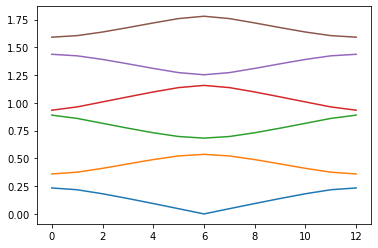

In [8]:
plt.plot(tm_freqs)

plt.plot(material_region)

In [7]:
# get the modes at specific k points
kx =0.779468
ky = 0.04837891
kz = 0
# E_1 is without the Bloch envelope, E_1b is with it
E_1, omega_1, vg = get_mode_info(ms, mp.Vector3(kx, ky, kz), pol="tm", bloch_phase=False)
E_1b, omega_1, vg = get_mode_info(ms, mp.Vector3(kx, ky, kz), pol="tm", bloch_phase=True)
E_2, omega_2, vg = get_mode_info(ms, mp.Vector3(kx, ky, kz), pol="tm")

pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.779468, 0.04837891, 0.0>
elapsed time for initialization: 0.022548198699951172
solve_kpoint (0.779468,0.0483789,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged af

In [8]:
np.savez("phc_an_files/phc1d_modes_k0x-0.779468_k0par-0.048378_b-4_tm.npz", E_1, E_1b)

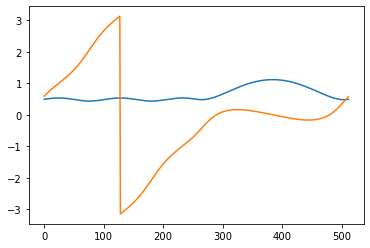

In [12]:
plt.plot(np.abs(E_1[3, 2, :, 0, 0]))
# plt.plot(np.real(E_1[3, 2, :, 0, 0]))
# plt.plot(np.imag(E_1[3, 2, :, 0, 0]))
plt.plot(np.angle(E_1[3, 2, :, 0, 0]))

In [67]:
np.savez("phc_an_files/phc1d_modes_i_13_tm.npz", E_1)

In [18]:
b = 1
M_1_x = get_M_grid_1D(E_1[b, 0, :, 0, 0], material_region, 7, 1)
M_1_y = get_M_grid_1D(E_1[b, 1, :, 0, 0], material_region, 7, 1)
M_1_z = get_M_grid_1D(E_1[b, 2, :, 0, 0], material_region, 7, 1)
M_2_x = get_M_grid_1D(E_1b[b, 0, :, 0, 0], material_region, 7, 1)
M_2_y = get_M_grid_1D(E_1b[b, 1, :, 0, 0], material_region, 7, 1)
M_2_z = get_M_grid_1D(E_1b[b, 2, :, 0, 0], material_region, 7, 1)

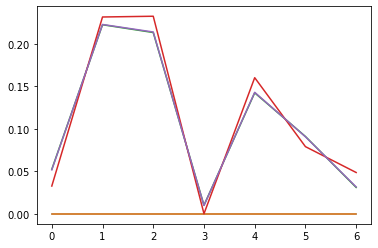

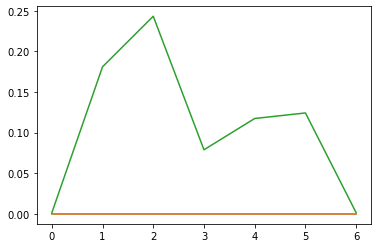

In [19]:
plt.plot(M_1_x)
plt.plot(M_1_y)
plt.plot(M_1_z)
plt.show()

plt.plot(M_2_x)
plt.plot(M_2_y)
plt.plot(M_2_z)
plt.show()


In [35]:
np.savez("phc_an_files/phc1d_M_1_z_kpar-0.3_tm.npz", M_1_z)

In [20]:
# get all the points needed for the analysis
num_sample = 25
BZ_sample = np.linspace(-0.5,0.5, num_sample)
print(BZ_sample)
num_bands = 6
# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 7

Mx_vals_te = np.zeros([num_bands, num_sample, num_sample, N_offset])
Mpar_vals_te = np.zeros([num_bands, num_sample, num_sample, N_offset])
omega_vals_te = np.zeros([num_bands, num_sample, num_sample])
vg_vals_te = np.zeros([num_bands, num_sample, num_sample])

Mx_vals_tm = np.zeros([num_bands, num_sample, num_sample, N_offset])
Mpar_vals_tm = np.zeros([num_bands, num_sample, num_sample, N_offset])
omega_vals_tm = np.zeros([num_bands, num_sample, num_sample])
vg_vals_tm = np.zeros([num_bands, num_sample, num_sample])



for (l, kx) in enumerate(BZ_sample):
    for (m, kpar) in enumerate(BZ_sample*8):
        k = mp.Vector3(kx, kpar, 0)
        E, omega, vgmag = get_mode_info(ms, k, pol="te")
        for i in range(num_bands):
            Ex = np.array(E[i,0,:,0,0])
            Epar = np.array(E[i,1,:,0,0])
            Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
            Mpar = get_M_grid_1D(Epar, material_region, N_offset,1)
            Mx_vals_te[i,l,m,:] = Mx
            Mpar_vals_te[i,l,m,:] = Mpar
        omega_vals_te[:,l,m] = omega
        vg_vals_te[:,l,m] = vgmag
        E, omega, vgmag = get_mode_info(ms, k, pol="tm")
        for i in range(num_bands):
            Ex = np.array(E[i,0,:,0,0])
            Epar = np.array(E[i,2,:,0,0])
            Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
            Mpar = get_M_grid_1D(Epar, material_region, N_offset,1)
            Mx_vals_tm[i,l,m,:] = Mx
            Mpar_vals_tm[i,l,m,:] = Mpar
        omega_vals_tm[:,l,m] = omega
        vg_vals_tm[:,l,m] = vgmag
#             if kz == 0:
#                 E, omega, vgmag = get_mode_info(ms, k)
#             else:
#                 E, omega, vgmag = get_mode_info(ms, k, pol="tm")
#             Mbands = []
#             for i in range(num_bands):
#                 Ex = np.array(E[i,0,:,0,0])
#                 Ey = np.array(E[i,1,:,0,0])
#                 Ez = np.array(E[i,2,:,0,0])
#                 Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
#                 My = get_M_grid_1D(Ey, material_region, N_offset,1)
#                 Mz = get_M_grid_1D(Ez, material_region, N_offset,1)
#                 Mx_vals_tm[i,l,m,n,:] = Mx
#                 My_vals_tm[i,l,m,n,:] = My
#                 Mz_vals_tm[i,l,m,n,:] = Mz
#             omega_vals_tm[:,l,m,n] = omega
#             vg_vals_tm[:,l,m,n] = vgmag

[-0.5        -0.45833333 -0.41666667 -0.375      -0.33333333 -0.29166667
 -0.25       -0.20833333 -0.16666667 -0.125      -0.08333333 -0.04166667
  0.          0.04166667  0.08333333  0.125       0.16666667  0.20833333
  0.25        0.29166667  0.33333333  0.375       0.41666667  0.45833333
  0.5       ]
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vect

    iteration    7: trace = 30.92882480643704 (0.0753363% change)
    iteration    8: trace = 30.92298523865999 (0.0188824% change)
    iteration    9: trace = 30.92217899956323 (0.00260728% change)
    iteration   10: trace = 30.92200296561425 (0.000569282% change)
    switching back to exact line minimization
    iteration   11: trace = 30.92197689261393 (8.43186e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 30.92197307759842 (1.23376e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 30.92197204722119 (3.33218e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.5, -3.66667, 0, 3.7006, 1.6469, 1.79944, 2.02735, 2.30677, 2.61853, 2.9468
elapsed time for k point: 0.06557774543762207
Fixing e-field (band 1) phase by -0.404143 + -0.914696i; max ampl. = 0.825
Fixing e-field (band 2) phase by 0.499805 + 0.866138i; max ampl. = 0.696447
Fixing e-field (band 3) phase by 0.835682 + -0.549214i; 

    iteration    2: trace = 31.16653560456527 (65.191% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 26.95055011887552 (14.5086% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 25.57022532983918 (5.2563% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 25.35175778098829 (0.858048% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 25.32426359973183 (0.10851% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 25.3185691196226 (0.0224888% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 25.31749759491891 (0.00423226% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 25.31733165494398 (0.000655438% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 25.31732064397179 (4.34918e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 25.3173

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.5, -2.666666666666667, 0.0>
elapsed time for initialization: 0.019010066986083984
solve_kpoint (-0.5,-2.66667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 46.19179442492933 (199.755% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 24.39540785817956 (61.7573% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 22.88353615701519 (6.39554% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 22.60003906377144 (1.24659% change)
    linmin: converged after 4 iterations.
    iterat

Fixing e-field (band 3) phase by -0.996291 + -0.0860522i; max ampl. = 0.614926
Fixing e-field (band 4) phase by -0.534482 + 0.84518i; max ampl. = 0.737795
Fixing e-field (band 5) phase by -0.998986 + 0.0450269i; max ampl. = 0.880271
Fixing e-field (band 6) phase by -0.0542121 + 0.998529i; max ampl. = 1.2196
total elapsed time for run: 0.08867192268371582
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
In

    iteration    9: trace = 15.20901160786243 (0.00109464% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 15.208991806827 (0.000130193% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 15.20898913094833 (1.75941e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 15.20898885826242 (1.79293e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.5, -2, 0, 2.06155, 0.927453, 1.09283, 1.34439, 1.64172, 1.98284, 2.17262
elapsed time for k point: 0.06632089614868164
Fixing e-field (band 1) phase by 0.708168 + -0.706044i; max ampl. = 0.758123
Fixing e-field (band 2) phase by 0.0629814 + -0.998015i; max ampl. = 0.688802
Fixing e-field (band 3) phase by -0.84174 + -0.539884i; max ampl. = 0.801185
Fixing e-field (band 4) phase by -0.983777 + -0.179397i; max ampl. = 0.780708
Fixing e-field (band 5) phase by -0.973468 + 0.228824i; max ampl. = 0.812022
Fixing e-field (band 6) phas

    linmin: converged after 2 iterations.
    iteration    9: trace = 11.13277846507343 (1.49596e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 11.13277836490942 (8.99722e-07% change)
Finished solving for bands 1 to 6 after 10 iterations.
tefreqs:, 1, -0.5, -1.33333, 0, 1.424, 0.701098, 0.95851, 1.27507, 1.36336, 1.74831, 1.78363
elapsed time for k point: 0.04645395278930664
Fixing e-field (band 1) phase by 0.335801 + 0.941933i; max ampl. = 0.681917
Fixing e-field (band 2) phase by -0.962408 + 0.271609i; max ampl. = 0.652735
Fixing e-field (band 3) phase by 0.771738 + 0.635941i; max ampl. = 0.729462
Fixing e-field (band 4) phase by 0.204805 + -0.978803i; max ampl. = 1.19224
Fixing e-field (band 5) phase by 0.601627 + 0.798777i; max ampl. = 0.846937
Fixing e-field (band 6) phase by -0.0186942 + -0.999825i; max ampl. = 0.80997
total elapsed time for run: 0.07494807243347168
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 toler

Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, -0.5, -1, 0, 1.11803, 0.514475, 0.70227, 1.03805, 1.23481, 1.57733, 1.72122
elapsed time for k point: 0.04416513442993164
Fixing e-field (band 1) phase by 0.713851 + -0.700298i; max ampl. = 0.71236
Fixing e-field (band 2) phase by -0.811187 + -0.584787i; max ampl. = 0.62761
Fixing e-field (band 3) phase by 0.998301 + 0.0582715i; max ampl. = 0.794738
Fixing e-field (band 4) phase by -0.882292 + -0.470702i; max ampl. = 1.27528
Fixing e-field (band 5) phase by -0.906068 + -0.423132i; max ampl. = 1.37313
Fixing e-field (band 6) phase by 0.849415 + 0.527725i; max ampl. = 0.792377
total elapsed time for run: 0.0692899227142334
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice 

Fixing e-field (band 6) phase by -0.71809 + 0.695951i; max ampl. = 0.916527
total elapsed time for run: 0.0836338996887207
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.5, -0.3333333333333335, 0.0>
elapsed time for initialization: 0.01802968978881836
solve_kpoint (-0.5,-0.333333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm b

     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.5, 0.33333333333333304, 0.0>
elapsed time for initialization: 0.015522003173828125
solve_kpoint (-0.5,0.333333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 20.04225644479375 (199.897% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 9.634496647807918 (70.1408% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.761676477378091 (21.5314% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 6.906085203840115 (1

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 19.14617182381055 (199.891% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 8.11302892964024 (80.9499% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.570595915016164 (6.91719% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 7.519911266490802 (0.671742% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 7.515346484771987 (0.060721% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 7.515215325882633 (0.00174523% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 7.515209968721941 (7.12842e-05% change)
    iteration    8

    linmin: converged after 5 iterations.
    iteration    3: trace = 11.52529319368097 (12.2624% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 11.18318376700526 (3.01305% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 11.1376202100531 (0.408261% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 11.13313353034046 (0.0402921% change)
    iteration    7: trace = 11.13281376797481 (0.00287221% change)
    iteration    8: trace = 11.13278055087098 (0.000298372% change)
    iteration    9: trace = 11.13277848520607 (1.85548e-05% change)
    iteration   10: trace = 11.13277836933425 (1.04082e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tefreqs:, 1, -0.5, 1.33333, 0, 1.424, 0.701098, 0.95851, 1.27507, 1.36336, 1.74831, 1.78363
elapsed time for k point: 0.06204962730407715
Fixing e-field (band 1) phase by -0.938

    iteration    4: trace = 12.74866155894152 (1.48835% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 12.72125597441674 (0.2152% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 12.71953878483587 (0.0134995% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 12.7194607923986 (0.000613172% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 12.71945037894956 (8.18702e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 12.71944968470954 (5.4581e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, -0.5, 1.66667, 0, 1.74005, 0.787954, 0.96443, 1.2349, 1.53043, 1.89174, 1.9294
elapsed time for k point: 0.06578969955444336
Fixing e-field (band 1) phase by -0.702394 + -0.711789i; max ampl. = 0.744955
Fixing e-field (band 2) phase by -0.777674 + 0.628667i; max ampl. = 0.675091
Fixing e-field (band 3) phase by -0.992928 + 0.1

    linmin: converged after 6 iterations.
    iteration    2: trace = 21.78020299617993 (60.9511% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 20.09602158747795 (8.04362% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 19.62397749007862 (2.37686% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 19.47373048779048 (0.768572% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 19.43616903429488 (0.193069% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 19.43037060830462 (0.0298376% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 19.42911750000877 (0.00644943% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 19.4288751376642 (0.00124743% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 19.42883886034091 (0.000186719% change)
    linmin: converged after 2 ite

Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.5, 2.666666666666666, 0.0>
elapsed time for initialization: 0.019675493240356445
solve_kpoint (-0.5,2.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 39.3997523062822 (199.787% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 23.5094175049

Fixing e-field (band 6) phase by -0.993651 + -0.112509i; max ampl. = 0.814295
total elapsed time for run: 0.08330988883972168
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.5, 3.333333333333333, 0.0>
elapsed time for initialization: 0.021398544311523438
solve_kpoint (-0.5,3.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te b

    linmin: converged after 2 iterations.
    iteration   13: trace = 30.92208398118302 (0.00155577% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 30.92200326326209 (0.000261037% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 30.92198329861131 (6.45646e-05% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 30.92197369867078 (3.10457e-05% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 30.92197196656625 (5.60153e-06% change)
Finished solving for bands 1 to 6 after 17 iterations.
tefreqs:, 1, -0.5, 3.66667, 0, 3.7006, 1.6469, 1.79944, 2.02735, 2.30677, 2.61853, 2.9468
elapsed time for k point: 0.06751656532287598
Fixing e-field (band 1) phase by 0.311734 + 0.95017i; max ampl. = 0.824998
Fixing e-field (band 2) phase by 0.949453 + 0.31391i; max ampl. = 0.696447
Fixing e-field (band 3) phase by -0.945645 + -0.3252i; max ampl. = 0.667805
Fixing e-field (band 4) phase by 0

    iteration    6: trace = 31.39890804913927 (0.805509% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 31.31444975562512 (0.269347% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 31.29888400912706 (0.0497202% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 31.29767078596289 (0.00387633% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 31.29756740471398 (0.000330317% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 31.29755558551588 (3.7764e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 31.29755346333359 (6.78066e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.5, 4, 0, 4.03113, 1.77642, 1.88998, 2.06945, 2.30311, 2.57901, 2.88645
elapsed time for k point: 0.0529632568359375
Fixing e-field (band 1) phase by -0.640907 + 0.767619i; max ampl. = 0.803202
Fixing e-field (ba

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4583333333333333, -3.6666666666666665, 0.0>
elapsed time for initialization: 0.019973278045654297
solve_kpoint (-0.458333,-3.66667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 70.368611902654 (199.643% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 37.29553958376376 (61.4375% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 33.53451507395391 (10.6199% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 32.33149283021376 (3.65294% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 31.43614849678678 (2.80815% change)
    linmin: converged after 4 iterations.
  

Fixing e-field (band 1) phase by 0.986277 + -0.165099i; max ampl. = 0.818137
Fixing e-field (band 2) phase by -0.91449 + 0.404609i; max ampl. = 0.688257
Fixing e-field (band 3) phase by 0.977373 + -0.211523i; max ampl. = 0.641635
Fixing e-field (band 4) phase by -0.684382 + -0.729124i; max ampl. = 0.634718
Fixing e-field (band 5) phase by -0.859713 + -0.510778i; max ampl. = 0.673779
Fixing e-field (band 6) phase by 0.982005 + -0.188854i; max ampl. = 0.746021
total elapsed time for run: 0.07960748672485352
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), 

    iteration   11: trace = 22.65432816326339 (1.36288e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, -0.458333, -3, 0, 3.03481, 1.35008, 1.48554, 1.69557, 1.96191, 2.26861, 2.59887
elapsed time for k point: 0.050089359283447266
Fixing e-field (band 1) phase by 0.116852 + -0.993149i; max ampl. = 0.786114
Fixing e-field (band 2) phase by 0.232449 + 0.972609i; max ampl. = 0.72731
Fixing e-field (band 3) phase by -0.482147 + 0.876091i; max ampl. = 0.809494
Fixing e-field (band 4) phase by 0.0771035 + 0.997023i; max ampl. = 0.801181
Fixing e-field (band 5) phase by -0.913502 + -0.406835i; max ampl. = 0.826055
Fixing e-field (band 6) phase by -0.0649273 + 0.99789i; max ampl. = 0.815866
total elapsed time for run: 0.07764410972595215
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
    

    linmin: converged after 4 iterations.
    iteration    9: trace = 19.43234205754231 (0.00936874% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 19.43209318273173 (0.00128073% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 19.43205641840878 (0.000189194% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 19.43204988106576 (3.36421e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 19.43204853967332 (6.90299e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.458333, -2.33333, 0, 2.37792, 1.09354, 1.30266, 1.58665, 1.89694, 2.20884, 2.35467
elapsed time for k point: 0.05569744110107422
Fixing e-field (band 1) phase by -0.0230867 + 0.999733i; max ampl. = 0.782107
Fixing e-field (band 2) phase by -0.305142 + -0.952307i; max ampl. = 0.608663
Fixing e-field (band 3) phase by -0.999999 + 0.00169904i; max ampl. = 0.618598
Fixing e-field (b

    iteration    3: trace = 16.32543227462769 (11.0353% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 15.81326770441377 (3.18721% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 15.37090782378468 (2.83708% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 15.23926485462085 (0.860126% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 15.21593807346004 (0.153187% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 15.21242195458627 (0.0231108% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 15.21186498691643 (0.00366134% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 15.21183138834706 (0.000220871% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 15.21182092930189 (6.8756e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 15.2

1 k-points
  Vector3<-0.4583333333333333, -1.3333333333333335, 0.0>
elapsed time for initialization: 0.02861642837524414
solve_kpoint (-0.458333,-1.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 27.39858089762393 (199.858% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 11.88555523604041 (78.9786% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 11.21917138388416 (5.76838% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 11.14524729903682 (0.661087% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 11.13683752889963 (0.0754846% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 11.13629431221999 (0.00487778% change)
    linmin: converged after 2 iterations

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 14.22082425289264 (199.928% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 7.426997984654753 (62.7668% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 6.836172703452196 (8.28463% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 6.760575331409082 (1.11199% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 6.755716643252064 (0.0718938% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 6.755511464799564 (0.00303715% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 6.755503089678148 (0.000123975% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.755502625831418 

    linmin: converged after 4 iterations.
    iteration    5: trace = 6.452168689831033 (0.0168124% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 6.45209678095562 (0.0011145% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 6.452093003980909 (5.85387e-05% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.452092910727575 (1.44532e-06% change)
Finished solving for bands 1 to 6 after 8 iterations.
tmfreqs:, 1, -0.458333, 0, 0, 0.458333, 0.229431, 0.364337, 0.879561, 0.944092, 1.43399, 1.59545
elapsed time for k point: 0.046204328536987305
Fixing e-field (band 1) phase by 0.870243 + -0.492623i; max ampl. = 0.667589
Fixing e-field (band 2) phase by -0.597921 + -0.801555i; max ampl. = 0.87132
Fixing e-field (band 3) phase by -0.614536 + 0.788889i; max ampl. = 0.731054
Fixing e-field (band 4) phase by -0.557782 + -0.829988i; max ampl. = 1.28389
Fixing e-field (band 5) phase by 0.356552 + -0.934275i; max

Finished solving for bands 1 to 6 after 8 iterations.
tefreqs:, 1, -0.458333, 0.666667, 0, 0.80902, 0.472903, 0.617184, 0.977025, 1.05743, 1.50678, 1.64602
elapsed time for k point: 0.0449213981628418
Fixing e-field (band 1) phase by -0.28827 + 0.957549i; max ampl. = 0.487309
Fixing e-field (band 2) phase by 0.0216352 + 0.999766i; max ampl. = 1.11405
Fixing e-field (band 3) phase by -0.464308 + 0.885674i; max ampl. = 0.670052
Fixing e-field (band 4) phase by 0.570843 + 0.82106i; max ampl. = 1.0205
Fixing e-field (band 5) phase by 0.0398876 + -0.999204i; max ampl. = 1.0199
Fixing e-field (band 6) phase by -0.814998 + 0.579464i; max ampl. = 0.846407
total elapsed time for run: 0.07925939559936523
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal 

Fixing e-field (band 5) phase by 0.708683 + -0.705527i; max ampl. = 1.35996
Fixing e-field (band 6) phase by -0.946507 + -0.322684i; max ampl. = 0.816005
total elapsed time for run: 0.0756988525390625
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4583333333333333, 1.333333333333333, 0.0>
elapsed time for initialization: 0.0199248790740966

Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4583333333333333, 1.666666666666666, 0.0>
elapsed time for initialization: 0.017452478408813477
solve_kpoint (-0.458333,1.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 26.33580599789025 (199.849% change)
    linmin: converged after 7 iterations.
    iteration    2: 

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4583333333333333, 2.333333333333333, 0.0>
elapsed time for initialization: 0.01768040657043457
solve_kpoint (-0.458333,2.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 37.37411234608917 (199.805% change)
    li

Fixing e-field (band 3) phase by -0.998711 + -0.0507601i; max ampl. = 0.59209
Fixing e-field (band 4) phase by -0.923651 + -0.383236i; max ampl. = 0.671875
Fixing e-field (band 5) phase by -0.986363 + -0.164586i; max ampl. = 0.739807
Fixing e-field (band 6) phase by -0.384947 + -0.922939i; max ampl. = 0.883411
total elapsed time for run: 0.0732119083404541
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.


tmfreqs:, 1, -0.458333, 3, 0, 3.03481, 1.35008, 1.48554, 1.69557, 1.96191, 2.26861, 2.59887
elapsed time for k point: 0.08574342727661133
Fixing e-field (band 1) phase by -0.232004 + 0.972715i; max ampl. = 0.786109
Fixing e-field (band 2) phase by 0.261257 + -0.965269i; max ampl. = 0.727325
Fixing e-field (band 3) phase by -0.985263 + -0.171044i; max ampl. = 0.809455
Fixing e-field (band 4) phase by 0.873955 + 0.486007i; max ampl. = 0.801159
Fixing e-field (band 5) phase by -0.209501 + 0.977808i; max ampl. = 0.826103
Fixing e-field (band 6) phase by 0.951669 + 0.307124i; max ampl. = 0.816013
total elapsed time for run: 0.12191200256347656
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0

    iteration    9: trace = 30.92271764074971 (0.00893261% change)
    iteration   10: trace = 30.92213237458192 (0.00189269% change)
    iteration   11: trace = 30.92201808019887 (0.000369621% change)
    iteration   12: trace = 30.92200413214898 (4.51072e-05% change)
    iteration   13: trace = 30.92200168741444 (7.90613e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.458333, 3.66667, 0, 3.6952, 1.6469, 1.79944, 2.02735, 2.30677, 2.61853, 2.94681
elapsed time for k point: 0.055577754974365234
Fixing e-field (band 1) phase by 0.281046 + 0.959694i; max ampl. = 0.824992
Fixing e-field (band 2) phase by -0.989701 + -0.143147i; max ampl. = 0.705015
Fixing e-field (band 3) phase by -0.36179 + -0.93226i; max ampl. = 0.667804
Fixing e-field (band 4) phase by 0.0495638 + -0.998771i; max ampl. = 0.612362
Fixing e-field (band 5) phase by -0.568001 + 0.823028i; max ampl. = 0.659264
Fixing e-field (band 6) phase by 0.574984 + 0.818164i; max ampl. = 0.696101
tot

    linmin: converged after 6 iterations.
    iteration    2: trace = 34.38719058862768 (67.8197% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 31.95463862664353 (7.33339% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 31.4971895616057 (1.44188% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 31.34225145151078 (0.493124% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 31.30251781829709 (0.126854% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 31.29809765645924 (0.0141218% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 31.29759481873981 (0.00160662% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 31.29755997119116 (0.000111343% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 31.29755738420894 (8.26576e-06% change)
Finished solving for bands 1 to 

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 76.36939349102293 (199.616% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 39.42790634190602 (63.8037% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 34.40446023928504 (13.6077% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 33.48135975175071 (2.71957% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 32.91761519875534 (1.69805% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 32.3373038843723 (1.7786% change)
    linmin: converged after 5 iterations.
    iteration    7: trace = 31.65000832105138 (2.14822% change)
    linmin: converged after 6 iterations.
    iteration    8: trace = 31.10318799737782 (1.74276% ch

Fixing e-field (band 2) phase by -0.457483 + -0.889218i; max ampl. = 0.696127
Fixing e-field (band 3) phase by -0.256771 + -0.966472i; max ampl. = 0.641634
Fixing e-field (band 4) phase by -0.964276 + -0.264898i; max ampl. = 0.634689
Fixing e-field (band 5) phase by 0.0432353 + 0.999065i; max ampl. = 0.67517
Fixing e-field (band 6) phase by 0.57954 + 0.814944i; max ampl. = 0.695772
total elapsed time for run: 0.09663867950439453
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual obj

    iteration    5: trace = 22.7789771175476 (2.22847% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 22.67453802674175 (0.459542% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 22.65769607139125 (0.0743045% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 22.65507543327274 (0.0115669% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 22.65478774026422 (0.00126989% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 22.65476211032036 (0.000113133% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 22.65475868114441 (1.51367e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 22.65475800383756 (2.98969e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.416667, -3, 0, 3.0288, 1.35008, 1.48554, 1.69557, 1.96193, 2.26858, 2.59898
elapsed time for k point: 0.

Initializing fields to random numbers...
1 k-points
  Vector3<-0.4166666666666667, -2.3333333333333335, 0.0>
elapsed time for initialization: 0.015858888626098633
solve_kpoint (-0.416667,-2.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 47.68751024758688 (199.754% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 23.89772516147636 (66.4656% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 20.19637131497651 (16.7884% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 19.6089265172547 (2.95159% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 19.47936361353482 (0.662924% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 19.44985667859748 (0.151593% change)
   

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4166666666666667, -2.0, 0.0>
elapsed time for initialization: 0.01874542236328125
solve_kpoint (-0.416667,-2,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 6 iterations.
    iteration    1: trace = 34.48620188770526 (199.813% change)
    linmin: converged af

total elapsed time for run: 0.08532142639160156
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4166666666666667, -1.3333333333333335, 0.0>
elapsed time for initialization: 0.020430564880371094
solve_kpoint (-0.416667,-1.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solvi

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4166666666666667, -1.0, 0.0>
elapsed time for initialization: 0.0193479061126709
solve_kpoint (-0.416667,-1,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 17.78905662448871 (199.902% change)
    linmin: converged af

     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4166666666666667, -0.3333333333333335, 0.0>
elapsed time for initialization: 0.02037978172302246
solve_kpoint (-0.416667,-0.333333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 18.83817834493231 (199.901% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 8.686597642908236 (73.7632% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.701306582015054 (12.0246% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 16.40096319549916 (199.91% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 7.87098383988832 (70.2867% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 6.776672804001209 (14.9418% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 6.481799034771857 (4.44808% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 6.463872226800639 (0.276954% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 6.462649490625191 (0.0189183% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 6.462570368241756 (0.00122431% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.462567424670959 (4.55

    linmin: converged after 7 iterations.
    iteration    2: trace = 8.414516195780944 (52.968% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.758946050901968 (8.10674% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 7.673918639900196 (1.1019% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 7.66796300220593 (0.0776389% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 7.667410883611935 (0.00720059% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 7.667377684579328 (0.00043299% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 7.667376360084356 (1.72744e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 7.667376302593408 (7.49813e-07% change)
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 1, -0.416667, 0.666667, 0, 0.786165, 0.470249, 0.622123, 0.962312, 1.07253,

    linmin: converged after 7 iterations.
    iteration    2: trace = 9.312584914529324 (48.9348% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 8.897728312598463 (4.55628% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 8.828388551391438 (0.782346% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 8.823466931970559 (0.0557632% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 8.823235783795406 (0.00261973% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 8.823221448707695 (0.00016247% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 8.823220800327249 (7.34857e-06% change)
Finished solving for bands 1 to 6 after 8 iterations.
tmfreqs:, 1, -0.416667, 1, 0, 1.08333, 0.513614, 0.704252, 1.03336, 1.24162, 1.56563, 1.73286
elapsed time for k point: 0.05016517639160156
Fixing e-field (band 1) phase by 0.97852 + -0.20615

    linmin: converged after 4 iterations.
    iteration    5: trace = 13.64295314854352 (1.73587% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 13.61656274532241 (0.193623% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 13.61309453307313 (0.0254738% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 13.61257562536961 (0.0038119% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 13.61250507251097 (0.000518293% change)
    iteration   10: trace = 13.61249843155637 (4.87857e-05% change)
    iteration   11: trace = 13.61249758343631 (6.23045e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tefreqs:, 1, -0.416667, 1.66667, 0, 1.71796, 0.827969, 1.07411, 1.38028, 1.60261, 1.87344, 1.94678
elapsed time for k point: 0.05112886428833008
Fixing e-field (band 1) phase by -0.835508 + 0.549479i

Finished solving for bands 1 to 6 after 15 iterations.
tmfreqs:, 1, -0.416667, 2.33333, 0, 2.37024, 1.06776, 1.2223, 1.45816, 1.74755, 2.07529, 2.37901
elapsed time for k point: 0.08516335487365723
Fixing e-field (band 1) phase by -0.973906 + -0.22695i; max ampl. = 0.769176
Fixing e-field (band 2) phase by 0.994846 + -0.101393i; max ampl. = 0.723753
Fixing e-field (band 3) phase by -0.396792 + 0.917909i; max ampl. = 0.803924
Fixing e-field (band 4) phase by 0.861205 + -0.508257i; max ampl. = 0.797158
Fixing e-field (band 5) phase by -0.132436 + 0.991191i; max ampl. = 0.818277
Fixing e-field (band 6) phase by 0.039443 + -0.999222i; max ampl. = 0.906678
total elapsed time for run: 0.12108421325683594
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Recipro

    linmin: converged after 4 iterations.
    iteration    8: trace = 25.28062977015959 (0.0358915% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 25.27884578134583 (0.00705699% change)
    iteration   10: trace = 25.27854612639374 (0.00118541% change)
    iteration   11: trace = 25.27849898428792 (0.000186491% change)
    iteration   12: trace = 25.27848902059071 (3.94157e-05% change)
    iteration   13: trace = 25.27848661587076 (9.51291e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.416667, 3, 0, 3.0288, 1.36782, 1.54512, 1.80023, 2.10108, 2.42401, 2.7366
elapsed time for k point: 0.06792044639587402
Fixing e-field (band 1) phase by 0.975215 + 0.22126i; max ampl. = 0.809309
Fixing e-field (band 2) phase by -0.746829 + -0.665017i; max ampl. = 0.675253
Fixing e-field (band 3) phase by -0.677856 + 0.735195i; max ampl. = 0.610727
Fixing e-field (band

    iteration    2: trace = 28.79001306756694 (78.2861% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 25.76559722169146 (11.0875% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 25.41558571941695 (1.36774% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 25.33836936112232 (0.304277% change)
    iteration    6: trace = 25.32075547132511 (0.0695389% change)
    iteration    7: trace = 25.31781531929852 (0.0116123% change)
    iteration    8: trace = 25.31750794952638 (0.00121405% change)
    iteration    9: trace = 25.31748480988966 (9.13978e-05% change)
    iteration   10: trace = 25.31748321577397 (6.2965e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, -0.416667, 3.33333, 0, 3.35927, 1.49187, 1.61924, 1.81813, 2.07302, 2.3692, 2.69328
elapsed time for k point: 0.050795555114746094
Fixing e-fiel

Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4166666666666667, 4.0, 0.0>
elapsed time for initialization: 0.020277023315429688
solve_kpoint (-0.416667,4,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 83.38475886763524 (199.582% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 43.97044360299635 (61.8967% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 37.37044901108543 (16.228% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 34.94835813555048 (6.69837% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 34.23882033579804 (2.05107

Fixing e-field (band 5) phase by 0.853132 + 0.521695i; max ampl. = 0.644834
Fixing e-field (band 6) phase by -0.651841 + 0.758355i; max ampl. = 0.687349
total elapsed time for run: 0.09557271003723145
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.375, -4.0, 0.0>
elapsed time for initialization: 0.018558263778686523
solve_kpoint (-0.375,-4

    iteration   10: trace = 25.28159500640346 (0.00170711% change)
    iteration   11: trace = 25.28148178453138 (0.000447844% change)
    iteration   12: trace = 25.28145123140748 (0.000120852% change)
    iteration   13: trace = 25.28144441787759 (2.69507e-05% change)
    iteration   14: trace = 25.28144333883928 (4.2681e-06% change)
Finished solving for bands 1 to 6 after 14 iterations.
tefreqs:, 1, -0.375, -3, 0, 3.02335, 1.36782, 1.54512, 1.80023, 2.1011, 2.4239, 2.73722
elapsed time for k point: 0.06207895278930664
Fixing e-field (band 1) phase by -0.91707 + 0.398726i; max ampl. = 0.809313
Fixing e-field (band 2) phase by 0.990422 + -0.138077i; max ampl. = 0.682388
Fixing e-field (band 3) phase by 0.999898 + 0.0142767i; max ampl. = 0.61073
Fixing e-field (band 4) phase by -0.771446 + -0.636295i; max ampl. = 0.655495
Fixing e-field (band 5) phase by -0.644247 + -0.764817i; max ampl. = 0.685628
Fixing e-field (band 6) phase by -0.310524 + 0.950566i; max ampl. = 0.716041
total elaps

    linmin: converged after 6 iterations.
    iteration    3: trace = 20.50846172994419 (10.2161% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 20.25673601038104 (1.235% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 20.19590218080341 (0.300766% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 20.1829985956022 (0.0639125% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 20.18191067293719 (0.00539044% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 20.18175870380204 (0.000753% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 20.18173660362495 (0.000109506% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 20.18173096081876 (2.796e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 20.18173055132122 (2.02905e-06% change)
Finished solving for bands 1 to 

Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.375, -2.0, 0.0>
elapsed time for initialization: 0.017458200454711914
solve_kpoint (-0.375,-2,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 34.71973929031963 (199.826% change)
    linmin: converged after 6 iterations.
    iteration    2: tra

Fixing e-field (band 4) phase by 0.999682 + 0.0252183i; max ampl. = 0.942972
Fixing e-field (band 5) phase by -0.798547 + -0.601933i; max ampl. = 0.864685
Fixing e-field (band 6) phase by 0.989181 + -0.146703i; max ampl. = 0.850232
total elapsed time for run: 0.11737442016601562
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.375, -1.666666

total elapsed time for run: 0.08392691612243652
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.375, -1.0, 0.0>
elapsed time for initialization: 0.015878915786743164
solve_kpoint (-0.375,-1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maxim

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.375, -0.666666666666667, 0.0>
elapsed time for initialization: 0.02096700668334961
solve_kpoint (-0.375,-0.666667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 17.34489875422963 (199.904% change)
    linmin: conver

     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.375, 0.0, 0.0>
elapsed time for initialization: 0.01987600326538086
solve_kpoint (-0.375,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 16.29797709526258 (199.916% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 7.559351891963869 (73.2574% change)
    linmin: converged after 5 iterations.
    iteration    3: tra

1 k-points
  Vector3<-0.375, 0.33333333333333304, 0.0>
elapsed time for initialization: 0.02019977569580078
solve_kpoint (-0.375,0.333333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 14.52264643049786 (199.924% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 7.149245105203534 (68.0458% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 6.801779043464643 (4.98123% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 6.753904444696949 (0.70634% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 6.749170359226889 (0.0701186% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 6.748939747168598 (0.00341695% change)
    linmin: converged after 2 iterations.
    iteration 

    iteration    2: trace = 9.625152154948911 (51.0919% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 9.222766410154849 (4.26982% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 9.164118242924978 (0.637935% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 9.159244131009883 (0.0532011% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 9.158777104068839 (0.0050991% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 9.158718868457111 (0.000635847% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 9.158715115666363 (4.09751e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 9.158714841921029 (2.98891e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 1, -0.375, 1, 0, 1.068, 0.579718, 0.824732, 1.09295, 1.20709, 1.57413, 1.73579
elapsed time for k point: 0.078763

    iteration    6: trace = 10.58704512017133 (0.0162546% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 10.58695799986558 (0.000822899% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 10.58695066588742 (6.92737e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 10.58695017093306 (4.67514e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, -0.375, 1.33333, 0, 1.38506, 0.649219, 0.837162, 1.12792, 1.40562, 1.69291, 1.8305
elapsed time for k point: 0.06281495094299316
Fixing e-field (band 1) phase by -0.497158 + -0.86766i; max ampl. = 0.728038
Fixing e-field (band 2) phase by 0.417964 + -0.908463i; max ampl. = 0.699766
Fixing e-field (band 3) phase by -0.536373 + -0.843981i; max ampl. = 0.791895
Fixing e-field (band 4) phase by -0.3768 + -0.926294i; max ampl. = 0.856721
Fixing e-field (band 5) phase by -0.997702 + 0.0677598i; max ampl. = 1.4978
Fixing e-field (band 6) 

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 16.44382261706927 (0.0122739% change)
    iteration    8: trace = 16.44343778538624 (0.00234031% change)
    iteration    9: trace = 16.44335641199116 (0.00049487% change)
    iteration   10: trace = 16.44334580724736 (6.44926e-05% change)
    iteration   11: trace = 16.44334464705292 (7.05571e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tefreqs:, 1, -0.375, 2, 0, 2.03485, 0.959268, 1.18697, 1.4834, 1.77803, 2.04502, 2.13782
elapsed time for k point: 0.06485509872436523
Fixing e-field (band 1) phase by 0.969571 + 0.244811i; max ampl. = 0.760288
Fixing e-field (band 2) phase by -0.0477127 + -0.998861i; max ampl. = 0.579824
Fixing e-field (band 3) phase by 0.560624 + 0.828071i; max ampl. = 0.646875
Fixing e-field (band 4) phase by -0.975184 + 0.221396i; max ampl. = 0.70428
Fixing e-field (band 5) phase by 0.999913 + 0.0131615i

    linmin: converged after 5 iterations.
    iteration    6: trace = 17.84952911979783 (0.985588% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 17.80526607910187 (0.248287% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 17.79333011027117 (0.0670586% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 17.79106115974366 (0.0127525% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 17.79084245229925 (0.00122932% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 17.79081009720478 (0.000181864% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 17.79080365458624 (3.62132e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 17.79080112427132 (1.42226e-05% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 17.7908007020212 (2.37342e-06% change)
Finished solving for b

     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.375, 3.0, 0.0>
elapsed time for initialization: 0.02664804458618164
solve_kpoint (-0.375,3,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 53.56444003627147 (199.729% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 28.50474278847323 (61.0697% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 26.44310372263985 (7.50398% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 25.786

Fixing e-field (band 2) phase by 0.973169 + -0.230093i; max ampl. = 0.703487
Fixing e-field (band 3) phase by -0.554672 + 0.832069i; max ampl. = 0.64164
Fixing e-field (band 4) phase by -0.947543 + -0.319628i; max ampl. = 0.634736
Fixing e-field (band 5) phase by -0.682562 + 0.730827i; max ampl. = 0.676325
Fixing e-field (band 6) phase by -0.374353 + -0.927286i; max ampl. = 0.696122
total elapsed time for run: 0.08750557899475098
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual ob

    iteration   10: trace = 28.19494553770411 (1.39787e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 28.19494506830916 (1.66482e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, -0.375, 3.66667, 0, 3.68579, 1.634, 1.7541, 1.94285, 2.18681, 2.47269, 2.78874
elapsed time for k point: 0.05146980285644531
Fixing e-field (band 1) phase by -0.665391 + 0.746495i; max ampl. = 0.798313
Fixing e-field (band 2) phase by 0.927476 + 0.373883i; max ampl. = 0.759582
Fixing e-field (band 3) phase by 0.226799 + -0.973942i; max ampl. = 0.814552
Fixing e-field (band 4) phase by 0.550552 + 0.834801i; max ampl. = 0.810913
Fixing e-field (band 5) phase by -0.783125 + 0.621864i; max ampl. = 0.829278
Fixing e-field (band 6) phase by 0.77533 + -0.631556i; max ampl. = 0.827927
total elapsed time for run: 0.0825948715209961
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 5

    linmin: converged after 4 iterations.
    iteration    8: trace = 33.98779964874447 (0.0311231% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 33.98666343054761 (0.00334307% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 33.98642959278166 (0.00068803% change)
    iteration   11: trace = 33.9863989624688 (9.01252e-05% change)
    iteration   12: trace = 33.98639457128434 (1.29204e-05% change)
    iteration   13: trace = 33.98639338489637 (3.49077e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.333333, -4, 0, 4.01386, 1.7876, 1.92993, 2.14555, 2.41377, 2.71718, 3.04196
elapsed time for k point: 0.05640602111816406
Fixing e-field (band 1) phase by -0.894092 + -0.447883i; max ampl. = 0.830442
Fixing e-field (band 2) phase by 0.221094 + -0.975253i; max ampl. = 0.741301
Fixing e-field (band 3) phase by 0.131935 + -0.99125

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 63.45951796956994 (199.652% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 30.32830505317768 (70.6514% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 28.38359416757652 (6.62459% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 28.23020092372397 (0.541894% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 28.20225805259604 (0.0990312% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 28.19643992724238 (0.0206321% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 28.19517538755429 (0.00448485% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 28.19503173219079 (0

Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.33333333333333337, -3.0, 0.0>
elapsed time for initialization: 0.018659114837646484
solve_kpoint (-0.333333,-3,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 53.15073475068753 (199.727% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 28.53091624573149 (60.2824% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 26.166

Fixing e-field (band 6) phase by 0.831726 + 0.555187i; max ampl. = 0.759705
total elapsed time for run: 0.10411715507507324
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.33333333333333337, -2.666666666666667, 0.0>
elapsed time for initialization: 0.018698930740356445
solve_kpoint (-0.333333,-2.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag

    linmin: converged after 2 iterations.
    iteration   13: trace = 17.80450274741206 (2.29828e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tmfreqs:, 1, -0.333333, -2.33333, 0, 2.35702, 1.06774, 1.22238, 1.45796, 1.74799, 2.07397, 2.3849
elapsed time for k point: 0.0598909854888916
Fixing e-field (band 1) phase by 0.435316 + -0.900278i; max ampl. = 0.769056
Fixing e-field (band 2) phase by -0.922232 + -0.386637i; max ampl. = 0.745114
Fixing e-field (band 3) phase by 0.814384 + -0.580326i; max ampl. = 0.80376
Fixing e-field (band 4) phase by -0.999377 + 0.0352868i; max ampl. = 0.803274
Fixing e-field (band 5) phase by -0.46771 + 0.883882i; max ampl. = 0.816051
Fixing e-field (band 6) phase by -0.625135 + 0.780517i; max ampl. = 0.860556
total elapsed time for run: 0.0888376235961914
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell 

    iteration    8: trace = 13.65493024960075 (0.000673895% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 13.65492098796829 (6.78263e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 13.65491996022991 (7.52651e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tefreqs:, 1, -0.333333, -1.66667, 0, 1.69967, 0.827855, 1.07472, 1.37714, 1.61247, 1.83853, 1.98439
elapsed time for k point: 0.05763053894042969
Fixing e-field (band 1) phase by -0.967363 + 0.253396i; max ampl. = 0.728692
Fixing e-field (band 2) phase by -0.223435 + -0.974719i; max ampl. = 0.604903
Fixing e-field (band 3) phase by 0.68375 + 0.729717i; max ampl. = 0.891784
Fixing e-field (band 4) phase by -0.165431 + -0.986221i; max ampl. = 0.919389
Fixing e-field (band 5) phase by 0.999636 + -0.0269694i; max ampl. = 0.884946
Fixing e-field (band 6) phase by 0.905709 + -0.423899i; max ampl. = 0.844406
total elapsed time for run: 0.09696364402770996


    linmin: converged after 4 iterations.
    iteration    5: trace = 10.60649047764515 (0.0266102% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 10.6062741730613 (0.00203938% change)
    iteration    7: trace = 10.60624595119791 (0.000266087% change)
    iteration    8: trace = 10.60624310354259 (2.68489e-05% change)
    iteration    9: trace = 10.60624295955708 (1.35755e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, -0.333333, -1.33333, 0, 1.37437, 0.648814, 0.838334, 1.12538, 1.41118, 1.67874, 1.84564
elapsed time for k point: 0.045552968978881836
Fixing e-field (band 1) phase by 0.21328 + -0.976991i; max ampl. = 0.727039
Fixing e-field (band 2) phase by -0.541318 + 0.840818i; max ampl. = 0.712848
Fixing e-field (band 3) phase by 0.388657 + -0.921383i; max ampl. = 0.789161
Fixing e-field (band 4) phase by -0.60446 + 0.796635i; max ampl. = 0.826881
F

    iteration    6: trace = 7.708724875688508 (0.0299143% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 7.708443812966099 (0.0036461% change)
    linmin: converged after 3 iterations.
    iteration    8: trace = 7.708423529284595 (0.000263136% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 7.708422872799095 (8.51647e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 1, -0.333333, -0.666667, 0, 0.745356, 0.461504, 0.64003, 0.924941, 1.11145, 1.46235, 1.69012
elapsed time for k point: 0.04770493507385254
Fixing e-field (band 1) phase by -0.859687 + -0.510821i; max ampl. = 0.724053
Fixing e-field (band 2) phase by -0.999289 + 0.0376978i; max ampl. = 1.03215
Fixing e-field (band 3) phase by 0.269853 + 0.962902i; max ampl. = 0.607579
Fixing e-field (band 4) phase by 0.639583 + -0.768722i; max ampl. = 0.90729
Fixing e-field (band 5) phase by 0.893727 + -0.448611i; max ampl. = 0.902595
Fixing e-field (ban

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 6.772910892481057 (6.31844e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, -0.333333, -0.333333, 0, 0.471405, 0.250126, 0.461319, 0.84528, 1.03572, 1.40661, 1.6528
elapsed time for k point: 0.050309181213378906
Fixing e-field (band 1) phase by -0.353391 + 0.935476i; max ampl. = 0.634155
Fixing e-field (band 2) phase by -0.85411 + -0.520092i; max ampl. = 0.65047
Fixing e-field (band 3) phase by -0.152332 + 0.988329i; max ampl. = 0.847531
Fixing e-field (band 4) phase by 0.762082 + -0.64748i; max ampl. = 1.16688
Fixing e-field (band 5) phase by -0.470582 + -0.882356i; max ampl. = 0.936291
Fixing e-field (band 6) phase by 0.724093 + 0.689702i; max ampl. = 0.892198
total elapsed time for run: 0.0787820816040039
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.


tefreqs:, 1, -0.333333, 0.333333, 0, 0.471405, 0.315184, 0.462493, 0.84322, 1.03527, 1.40873, 1.65132
elapsed time for k point: 0.04592323303222656
Fixing e-field (band 1) phase by -0.995755 + 0.0920438i; max ampl. = 0.938863
Fixing e-field (band 2) phase by -0.955846 + 0.293868i; max ampl. = 0.604091
Fixing e-field (band 3) phase by 0.107251 + 0.994232i; max ampl. = 0.783947
Fixing e-field (band 4) phase by -0.956035 + -0.293254i; max ampl. = 1.06856
Fixing e-field (band 5) phase by 0.816407 + 0.577477i; max ampl. = 0.907853
Fixing e-field (band 6) phase by 0.960138 + -0.279527i; max ampl. = 0.875209
total elapsed time for run: 0.07174253463745117
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     

Fixing e-field (band 2) phase by 0.27309 + -0.961988i; max ampl. = 0.628165
Fixing e-field (band 3) phase by 0.622363 + 0.782729i; max ampl. = 1.05734
Fixing e-field (band 4) phase by -0.420281 + 0.907394i; max ampl. = 1.03552
Fixing e-field (band 5) phase by -0.817759 + 0.57556i; max ampl. = 0.661398
Fixing e-field (band 6) phase by 0.121392 + 0.992605i; max ampl. = 0.622296
total elapsed time for run: 0.08802676200866699
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)


Fixing e-field (band 2) phase by 0.85167 + 0.524078i; max ampl. = 0.726292
Fixing e-field (band 3) phase by 0.96916 + -0.246433i; max ampl. = 0.796372
Fixing e-field (band 4) phase by 0.787604 + -0.616181i; max ampl. = 0.773838
Fixing e-field (band 5) phase by -0.779142 + 0.626847i; max ampl. = 1.04203
Fixing e-field (band 6) phase by -0.791502 + 0.611167i; max ampl. = 1.42421
total elapsed time for run: 0.07141804695129395
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   12: trace = 19.48018945566929 (8.34389e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, -0.333333, 2.33333, 0, 2.35702, 1.09353, 1.30272, 1.58641, 1.89799, 2.20134, 2.37115
elapsed time for k point: 0.05734705924987793
Fixing e-field (band 1) phase by 0.561897 + -0.827207i; max ampl. = 0.782075
Fixing e-field (band 2) phase by 0.376092 + 0.926582i; max ampl. = 0.628827
Fixing e-field (band 3) phase by 0.999288 + 0.0377403i; max ampl. = 0.627647
Fixing e-field (band 4) phase by 0.897645 + -0.440719i; max ampl. = 0.677405
Fixing e-field (band 5) phase by 0.0995035 + -0.995037i; max ampl. = 1.12295
Fixing e-field (band 6) phase by -0.843818 + 0.536629i; max ampl. = 1.14859
total elapsed time for run: 0.08598470687866211
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Gri

    iteration    2: trace = 25.75326984240172 (67.5898% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 21.67527714903333 (17.1964% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 20.42374706541937 (5.94565% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 20.23950367219568 (0.906191% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 20.19548275053408 (0.217737% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 20.18624023497445 (0.0457757% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 20.18539759207146 (0.00417443% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 20.18529199772125 (0.000523124% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 20.18526713573387 (0.000123169% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 20.

Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.33333333333333337, 3.333333333333333, 0.0>
elapsed time for initialization: 0.020283937454223633
solve_kpoint (-0.333333,3.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 67.53089812353909 (199.659% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 34.02237832402926 (65.992% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 29.05

    switching to approximate line minimization (decrease time by 100%)
    iteration   15: trace = 31.42640626025986 (0.690617% change)
    iteration   16: trace = 31.36148435931326 (0.206798% change)
    iteration   17: trace = 31.1626525615575 (0.636016% change)
    iteration   18: trace = 31.04807788792943 (0.368344% change)
    iteration   19: trace = 30.97271106067549 (0.243037% change)
    iteration   20: trace = 30.94239226516174 (0.0979367% change)
    iteration   21: trace = 30.93212562332826 (0.0331854% change)
    iteration   22: trace = 30.92730236291323 (0.0155943% change)
    switching back to exact line minimization
    iteration   23: trace = 30.92480104542923 (0.00808806% change)
    linmin: converged after 2 iterations.
    iteration   24: trace = 30.92374133616187 (0.00342679% change)
    linmin: converged after 2 iterations.
    iteration   25: trace = 30.92316714090921 (0.00185683% change)
    linmin: converged after 2 iterations.
    iteration   26: trace = 30.922

Fixing e-field (band 2) phase by -0.0170404 + 0.999855i; max ampl. = 0.741298
Fixing e-field (band 3) phase by -0.606774 + -0.794875i; max ampl. = 0.690036
Fixing e-field (band 4) phase by -0.686276 + 0.727342i; max ampl. = 0.60598
Fixing e-field (band 5) phase by 0.269378 + -0.963035i; max ampl. = 0.645789
Fixing e-field (band 6) phase by 0.980615 + 0.195945i; max ampl. = 0.68754
total elapsed time for run: 0.07934927940368652
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual obje

    linmin: converged after 2 iterations.
    iteration    8: trace = 31.29768008230947 (0.00103042% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 31.29764336861774 (0.000117305% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 31.29764077025724 (8.3021e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, -0.291667, -4, 0, 4.01062, 1.77642, 1.88998, 2.06945, 2.30312, 2.579, 2.88647
elapsed time for k point: 0.06045699119567871
Fixing e-field (band 1) phase by -0.589188 + -0.807996i; max ampl. = 0.803162
Fixing e-field (band 2) phase by 0.597135 + -0.802141i; max ampl. = 0.781238
Fixing e-field (band 3) phase by -0.527424 + -0.849602i; max ampl. = 0.816866
Fixing e-field (band 4) phase by -0.172353 + -0.985035i; max ampl. = 0.817042
Fixing e-field (band 5) phase by -0.601767 + 0.798672i; max ampl. = 0.830397
Fixing e-field (band 6) phase by -0.143812 + -0.989605i; max ampl. = 0.831673
total elapsed 

    linmin: converged after 8 iterations.
    iteration    1: trace = 67.85089631898259 (199.649% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 34.93081423664977 (64.0582% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 30.11116943743639 (14.8201% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 28.60831828083445 (5.11875% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 28.22078681787311 (1.36385% change)
    iteration    6: trace = 28.09436803455155 (0.448969% change)
    iteration    7: trace = 28.05831777641449 (0.128401% change)
    iteration    8: trace = 28.04728425412518 (0.0393313% change)
    iteration    9: trace = 28.04437608810086 (0.0103693% change)
    iteration   10: trace = 28.04395910626683 (0.00148688% change)
    iteration   11: trace = 28.04388224486673 (0.000274075% change)
  

Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, -3.0, 0.0>
elapsed time for initialization: 0.024966716766357422
solve_kpoint (-0.291667,-3,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 48.07046079182638 (199.747% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 27.6577180466441 (53.9106% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 25.15183472007803 (9.49027% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    4: trace = 23.93881784218666 (4.94195% change)
    iteration    5: trace = 23.35779541667657 (2.45693% change)
    iteration    6: trace = 22.9345

Fixing e-field (band 4) phase by -0.991775 + -0.127996i; max ampl. = 0.809625
Fixing e-field (band 5) phase by -0.592572 + -0.805518i; max ampl. = 0.822375
Fixing e-field (band 6) phase by 0.376019 + -0.926612i; max ampl. = 0.806152
total elapsed time for run: 0.0814657211303711
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.29166666666666

    linmin: converged after 2 iterations.
    iteration    9: trace = 16.49982298925721 (0.00189537% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 16.4997751330557 (0.000290041% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 16.49976523446266 (5.99923e-05% change)
    iteration   12: trace = 16.49976332065514 (1.1599e-05% change)
    iteration   13: trace = 16.49976279045928 (3.21335e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.291667, -2, 0, 2.02116, 0.959229, 1.18718, 1.48252, 1.78231, 2.02226, 2.16938
elapsed time for k point: 0.061647891998291016
Fixing e-field (band 1) phase by 0.515608 + -0.856825i; max ampl. = 0.760202
Fixing e-field (band 2) phase by 0.896988 + -0.442055i; max ampl. = 0.601884
Fixing e-field (band 3) phase by -0.917143 + -0.398558i; max ampl. = 0.811468
Fixing e-field (band 4) phase by 0.900

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 14.73295394919979 (199.922% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 9.532993874129156 (42.8581% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 9.269737034845479 (2.8002% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 9.220918229342063 (0.528038% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 9.213326229494855 (0.0823684% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 9.212502041006749 (0.00894601% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 9.212416938366752 (0.000923778% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 9.212411426623085 

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 18.19877706953321 (199.904% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 9.336409215635156 (64.3712% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 8.314690912848222 (11.5768% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 7.733469490537677 (7.24346% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 7.61708139308162 (1.5164% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 7.599097872068347 (0.236374% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 7.597595057213875 (0.0197782% change)
    iteration    8: trace

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, 0.0, 0.0>
elapsed time for initialization: 0.01793074607849121
solve_kpoint (-0.291667,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 24.12511353191281 (199.876% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 9.200080835493537 (89.5721% change)
    linmin: converged after 7 iterations.
    iteration    3: trace = 7.034355052399562 (26.6806% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 6.651485708983721 (5.59512% change)
    linmin: converged after 5 iterations.
    iteratio

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, 0.33333333333333304, 0.0>
elapsed time for initialization: 0.019596576690673828
solve_kpoint (-0.291667,0.333333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 22.07283344787761 (199.876% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 9.187407965745438 (82.4397% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.531034351760323 (19.8149% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 6.902950011397781 (8.70285% change)
    linmin: converged after 4 

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, 1.0, 0.0>
elapsed time for initialization: 0.02012467384338379
solve_kpoint (-0.291667,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 16.13270074266769 (199.918% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 9.690389979441099 (49.8957% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 9.312694790377435 (3.97509% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 9.230179149496216 (0.889998% change)
    linmin: converged after 4 iterations.
    iterati

Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, 1.333333333333333, 0.0>
elapsed time for initialization: 0.014209747314453125
solve_kpoint (-0.291667,1.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 25.40496135369013 (199.858% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 11.89550930812049 (72.4358% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 10.80392426945818 (9.61773% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 10.65624867381202 (1.37628% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 10.63

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, 2.0, 0.0>
elapsed time for initialization: 0.020943403244018555
solve_kpoint (-0.291667,2,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 31.19479567310329 (199.842% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 19.75088588249904 (44.9259% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 18.45715135463051 (6.77205% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 17.84313395400066 (3.38299% change)
    linmin: converged after 5 iterations.
    iteratio

    linmin: converged after 5 iterations.
    iteration    3: trace = 21.19993727856535 (13.3454% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 20.42653986082684 (3.71589% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 20.24645929216272 (0.885504% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 20.19694752892045 (0.244845% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 20.19028477918078 (0.0329943% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 20.18961094483241 (0.00333747% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 20.18945294608089 (0.000782578% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 20.18943064881235 (0.00011044% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 20.18942875955531 (9.35765e-06% change)
Finished solving for bands 1

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, 3.333333333333333, 0.0>
elapsed time for initialization: 0.019001007080078125
solve_kpoint (-0.291667,3.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 59.16636769401057 (199.694% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 33.83680007506661 (54.4703% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 30.12915650135205 (11.5926% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 29.14411722978542 (3.32372% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 28.54615082084625 (2.07302% change)
    linmin: converged after 4 iterations.
   

Fixing e-field (band 6) phase by 0.914162 + -0.405349i; max ampl. = 0.696331
total elapsed time for run: 0.08771109580993652
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2916666666666667, 3.666666666666666, 0.0>
elapsed time for initialization: 0.018973827362060547
solve_kpoint (-0.291667,3.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2

Fixing e-field (band 2) phase by 0.931479 + 0.363796i; max ampl. = 0.781206
Fixing e-field (band 3) phase by -0.801474 + -0.598029i; max ampl. = 0.816876
Fixing e-field (band 4) phase by 0.385183 + 0.92284i; max ampl. = 0.817053
Fixing e-field (band 5) phase by -0.916733 + -0.399501i; max ampl. = 0.830389
Fixing e-field (band 6) phase by -0.105243 + -0.994447i; max ampl. = 0.831599
total elapsed time for run: 0.07479333877563477
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual obj

    iteration   11: trace = 30.92284431841556 (1.37551e-05% change)
    iteration   12: trace = 30.92284357089449 (2.41737e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, -0.25, -3.66667, 0, 3.67518, 1.6469, 1.79944, 2.02735, 2.30678, 2.61849, 2.94698
elapsed time for k point: 0.054910898208618164
Fixing e-field (band 1) phase by -0.875704 + 0.482849i; max ampl. = 0.824986
Fixing e-field (band 2) phase by -0.488666 + -0.872471i; max ampl. = 0.738791
Fixing e-field (band 3) phase by -0.797339 + 0.603531i; max ampl. = 0.667802
Fixing e-field (band 4) phase by 0.711598 + -0.702587i; max ampl. = 0.678337
Fixing e-field (band 5) phase by -0.641973 + -0.766727i; max ampl. = 0.664582
Fixing e-field (band 6) phase by -0.241473 + 0.970408i; max ampl. = 0.696496
total elapsed time for run: 0.08524942398071289
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands a

    linmin: converged after 5 iterations.
    iteration    4: trace = 25.62423126191372 (2.50093% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 25.38135519298674 (0.952351% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 25.32583066604948 (0.219001% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 25.31911524157837 (0.0265196% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 25.31859053641434 (0.00207239% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 25.31854856060345 (0.000165791% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 25.31854061476663 (3.13835e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 25.31853897188677 (6.48884e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, -0.25, -3.33333, 0, 3.3427, 1.49187, 1.61925, 1.81812, 2.07306, 2

Initializing fields to random numbers...
1 k-points
  Vector3<-0.25, -2.666666666666667, 0.0>
elapsed time for initialization: 0.01855611801147461
solve_kpoint (-0.25,-2.66667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 51.72319144506138 (199.739% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 25.29928882187702 (68.6135% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 23.30646529709935 (8.19995% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 22.85410182032281 (1.95996% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 22.63310385453386 (0.971693% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 22.55750565270054 (0.334575% change)
    linmin: converged 

total elapsed time for run: 0.10168313980102539
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.25, -2.3333333333333335, 0.0>
elapsed time for initialization: 0.016680479049682617
solve_kpoint (-0.25,-2.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 

Fixing e-field (band 2) phase by 0.496566 + -0.867999i; max ampl. = 0.75528
Fixing e-field (band 3) phase by 0.999713 + 0.0239593i; max ampl. = 0.799803
Fixing e-field (band 4) phase by 0.918486 + 0.395453i; max ampl. = 0.802021
Fixing e-field (band 5) phase by -0.345506 + 0.938416i; max ampl. = 0.781285
Fixing e-field (band 6) phase by 0.920937 + -0.389711i; max ampl. = 1.55733
total elapsed time for run: 0.08688116073608398
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual object

Finished solving for bands 1 to 6 after 11 iterations.
tefreqs:, 1, -0.25, -1.33333, 0, 1.35657, 0.699929, 0.964883, 1.23639, 1.42495, 1.64368, 1.8902
elapsed time for k point: 0.049455881118774414
Fixing e-field (band 1) phase by 0.352025 + -0.935991i; max ampl. = 0.680385
Fixing e-field (band 2) phase by 0.341649 + -0.939828i; max ampl. = 0.634229
Fixing e-field (band 3) phase by 0.682088 + 0.73127i; max ampl. = 1.12674
Fixing e-field (band 4) phase by 0.760444 + -0.649403i; max ampl. = 0.961584
Fixing e-field (band 5) phase by -0.827378 + 0.561645i; max ampl. = 0.626825
Fixing e-field (band 6) phase by 0.915933 + 0.401331i; max ampl. = 0.645925
total elapsed time for run: 0.07796311378479004
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal 

    iteration   10: trace = 6.875411985114919 (8.86761e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 6.875411310757163 (9.80825e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tefreqs:, 1, -0.25, -0.333333, 0, 0.416667, 0.287215, 0.502224, 0.800429, 1.07996, 1.3689, 1.69109
elapsed time for k point: 0.0598452091217041
Fixing e-field (band 1) phase by 0.974932 + -0.222503i; max ampl. = 1.03626
Fixing e-field (band 2) phase by 0.648286 + -0.761397i; max ampl. = 0.58488
Fixing e-field (band 3) phase by -0.832501 + -0.554024i; max ampl. = 0.848179
Fixing e-field (band 4) phase by 0.336046 + -0.941846i; max ampl. = 1.05971
Fixing e-field (band 5) phase by -0.671233 + 0.741246i; max ampl. = 0.656376
Fixing e-field (band 6) phase by -0.40884 + 0.912606i; max ampl. = 0.814703
total elapsed time for run: 0.08334684371948242
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid si

Fixing e-field (band 4) phase by -0.170865 + -0.985294i; max ampl. = 0.89765
Fixing e-field (band 5) phase by -0.316333 + 0.948648i; max ampl. = 0.838978
Fixing e-field (band 6) phase by 0.2184 + 0.975859i; max ampl. = 0.661021
total elapsed time for run: 0.11210227012634277
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.25, 0.666666666666

Fixing e-field (band 5) phase by 0.659735 + -0.751499i; max ampl. = 1.22262
Fixing e-field (band 6) phase by 0.784048 + 0.6207i; max ampl. = 0.714991
total elapsed time for run: 0.07666492462158203
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.25, 1.333333333333333, 0.0>
elapsed time for initialization: 0.018002748489379883
solve_kpoint (

Fixing e-field (band 4) phase by 0.877323 + -0.479901i; max ampl. = 0.85128
Fixing e-field (band 5) phase by -0.832472 + -0.554066i; max ampl. = 0.939267
Fixing e-field (band 6) phase by -0.999717 + 0.023783i; max ampl. = 0.842477
total elapsed time for run: 0.11267423629760742
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.25, 1.666666666

    linmin: converged after 4 iterations.
    iteration    3: trace = 22.92876239209128 (4.66901% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 22.70429493673961 (0.983793% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 22.59797631518668 (0.469374% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 22.55575843887456 (0.186996% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 22.53634116196298 (0.0861227% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 22.52860205885823 (0.0343464% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 22.52630682547556 (0.0101886% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 22.52574964870264 (0.00247348% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 22.52560816682889 (0.000628091% change)
    linmin: converged after 2 

Fixing e-field (band 6) phase by 0.342085 + -0.939669i; max ampl. = 0.675941
total elapsed time for run: 0.09009504318237305
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.25, 3.0, 0.0>
elapsed time for initialization: 0.019771814346313477
solve_kpoint (-0.25,3,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, t

    iteration    8: trace = 33.98788432204135 (0.0129974% change)
    iteration    9: trace = 33.98683071145442 (0.00310001% change)
    iteration   10: trace = 33.98655632841091 (0.000807325% change)
    iteration   11: trace = 33.98650754318692 (0.000143543% change)
    iteration   12: trace = 33.98650040600246 (2.10001e-05% change)
    iteration   13: trace = 33.98649947509753 (2.73904e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.25, 4, 0, 4.0078, 1.7876, 1.92993, 2.14555, 2.41377, 2.71717, 3.04198
elapsed time for k point: 0.07464170455932617
Fixing e-field (band 1) phase by -0.945821 + 0.32469i; max ampl. = 0.830442
Fixing e-field (band 2) phase by 0.739082 + -0.673616i; max ampl. = 0.752952
Fixing e-field (band 3) phase by 0.307116 + -0.951672i; max ampl. = 0.690043
Fixing e-field (band 4) phase by 0.0595619 + -0.998225i; max ampl. = 0.637634
Fixing e-field (band 5) phase by 0.911526 + 0.411242i; max ampl. = 0.647518
Fixing e-field (band 6) 

    linmin: converged after 6 iterations.
    iteration    2: trace = 36.22061791553618 (59.5278% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 32.87815999900268 (9.67443% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 31.94122168965573 (2.89092% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 31.45948397851578 (1.51966% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 31.32223401430334 (0.437229% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 31.3007731554418 (0.0685399% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 31.29797601515078 (0.00893673% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 31.29772899459437 (0.000789257% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 31.29770864605785 (6.5016e-05% change)
    linmin: converged after 2 iter

          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.20833333333333337, -3.3333333333333335, 0.0>
elapsed time for initialization: 0.023822307586669922
solve_kpoint (-0.208333,-3.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 61.04007946255845 (199.697% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 31.4540250265037 (63.9739% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 29.41208476068999 (6.70961% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 28.78401160991001 (2.15847% change

total elapsed time for run: 0.13983607292175293
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.20833333333333337, -3.0, 0.0>
elapsed time for initialization: 0.07509922981262207
solve_kpoint (-0.208333,-3,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6..

Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, -0.208333, -2.66667, 0, 2.67479, 1.20866, 1.35327, 1.57524, 1.85402, 2.16957, 2.5061
elapsed time for k point: 0.0803689956665039
Fixing e-field (band 1) phase by 0.0728811 + 0.997341i; max ampl. = 0.7783
Fixing e-field (band 2) phase by 0.910824 + -0.412795i; max ampl. = 0.776092
Fixing e-field (band 3) phase by -0.905149 + -0.425093i; max ampl. = 0.806597
Fixing e-field (band 4) phase by -0.480412 + 0.877043i; max ampl. = 0.813527
Fixing e-field (band 5) phase by -0.0676799 + 0.997707i; max ampl. = 0.821658
Fixing e-field (band 6) phase by 0.677769 + 0.735274i; max ampl. = 0.812363
total elapsed time for run: 0.11535286903381348
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciproc

    linmin: converged after 7 iterations.
    iteration    2: trace = 17.48657676609934 (59.8998% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 16.72169932232701 (4.47189% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 16.62732217825483 (0.565996% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 16.59803177970183 (0.176314% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 16.58904535438081 (0.0541562% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 16.5853361715074 (0.0223617% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 16.58441869181431 (0.00553203% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 16.58424502253036 (0.00104719% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 16.58422110048907 (0.000144246% change)
    linmin: converged after 2 i

1 k-points
  Vector3<-0.20833333333333337, -1.666666666666667, 0.0>
elapsed time for initialization: 0.02087998390197754
solve_kpoint (-0.208333,-1.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 26.81940610027205 (199.852% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 14.80936853223205 (57.7007% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 13.36689670848323 (10.2389% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 13.01121208985223 (2.69682% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 12.87993978660741 (1.01403% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 12.84437093158917 (0.276539% change)
    linmin: converged after 4 iterations.
   

     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.20833333333333337, -1.0, 0.0>
elapsed time for initialization: 0.02077794075012207
solve_kpoint (-0.208333,-1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 20.26214142454275 (199.896% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 10.43681869156449 (64.0108% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 9.428355936307302 (10.1531% change)
    linmin: converged a

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.20833333333333337, -0.666666666666667, 0.0>
elapsed time for initialization: 0.020807743072509766
solve_kpoint (-0.208333,-0.666667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 16.59074243176832 (199.91% change)
 

Fixing e-field (band 4) phase by 0.778119 + 0.628117i; max ampl. = 1.15641
Fixing e-field (band 5) phase by 0.891357 + -0.453302i; max ampl. = 0.671587
Fixing e-field (band 6) phase by 0.80457 + 0.593858i; max ampl. = 0.678075
total elapsed time for run: 0.08707094192504883
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.20833333333333337, 

Fixing e-field (band 2) phase by -0.873047 + -0.487637i; max ampl. = 0.578254
Fixing e-field (band 3) phase by -0.226261 + 0.974067i; max ampl. = 0.875953
Fixing e-field (band 4) phase by -0.489823 + -0.871822i; max ampl. = 1.06997
Fixing e-field (band 5) phase by 0.999997 + -0.0023321i; max ampl. = 0.659415
Fixing e-field (band 6) phase by 0.839205 + 0.543816i; max ampl. = 0.670775
total elapsed time for run: 0.09056949615478516
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual ob

tmfreqs:, 1, -0.208333, 0.666667, 0, 0.698461, 0.362958, 0.605321, 0.879703, 1.17758, 1.39608, 1.75072
elapsed time for k point: 0.07088971138000488
Fixing e-field (band 1) phase by 0.9066 + -0.421992i; max ampl. = 0.656269
Fixing e-field (band 2) phase by -0.381893 + 0.924207i; max ampl. = 0.713027
Fixing e-field (band 3) phase by -0.61147 + -0.791268i; max ampl. = 0.858191
Fixing e-field (band 4) phase by -0.721175 + 0.692753i; max ampl. = 1.22556
Fixing e-field (band 5) phase by 0.997882 + -0.0650497i; max ampl. = 0.936411
Fixing e-field (band 6) phase by 0.982462 + 0.186462i; max ampl. = 0.69456
total elapsed time for run: 0.10027170181274414
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-

    iteration    9: trace = 11.29672219092172 (0.000745119% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 11.29671395999931 (7.28612e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 11.29671206919554 (1.67376e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 11.29671149427835 (5.08924e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, -0.208333, 1.33333, 0, 1.34951, 0.69963, 0.966605, 1.22919, 1.44082, 1.62424, 1.90995
elapsed time for k point: 0.08247923851013184
Fixing e-field (band 1) phase by -0.938184 + 0.346137i; max ampl. = 0.680004
Fixing e-field (band 2) phase by 0.899761 + -0.436384i; max ampl. = 0.637618
Fixing e-field (band 3) phase by -0.912002 + 0.410186i; max ampl. = 1.15274
Fixing e-field (band 4) phase by -0.414937 + -0.90985i; max ampl. = 0.934194
Fixing e-field (band 5) phase by 0.25795 + 0.966158i; max ampl. = 0.620693
Fixing e-field (band

    iteration    2: trace = 13.80365170635721 (66.7894% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 13.04407545916943 (5.6584% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 12.89574886132198 (1.14362% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 12.84914687301695 (0.362029% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 12.84052424604915 (0.0671291% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 12.83937188370202 (0.00897482% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 12.83928968132613 (0.000640239% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 12.83928458349515 (3.97049e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 12.83928383954197 (5.79435e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, -0.

Initializing fields to random numbers...
1 k-points
  Vector3<-0.20833333333333337, 2.333333333333333, 0.0>
elapsed time for initialization: 0.020494937896728516
solve_kpoint (-0.208333,2.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 44.80954002110698 (199.765% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 21.47091244847752 (70.4239% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 19.9419611864066 (7.38394% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 19.66919598282981 (1.37721% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 19.60389085928444 (0.332569% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 19.58996117883693 (0.0710809% change)
    

tefreqs:, 1, -0.208333, 2.66667, 0, 2.67479, 1.2299, 1.42222, 1.69162, 2.00127, 2.31898, 2.60168
elapsed time for k point: 0.08148384094238281
Fixing e-field (band 1) phase by -0.725171 + 0.688569i; max ampl. = 0.797708
Fixing e-field (band 2) phase by 0.988141 + 0.153547i; max ampl. = 0.677533
Fixing e-field (band 3) phase by -0.995435 + -0.0954448i; max ampl. = 0.705564
Fixing e-field (band 4) phase by 0.503386 + 0.864062i; max ampl. = 0.672915
Fixing e-field (band 5) phase by -0.454795 + 0.890596i; max ampl. = 1.08564
Fixing e-field (band 6) phase by 0.228805 + -0.973472i; max ampl. = 0.61361
total elapsed time for run: 0.10900259017944336
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1

    iteration    7: trace = 22.66044684015085 (0.026172% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 22.65970920621854 (0.00325521% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 22.65963797067716 (0.000314371% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 22.65963340108691 (2.01662e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 22.65963301269621 (1.71402e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, -0.208333, 3, 0, 3.00723, 1.35007, 1.48558, 1.69549, 1.96208, 2.26821, 2.60015
elapsed time for k point: 0.05355644226074219
Fixing e-field (band 1) phase by -0.976372 + 0.216097i; max ampl. = 0.786073
Fixing e-field (band 2) phase by -0.223547 + 0.974693i; max ampl. = 0.781561
Fixing e-field (band 3) phase by -0.812036 + -0.583607i; max ampl. = 0.809408
Fixing e-field (band 4) phase by -0.76882 + 0.639465i; max ampl. = 0.81

    iteration    3: trace = 33.46418706074655 (19.233% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 31.55693377010112 (5.86657% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 31.08593526190553 (1.50376% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 30.97287101954491 (0.364378% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 30.93567747885415 (0.120156% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 30.92554599067738 (0.0327555% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 30.92366590596728 (0.00607958% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 30.9231659596023 (0.00161672% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 30.92308375807107 (0.000265825% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 30.923

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 71.92097369119972 (199.609% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 35.74856865358937 (67.1915% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 32.77270960204601 (8.68594% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 31.9818325250926 (2.44269% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 31.46423262228087 (1.63162% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 31.31428692523721 (0.477697% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 31.29991577104878 (0.0459038% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 31.29786671111237 (0.00654

Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.16666666666666669, -3.6666666666666665, 0.0>
elapsed time for initialization: 0.03133511543273926
solve_kpoint (-0.166667,-3.66667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 68.17716705358637 (199.646% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 35.81472948135401 (62.2403% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 32

Fixing e-field (band 2) phase by -0.725721 + -0.687989i; max ampl. = 0.729794
Fixing e-field (band 3) phase by 0.785626 + 0.618701i; max ampl. = 0.641625
Fixing e-field (band 4) phase by 0.2169 + -0.976194i; max ampl. = 0.634775
Fixing e-field (band 5) phase by -0.234068 + 0.97222i; max ampl. = 0.680256
Fixing e-field (band 6) phase by 0.396157 + 0.918183i; max ampl. = 0.697996
total elapsed time for run: 0.1057579517364502
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)

Finished solving for bands 1 to 6 after 13 iterations.
tmfreqs:, 1, -0.166667, -3, 0, 3.00463, 1.35007, 1.48558, 1.69548, 1.96211, 2.26813, 2.6004
elapsed time for k point: 0.07680416107177734
Fixing e-field (band 1) phase by 0.782834 + 0.622231i; max ampl. = 0.786061
Fixing e-field (band 2) phase by 0.44579 + 0.895138i; max ampl. = 0.787092
Fixing e-field (band 3) phase by 0.103571 + 0.994622i; max ampl. = 0.809392
Fixing e-field (band 4) phase by -0.987736 + 0.156136i; max ampl. = 0.817149
Fixing e-field (band 5) phase by -0.938266 + -0.345914i; max ampl. = 0.825474
Fixing e-field (band 6) phase by 0.430174 + -0.902746i; max ampl. = 0.825412
total elapsed time for run: 0.11153650283813477
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal latt

    iteration    3: trace = 19.9844502638984 (9.21026% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 19.75059461983044 (1.17708% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 19.685592509734 (0.329657% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 19.65783722185767 (0.141092% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 19.64550517733986 (0.0627532% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 19.63732060125537 (0.04167% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 19.63358014947362 (0.0190495% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 19.6329137857408 (0.00339406% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 19.63281403307182 (0.00050809% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 19.6328026

Fixing e-field (band 5) phase by -0.131489 + 0.991318i; max ampl. = 1.16203
Fixing e-field (band 6) phase by -0.996838 + 0.0794664i; max ampl. = 0.913248
total elapsed time for run: 0.12839627265930176
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.16666666666666669, -2.0, 0.0>
elapsed time for initialization: 0.024289369583129883
solve_kp

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 12.86947121444216 (1.50135e-05% change)
    iteration   12: trace = 12.86947076945108 (3.45773e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.166667, -1.66667, 0, 1.67498, 0.787023, 0.967466, 1.22837, 1.54652, 1.8159, 2.02878
elapsed time for k point: 0.08379054069519043
Fixing e-field (band 1) phase by -0.334328 + -0.942457i; max ampl. = 0.742294
Fixing e-field (band 2) phase by -0.720652 + 0.693297i; max ampl. = 0.761943
Fixing e-field (band 3) phase by 0.537633 + 0.843179i; max ampl. = 0.792557
Fixing e-field (band 4) phase by -0.203982 + 0.978975i; max ampl. = 0.796378
Fixing e-field (band 5) phase by 0.519842 + -0.854262i; max ampl. = 1.18164
Fixing e-field (band 6) phase by -0.999086 + -0.0427405i; max ampl. = 1.42231
total elapsed time for run: 0.1229555606842041
done
pol is te
Initializing eigensolver d

    linmin: converged after 4 iterations.
    iteration    6: trace = 9.336416145856196 (0.0279169% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 9.335714660631185 (0.00751371% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 9.335631268964477 (0.000893258% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 9.335623144668872 (8.70246e-05% change)
    iteration   10: trace = 9.335622617331786 (5.64865e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tefreqs:, 1, -0.166667, -1, 0, 1.01379, 0.574102, 0.854435, 1.01812, 1.30607, 1.47318, 1.83393
elapsed time for k point: 0.08939576148986816
Fixing e-field (band 1) phase by -0.761387 + 0.648298i; max ampl. = 0.666321
Fixing e-field (band 2) phase by -0.968584 + -0.248686i; max ampl. = 0.63026
Fixing e-field (band 3) phase by -0.624627 + 0.780923i; max ampl. = 1.0646

    linmin: converged after 10 iterations.
    iteration    1: trace = 17.25563469395672 (199.908% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 8.400247224988249 (69.032% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.775634392405078 (7.72277% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 7.722383374610901 (0.687198% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 7.717715201636203 (0.0604682% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 7.71719188776846 (0.00678091% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 7.717020036889909 (0.00222688% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 7.716998266413309 (0.00028211% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 7.71699687907975 (1.79776e-05% change)
    linmin: converged after 1 it

    linmin: converged after 15 iterations.
    iteration    1: trace = 15.03531692296857 (199.922% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 7.774398680604039 (63.6651% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.16895635209635 (8.10316% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 6.903809392397786 (3.76823% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 6.710567338017995 (2.83879% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 6.668664296651356 (0.626389% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 6.665209914354181 (0.0518136% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 6.66485405815115 (0.00533915% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 6.664779556931602 (0.00111783% change)
    linmin: converged after 2 iteratio

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 14.11986036587518 (199.922% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 7.873557772417813 (56.8016% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.602090598852809 (3.50831% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 7.365110915406422 (3.16665% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 6.97436705899173 (5.4499% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 6.933340649269724 (0.589981% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 6.930850493407941 (0.0359221% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.930689232994823 (0.00232

     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.16666666666666669, 1.0, 0.0>
elapsed time for initialization: 0.03409385681152344
solve_kpoint (-0.166667,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 21.21199266895423 (199.891% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 10.59347563261441 (66.7716% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 9.605259074351471 (9.78494% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 9.365004012796017 (2.53

Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.16666666666666669, 1.333333333333333, 0.0>
elapsed time for initialization: 0.03921866416931152
solve_kpoint (-0.166667,1.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 28.44380838673039 (199.847% change)
    linmin: converged after 6 i

pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.16666666666666669, 2.0, 0.0>
elapsed time for initialization: 0.04091906547546387
solve_kpoint (-0.166667,2,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after

    linmin: converged after 2 iterations.
    iteration   15: trace = 19.63280248197402 (3.67519e-05% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 19.6328009745288 (7.6782e-06% change)
Finished solving for bands 1 to 6 after 16 iterations.
tefreqs:, 1, -0.166667, 2.33333, 0, 2.33928, 1.09351, 1.30285, 1.5859, 1.90029, 2.18777, 2.41393
elapsed time for k point: 0.09945273399353027
Fixing e-field (band 1) phase by -0.539186 + -0.842187i; max ampl. = 0.782003
Fixing e-field (band 2) phase by -0.901479 + -0.432823i; max ampl. = 0.646954
Fixing e-field (band 3) phase by 0.928292 + -0.371852i; max ampl. = 0.788976
Fixing e-field (band 4) phase by 0.805145 + -0.593078i; max ampl. = 0.681796
Fixing e-field (band 5) phase by -0.99929 + -0.0376802i; max ampl. = 1.24025
Fixing e-field (band 6) phase by -0.99703 + -0.0770111i; max ampl. = 1.0145
total elapsed time for run: 0.14317917823791504
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07

    linmin: converged after 5 iterations.
    iteration    3: trace = 22.41222862669181 (7.92953% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 21.08509559084222 (6.10214% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 20.51799862802809 (2.72622% change)
    iteration    6: trace = 20.27525324225372 (1.19013% change)
    iteration    7: trace = 20.21982141525667 (0.273771% change)
    iteration    8: trace = 20.20667867348356 (0.0650204% change)
    iteration    9: trace = 20.20354429469833 (0.0155128% change)
    switching back to exact line minimization
    iteration   10: trace = 20.20297685708108 (0.00280864% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 20.20292195737483 (0.000271741% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration 

     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.16666666666666669, 3.333333333333333, 0.0>
elapsed time for initialization: 0.030488967895507812
solve_kpoint (-0.166667,3.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 59.7095422266292 (199.689% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 32.6099685927985 (58.7082% change)
    linmin: converged after 4 

Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.166667, 3.66667, 0, 3.67045, 1.6469, 1.79944, 2.02735, 2.30679, 2.61847, 2.94706
elapsed time for k point: 0.09620356559753418
Fixing e-field (band 1) phase by -0.720432 + -0.693526i; max ampl. = 0.824986
Fixing e-field (band 2) phase by -0.708097 + 0.706115i; max ampl. = 0.747247
Fixing e-field (band 3) phase by 0.994616 + -0.103633i; max ampl. = 0.667793
Fixing e-field (band 4) phase by 0.994148 + -0.108022i; max ampl. = 0.709653
Fixing e-field (band 5) phase by -0.991752 + -0.128173i; max ampl. = 0.665803
Fixing e-field (band 6) phase by -0.324821 + 0.945775i; max ampl. = 0.696563
total elapsed time for run: 0.17327141761779785
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Recip

    linmin: converged after 2 iterations.
    iteration   10: trace = 31.29772999974691 (3.90901e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, -0.166667, 4, 0, 4.00347, 1.77642, 1.88998, 2.06945, 2.30312, 2.579, 2.88649
elapsed time for k point: 0.07436895370483398
Fixing e-field (band 1) phase by 0.00997416 + 0.99995i; max ampl. = 0.803196
Fixing e-field (band 2) phase by -0.998918 + -0.0465168i; max ampl. = 0.79985
Fixing e-field (band 3) phase by 0.524546 + 0.851382i; max ampl. = 0.816857
Fixing e-field (band 4) phase by 0.943186 + 0.332265i; max ampl. = 0.821919
Fixing e-field (band 5) phase by 0.309112 + 0.951026i; max ampl. = 0.830333
Fixing e-field (band 6) phase by 0.648123 + -0.761536i; max ampl. = 0.83366
total elapsed time for run: 0.1170201301574707
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Me

    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 30.94471855867163 (0.145515% change)
    iteration    8: trace = 30.92995627052375 (0.0477167% change)
    iteration    9: trace = 30.92502202809522 (0.0159542% change)
    iteration   10: trace = 30.9236587169054 (0.00440854% change)
    iteration   11: trace = 30.9234854224454 (0.000560396% change)
    iteration   12: trace = 30.92346456641481 (6.7444e-05% change)
    iteration   13: trace = 30.92346144265152 (1.01016e-05% change)
    iteration   14: trace = 30.92346112937869 (1.01306e-06% change)
Finished solving for bands 1 to 6 after 14 iterations.
tefreqs:, 1, -0.125, -3.66667, 0, 3.6688, 1.6469, 1.79944, 2.02735, 2.30679, 2.61847, 2.9471
elapsed time for k point: 0.08559036254882812
Fixing e-field (band 1) phase by -0.389593 + -0.920987i; max ampl. = 0.824987
Fixing e-field (band 2) phase by -0.0776122 + -0.996984i; max ampl. = 0.750247
Fixing e-field (band 3) phase by 0.755342 + -

    linmin: converged after 6 iterations.
    iteration    2: trace = 23.26026065951377 (52.8296% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 20.78427306208866 (11.2431% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 20.29447556494737 (2.38468% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 20.21972902039346 (0.368989% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 20.20908969556863 (0.0526324% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 20.20718318080547 (0.00943439% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 20.20678831554758 (0.0019541% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 20.20671908580165 (0.000342607% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 20.20670318620148 (7.86848e-05% change)
    linmin: converged after 2 

    iteration    3: trace = 12.35685565270522 (8.90628% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 12.07519210783316 (2.30569% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 12.00802157758539 (0.55782% change)
    large trace change predicted (1.57376%)
    linmin: converged after 4 iterations.
    iteration    6: trace = 11.88151765698792 (1.05907% change)
    linmin: converged after 5 iterations.
    iteration    7: trace = 11.65974364975199 (1.88413% change)
    linmin: converged after 6 iterations.
    iteration    8: trace = 11.45644856371437 (1.7589% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 11.40081250261386 (0.486813% change)
    linmin: converged after 3 iterations.
    iteration   10: trace = 11.39344785824306 (0.0646184% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 11.39247770877893 (0.00851534% change)
    linmin: converged after 2 iteration

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.125, -1.0, 0.0>
elapsed time for initialization: 0.02685999870300293
solve_kpoint (-0.125,-1,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 23.38393087718752 (199.876% change)
    linmin: converged after 7 iteration

Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.125, 0.0, 0.0>
elapsed time for initialization: 0.032269954681396484
solve_kpoint (-0.125,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 19 iterations.
    iteration    1: trace = 16.28840851651325 (199.915% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 7.939016468179414 (68.9251% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.224595955988804 (9.42283% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 7.062531167573296 (2.26868% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 6.819279561440744 (3.50461% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 6.726651614374422 (1.36761% change)
    lin

     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.125, 0.33333333333333304, 0.0>
elapsed time for initialization: 0.02905416488647461
solve_kpoint (-0.125,0.333333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 19.27223442469979 (199.897% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 8.165374332121226 (80.9608% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.159857466910219 (13.1224% change)
    linmin: converg

Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.125, 1.0, 0.0>
elapsed time for initialization: 0.02107381820678711
solve_kpoint (-0.125,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 18.57432524934423 (199.904% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 10.64599555896052 (54.2659% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 9.905693034316561 (7.2043% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 9.718386867148105 (1.90894% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 9.491225368200443 (2.36508% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 9.397273395308462 (0.994806% change)
    linm

    linmin: converged after 5 iterations.
    iteration    5: trace = 13.05864836373904 (2.51112% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 12.94983846479501 (0.836726% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 12.90629600798188 (0.336806% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 12.89949145585383 (0.0527366% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 12.8987059407316 (0.00608969% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 12.89863257962006 (0.000568749% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 12.89862018351652 (9.61041e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 12.89861593084785 (3.297e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 12.89861530508217 (4.85142e-06% change)
Finished solving for bands

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.125, 2.333333333333333, 0.0>
elapsed time for initialization: 0.04056286811828613
solve_kpoint (-0.125,2.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 44.12153718426813 (199.773% change)
    linmin: converged 

Fixing e-field (band 6) phase by 0.105563 + 0.994413i; max ampl. = 1.20499
total elapsed time for run: 0.12322783470153809
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.125, 3.0, 0.0>
elapsed time for initialization: 0.028881549835205078
solve_kpoint (-0.125,3,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, t

    iteration    8: trace = 33.99562185385543 (0.070294% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 33.9891118079032 (0.0191515% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 33.98711628316342 (0.00587124% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 33.98670805526307 (0.00120113% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 33.9866599750899 (0.000141468% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 33.98665113133746 (2.60212e-05% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 33.98665018061485 (2.79734e-06% change)
Finished solving for bands 1 to 6 after 14 iterations.
tefreqs:, 1, -0.125, 4, 0, 4.00195, 1.7876, 1.92993, 2.14555, 2.41378, 2.71716, 3.04201
elapsed time for k point: 0.16636347770690918
Fixing e-field (band 1) phase by 0.565395 + 0.824821i; max ampl. = 0.830437
Fixing e-field (

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.08333333333333337, -3.3333333333333335, 0.0>
elapsed time for initialization: 0.028173208236694336
solve_kpoint (-0.0833333,-3.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 68.28093085906448 (199.647% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 33.11960094447095 (69.3514% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 29.51181025348943 (11.5207% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 28.61115578821493 (3.09913% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 28.24838767211804 (1.27601% change)
    linmin: converged after 4 iterations

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.08333333333333337, -3.0, 0.0>
elapsed time for initialization: 0.02763986587524414
solve_kpoint (-0.0833333,-3,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 52.78004152936529 (199.717% change)
    linmin: converged 

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.08333333333333337, -2.0, 0.0>
elapsed time for initialization: 0.034947872161865234
solve_kpoint (-0.0833333,-2,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 32.11904588621948 (199.833% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 18.91627766572699 (51.7397% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 17.19789217154191 (9.51641% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 16.8721570527507 (1.91215% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 16.80144588193435 (0.41998% change)
    linmin: converged after 4 iterations.
    switching to app

Fixing e-field (band 2) phase by -0.97259 + 0.232528i; max ampl. = 0.726758
Fixing e-field (band 3) phase by 0.592875 + 0.805295i; max ampl. = 1.05251
Fixing e-field (band 4) phase by -0.665763 + 0.746163i; max ampl. = 0.602113
Fixing e-field (band 5) phase by 0.170193 + -0.985411i; max ampl. = 1.1385
Fixing e-field (band 6) phase by 0.667057 + 0.745007i; max ampl. = 0.918958
total elapsed time for run: 0.16364288330078125
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)


    iteration    5: trace = 10.9573902953554 (2.84218% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 10.79736819964827 (1.47115% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 10.78332299908285 (0.130165% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 10.78204257963404 (0.0118748% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 10.78187158223195 (0.00158596% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 10.78180683468586 (0.000600524% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 10.78179675201055 (9.35157e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   12: trace = 10.78179586379201 (8.23813e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.0833333, -1.33333, 0, 1.33593, 0.64

    iteration   12: trace = 7.806765295134294 (1.05782e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.0833333, -0.666667, 0, 0.671855, 0.3535, 0.628572, 0.848224, 1.23598, 1.3371, 1.80325
elapsed time for k point: 0.07037973403930664
Fixing e-field (band 1) phase by 0.731743 + -0.681581i; max ampl. = 0.645037
Fixing e-field (band 2) phase by 0.776462 + -0.630164i; max ampl. = 0.751949
Fixing e-field (band 3) phase by 0.473365 + 0.880866i; max ampl. = 0.960964
Fixing e-field (band 4) phase by -0.0800142 + -0.996794i; max ampl. = 1.31365
Fixing e-field (band 5) phase by 0.497819 + -0.867281i; max ampl. = 0.697739
Fixing e-field (band 6) phase by -0.468975 + 0.883212i; max ampl. = 0.806131
total elapsed time for run: 0.10019326210021973
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vect

    linmin: converged after 5 iterations.
    iteration    6: trace = 6.786599471604535 (1.58709% change)
    linmin: converged after 3 iterations.
    iteration    7: trace = 6.771402315308048 (0.22418% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 6.770152663323839 (0.0184566% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 6.769997456308206 (0.00229254% change)
    iteration   10: trace = 6.769910534366781 (0.00128394% change)
    iteration   11: trace = 6.769891015309571 (0.000288321% change)
    iteration   12: trace = 6.769890390465495 (9.22975e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, -0.0833333, 0, 0, 0.0833333, 0.0468891, 0.522206, 0.697156, 1.13772, 1.27254, 1.75932
elapsed time for k point: 0.08434391021728516
Fixing e-field (band 1) phase by 0.934782 + -0.355222i; max ampl. = 0.565276
Fixing e-field (band

Initializing fields to random numbers...
1 k-points
  Vector3<-0.08333333333333337, 1.0, 0.0>
elapsed time for initialization: 0.027055740356445312
solve_kpoint (-0.0833333,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 19.96790742753427 (199.899% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 10.67628344230666 (60.642% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 9.596217473352153 (10.6555% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 9.459457540855785 (1.43537% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 9.443461578248318 (0.169243% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 9.43280944467438 (0.112863% change)
    linmin: converged aft

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.08333333333333337, 1.333333333333333, 0.0>
elapsed time for initialization: 0.024199247360229492
solve_kpoint (-0.0833333,1.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 22.33401696734349 (199.874% change)
   

    iteration    9: trace = 15.45677391236493 (0.001226% change)
    iteration   10: trace = 15.45673427265854 (0.000256456% change)
    iteration   11: trace = 15.45673073926078 (2.28599e-05% change)
    iteration   12: trace = 15.45673044513954 (1.90287e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.0833333, 2, 0, 2.00174, 0.927078, 1.09413, 1.34154, 1.64841, 1.95853, 2.24663
elapsed time for k point: 0.07666516304016113
Fixing e-field (band 1) phase by 0.742209 + 0.670169i; max ampl. = 0.756932
Fixing e-field (band 2) phase by -0.609395 + 0.792867i; max ampl. = 0.77793
Fixing e-field (band 3) phase by 0.2035 + -0.979075i; max ampl. = 0.798695
Fixing e-field (band 4) phase by -0.850074 + 0.526664i; max ampl. = 0.811185
Fixing e-field (band 5) phase by 0.982725 + -0.185073i; max ampl. = 0.763678
Fixing e-field (band 6) phase by -0.941361 + -0.337402i; max ampl. = 1.68656
total elapsed time for run: 0.11402201652526855
done
pol is te
Initializing ei

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 50.55002174224308 (199.739% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 25.5833624897691 (65.5866% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 23.39161823495895 (8.95047% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 22.86070270226121 (2.29574% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 22.69345656765412 (0.734274% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 22.64768285819548 (0.201908% change)
    iteration    7: trace = 22.63443045322517 (0.0585326% change)
    iteration    8: trace = 22.62491097428523 (0.0420664% change)


Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.08333333333333337, 3.0, 0.0>
elapsed time for initialization: 0.025892972946166992
solve_kpoint (-0.0833333,3,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 50.57294815982365 (199.728% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 26.08474352444441 (63.8898% change)

    linmin: converged after 4 iterations.
    iteration    7: trace = 33.99752201846049 (0.0657373% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 33.98996692349935 (0.022225% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 33.98736697716911 (0.00764945% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 33.98676766070635 (0.00176337% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 33.98669039322359 (0.000227346% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 33.98668502260204 (1.58021e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 33.98668406563277 (2.81572e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, -0.0833333, 4, 0, 4.00087, 1.7876, 1.92993, 2.14555, 2.41378, 2.71716, 3.04202
elapsed time for k point: 0.10428547859191895
Fixing e-field (band 1) phase by 0.731289 + 

    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 63.73037165471741 (199.655% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 35.09372826157364 (57.9548% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 32.10671897055722 (8.88985% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 31.47054510910115 (2.00126% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 31.33797117275965 (0.422153% change)
    iteration    6: trace = 31.30585692670106 (0.10253% change)
    iteration    7: trace = 31.29882421689601 (0.022467% change)
    iteration    8: trace = 31.29787608802985 (0.00302933% change)
    iteration    9: trace = 31.29779232920831 (0.000267619% change)
    iteration   10: trace = 31.29778643051143 (1.8847e-05% change)
    iteration   11: trace = 31.2977852422

    linmin: converged after 5 iterations.
    iteration    3: trace = 26.00124658266396 (7.48803% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 25.54223222349145 (1.78108% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 25.38959453063646 (0.59938% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 25.34257918183589 (0.185347% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 25.32434003571914 (0.0719963% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 25.31654939933462 (0.0307682% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 25.31492409223976 (0.00642015% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 25.3146145845968 (0.00122264% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 25.31455776434365 (0.000224457% change)
    linmin: converged after 2 it

Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.041666666666666685, -2.666666666666667, 0.0>
elapsed time for initialization: 0.023778676986694336
solve_kpoint (-0.0416667,-2.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 48.44917795241182 (199.736% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 23.12284443903671 (70.7716% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 21.39102173543432 (7.78105% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 20.68853755464458 (3.33884% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 20.37956854631068 (1.50467% change)
    linmin: converged after 5 iterations

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 17.93787669698825 (5.57152e-05% change)
    iteration   12: trace = 17.93787492494814 (9.87876e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, -0.0416667, -2.33333, 0, 2.33371, 1.06764, 1.22274, 1.45718, 1.74973, 2.06885, 2.41617
elapsed time for k point: 0.07230758666992188
Fixing e-field (band 1) phase by -0.920954 + 0.389671i; max ampl. = 0.768648
Fixing e-field (band 2) phase by -0.835095 + 0.550106i; max ampl. = 0.786094
Fixing e-field (band 3) phase by -0.184715 + -0.982792i; max ampl. = 0.803059
Fixing e-field (band 4) phase by -0.896236 + -0.443577i; max ampl. = 0.815299
Fixing e-field (band 5) phase by 0.70577 + 0.708441i; max ampl. = 0.808298
Fixing e-field (band 6) phase by 0.810564 + -0.58565i; max ampl. = 0.803362
total elapsed time for run: 0.11069750785827637
done
pol is te
Initializing eigensolver d

     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.041666666666666685, -1.3333333333333335, 0.0>
elapsed time for initialization: 0.023387670516967773
solve_kpoint (-0.0416667,-1.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 21.41643621571745 (199.892% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 12.00390109917111 (56.3282% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 11.55362742849074 (3.82276% change)


total elapsed time for run: 0.14374661445617676
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.041666666666666685, -1.0, 0.0>
elapsed time for initialization: 0.03226780891418457
solve_kpoint (-0.0416667,-1,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6

Initializing fields to random numbers...
1 k-points
  Vector3<-0.041666666666666685, 0.0, 0.0>
elapsed time for initialization: 0.028306007385253906
solve_kpoint (-0.0416667,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 23 iterations.
    iteration    1: trace = 14.05886137694782 (199.93% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 7.320829836834018 (63.0321% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 6.875605667947018 (6.27234% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 6.836808874999933 (0.565864% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 6.825432024933011 (0.166544% change)
    linmin: converged after 11 iterations.
    iteration    6: trace = 6.815795393924458 (0.141287% change)
    linmin: converge

total elapsed time for run: 0.11623263359069824
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.041666666666666685, 0.33333333333333304, 0.0>
elapsed time for initialization: 0.02368617057800293
solve_kpoint (-0.0416667,0.333333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Sol

    switching to approximate line minimization (decrease time by 100%)
    iteration   12: trace = 7.840695676025309 (1.51948e-05% change)
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.041666666666666685, 1.333333333333333, 0.0>
elapsed time for initialization: 0.019926071166992188
solve_kpoint (-0.0416667,1.33333,0):
tefreqs:, k index, k1, k2

    linmin: converged after 2 iterations.
    iteration   10: trace = 13.98347996621015 (0.00144969% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 13.98344198316325 (0.000271628% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 13.98343515768647 (4.88111e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 13.98342774145914 (5.30358e-05% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 13.98342205366802 (4.06752e-05% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 13.98342128416271 (5.50298e-06% change)
Finished solving for bands 1 to 6 after 15 iterations.
tefreqs:, 1, -0.0416667, 1.66667, 0, 1.66719, 0.8274, 1.07721, 1.36558, 1.67346, 1.73817, 2.10997
elapsed time for k point: 0.07740592956542969
Fixing e-field (band 1) phase by -0.970994 + 0.239105i; max ampl. = 0.727918
Fixing e-field (band 2) phase by 0.972423 + 0.233224i; max ampl. 

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 32.12446432928158 (199.818% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 16.66990410221599 (63.3457% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 15.69967976018089 (5.99467% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 15.5341117617821 (1.06019% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 15.50862980377969 (0.164173% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 15.50139649930438 (0.0466514% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 15.49156861118823 (0.0634201% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 15.48727931533466 (0.027

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.041666666666666685, 3.0, 0.0>
elapsed time for initialization: 0.023485422134399414
solve_kpoint (-0.0416667,3,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 65.24257354261201 (199.681% change)
    linmin: converged 

Fixing e-field (band 3) phase by -0.714664 + 0.699467i; max ampl. = 0.641614
Fixing e-field (band 4) phase by 0.402476 + -0.91543i; max ampl. = 0.784118
Fixing e-field (band 5) phase by -0.942933 + 0.332983i; max ampl. = 0.681116
Fixing e-field (band 6) phase by 0.99989 + -0.0148512i; max ampl. = 1.11138
total elapsed time for run: 0.13738012313842773
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initi

tmfreqs:, 1, -0.0416667, 4, 0, 4.00022, 1.77642, 1.88999, 2.06944, 2.30312, 2.57899, 2.8865
elapsed time for k point: 0.06363558769226074
Fixing e-field (band 1) phase by -0.926942 + 0.375205i; max ampl. = 0.80316
Fixing e-field (band 2) phase by -0.935262 + 0.353957i; max ampl. = 0.808605
Fixing e-field (band 3) phase by 0.297427 + -0.954745i; max ampl. = 0.816896
Fixing e-field (band 4) phase by 0.0395637 + 0.999217i; max ampl. = 0.82414
Fixing e-field (band 5) phase by -0.410482 + 0.911869i; max ampl. = 0.830408
Fixing e-field (band 6) phase by 0.995137 + -0.0985003i; max ampl. = 0.834662
total elapsed time for run: 0.09346246719360352
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0

    iteration   12: trace = 30.92371783893039 (1.19406e-05% change)
    iteration   13: trace = 30.92371727570336 (1.82134e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, 0, -3.66667, 0, 3.66667, 1.6469, 1.79944, 2.02735, 2.30679, 2.61845, 2.94715
elapsed time for k point: 0.09172701835632324
Fixing e-field (band 1) phase by 0.993626 + -0.112725i; max ampl. = 0.82499
Fixing e-field (band 2) phase by 0.0899406 + 0.995947i; max ampl. = 0.754108
Fixing e-field (band 3) phase by 0.998737 + 0.0502379i; max ampl. = 0.667798
Fixing e-field (band 4) phase by -0.979414 + 0.20186i; max ampl. = 0.735098
Fixing e-field (band 5) phase by -0.920178 + 0.391501i; max ampl. = 0.666832
Fixing e-field (band 6) phase by 0.299636 + 0.954053i; max ampl. = 0.696813
total elapsed time for run: 0.12989211082458496
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.


    iteration    3: trace = 27.48391766109563 (13.4483% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 25.75397354665382 (6.49892% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 25.41226389253899 (1.33568% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 25.34288407980889 (0.27339% change)
    iteration    7: trace = 25.32253207522585 (0.0803388% change)
    iteration    8: trace = 25.31996057893061 (0.0101555% change)
    iteration    9: trace = 25.31977808970153 (0.000720735% change)
    iteration   10: trace = 25.31976366173905 (5.6983e-05% change)
    iteration   11: trace = 25.31976186650637 (7.09024e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, 0, -3.33333, 0, 3.33333, 1.49187, 1.61926, 1.81809, 2.07311, 2.369, 2.69383
elapsed time for k point: 0.07657694816589355
Fixing e-field (band 1

    iteration   16: trace = 19.85570487365138 (3.34108e-05% change)
    iteration   17: trace = 19.85570077295349 (2.06525e-05% change)
    switching back to exact line minimization
    iteration   18: trace = 19.85569606372147 (2.37173e-05% change)
    large trace change predicted (4.97768e-05%)
    linmin: converged after 2 iterations.
    iteration   19: trace = 19.85568617788296 (4.97884e-05% change)
    large trace change predicted (0.000105946%)
    linmin: converged after 2 iterations.
    iteration   20: trace = 19.85566513233387 (0.000105993% change)
    linmin: converged after 2 iterations.
    iteration   21: trace = 19.8556577646865 (3.7106e-05% change)
    linmin: converged after 2 iterations.
    iteration   22: trace = 19.8556563711242 (7.01846e-06% change)
Finished solving for bands 1 to 6 after 22 iterations.
tefreqs:, 1, 0, -2.33333, 0, 2.33333, 1.09349, 1.30292, 1.58565, 1.90147, 2.18185, 2.46414
elapsed time for k point: 0.11593770980834961
Fixing e-field (band 1) p

Fixing e-field (band 2) phase by -0.997863 + 0.0653422i; max ampl. = 0.667069
Fixing e-field (band 3) phase by 0.387113 + 0.922032i; max ampl. = 0.917008
Fixing e-field (band 4) phase by -0.227898 + -0.973685i; max ampl. = 1.10901
Fixing e-field (band 5) phase by -0.228288 + 0.973594i; max ampl. = 1.20281
Fixing e-field (band 6) phase by -0.755355 + -0.655316i; max ampl. = 1.21209
total elapsed time for run: 0.2240433692932129
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objec

    linmin: converged after 4 iterations.
    iteration    5: trace = 10.85725255156059 (0.728024% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 10.81339020290897 (0.404809% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 10.80826262866397 (0.04743% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 10.80794508464435 (0.00293802% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 10.8079171818982 (0.000258169% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 10.80790935610246 (7.2408e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 10.8079066883877 (2.4683e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 10.80790635764061 (3.06023e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 0, -1.33333, 0, 1.33333, 0.645969, 0.847022, 1.10788, 1.46161, 1.59

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, -0.666666666666667, 0.0>
elapsed time for initialization: 0.06283116340637207
solve_kpoint (0,-0.666667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 12.95731915621493 (199.935% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 8.486439254821535 (41.6987% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 8.123136483234799 (4.37462% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 8.062897088887174 (0.744338% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 8.040743808560716 (0.275134% change)
    linmin: converged after 4 iterations.
    iteration    6: tra

Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, -0.3333333333333335, 0.0>
elapsed time for initialization: 0.029710054397583008
solve_kpoint (0,-0.333333,0):
    iteration    5: trace = 6.836201570121923 (0.0297537% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 6.834475946998508 (0.0252456% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 6.83370726576742 (0.0112477% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.833610930468323 (0.00140972% change)

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 17.11165718988995 (199.914% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 8.95446551699372 (62.5885% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 8.225272768290683 (8.48899% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 8.139880997934899 (1.04358% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 8.082814193272899 (0.703543% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 8.027662368890098 (0.68467% change)
    linmin: converged after 3 iterations.
    iteration    7: trace = 8.018082360863875 (0.119409% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 8.017019641156466 (0.01325

     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 1.0, 0.0>
elapsed time for initialization: 0.030690670013427734
solve_kpoint (0,1,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 22.9519726843876 (199.88% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 10.39539337665554 (75.3078% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 9.334175480888458 (10.7576% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 9.184606021986177 (1.61533% change)
    linmin: co

Fixing e-field (band 2) phase by -0.755762 + 0.654846i; max ampl. = 0.667097
Fixing e-field (band 3) phase by 0.355167 + 0.934803i; max ampl. = 0.916903
Fixing e-field (band 4) phase by -0.605802 + -0.795615i; max ampl. = 1.10884
Fixing e-field (band 5) phase by 0.973762 + -0.227569i; max ampl. = 1.20275
Fixing e-field (band 6) phase by 0.921587 + 0.388171i; max ampl. = 1.21231
total elapsed time for run: 0.12928104400634766
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects

    iteration    2: trace = 19.20353554397442 (62.5308% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 18.08574233613185 (5.99525% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 17.9773675714362 (0.601028% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 17.9569974600314 (0.113374% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 17.94979376230959 (0.0401244% change)
    iteration    7: trace = 17.94542019328827 (0.0243685% change)
    iteration    8: trace = 17.94281641867198 (0.0145105% change)
    iteration    9: trace = 17.94244393571264 (0.00207597% change)
    iteration   10: trace = 17.94240408367966 (0.000222111% change)
    iteration   11: trace = 17.94239810851275 (3.33019e-05% change)
    iteration   12: trace = 17.94239774949355 (2.00095e-06% change)
Finished solving for bands 1 to 6 af

    iteration    9: trace = 22.66288496822854 (0.00016128% change)
    iteration   10: trace = 22.66288185764768 (1.37254e-05% change)
    iteration   11: trace = 22.66288153536762 (1.42206e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, 0, 3, 0, 3, 1.35006, 1.4856, 1.69545, 1.96218, 2.26797, 2.60093
elapsed time for k point: 0.06875753402709961
Fixing e-field (band 1) phase by -0.452706 + 0.89166i; max ampl. = 0.786062
Fixing e-field (band 2) phase by -0.335302 + 0.942111i; max ampl. = 0.797124
Fixing e-field (band 3) phase by -0.561585 + -0.827419i; max ampl. = 0.809377
Fixing e-field (band 4) phase by -0.923533 + 0.383518i; max ampl. = 0.81966
Fixing e-field (band 5) phase by -0.804453 + 0.594017i; max ampl. = 0.825319
Fixing e-field (band 6) phase by 0.320176 + -0.947358i; max ampl. = 0.827525
total elapsed time for run: 0.11313319206237793
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
G

    iteration    6: trace = 31.0740486314506 (0.960396% change)
    iteration    7: trace = 30.97659867475103 (0.314098% change)
    switching back to exact line minimization
    iteration    8: trace = 30.93891145320246 (0.121738% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 30.92750607609806 (0.036871% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 30.92428013608937 (0.0104312% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 30.92385011739539 (0.00139056% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 30.92376077567025 (0.000288909% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 30.92373677977455 (7.7597e-05% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 30.92372253754667 (4.6056e-05% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 30.9237184650265 (1.31696e-05% change)

Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 4.0, 0.0>
elapsed time for initialization: 0.030229806900024414
solve_kpoint (0,4,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 82.43141960124814 (199.552% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 36.16972845650904 (78.0122% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 32.10743650913045 (11.8994% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 31.48895246096997 (1.94503% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 31.34379390831659 (0.462047% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 31.30569297325022 (0.121632% change)
    linmin: co

tefreqs:, 1, 0.0416667, -3, 0, 3.00029, 1.36782, 1.54514, 1.80016, 2.10134, 2.42283, 2.74405
elapsed time for k point: 0.09803080558776855
Fixing e-field (band 1) phase by 0.982335 + -0.187129i; max ampl. = 0.8093
Fixing e-field (band 2) phase by -0.615981 + 0.787761i; max ampl. = 0.714422
Fixing e-field (band 3) phase by 0.308362 + 0.951269i; max ampl. = 0.686893
Fixing e-field (band 4) phase by 0.904049 + 0.427429i; max ampl. = 0.655899
Fixing e-field (band 5) phase by -0.49773 + 0.867332i; max ampl. = 1.02451
Fixing e-field (band 6) phase by -0.918211 + -0.396091i; max ampl. = 1.22765
total elapsed time for run: 0.15979814529418945
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
  

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.04166666666666663, -2.0, 0.0>
elapsed time for initialization: 0.024600982666015625
solve_kpoint (0.0416667,-2,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 32.89023044130387 (199.829% change)
    linmin: converged a

    iteration   12: trace = 13.98377213513901 (0.00484514% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 13.98363324826562 (0.000993205% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   14: trace = 13.98355627526514 (0.000550452% change)
    iteration   15: trace = 13.98347601401918 (0.00057397% change)
    iteration   16: trace = 13.98343232399926 (0.000312441% change)
    iteration   17: trace = 13.9834233340163 (6.42903e-05% change)
    iteration   18: trace = 13.98342144555668 (1.3505e-05% change)
    iteration   19: trace = 13.98342122852389 (1.55207e-06% change)
Finished solving for bands 1 to 6 after 19 iterations.
tefreqs:, 1, 0.0416667, -1.66667, 0, 1.66719, 0.8274, 1.07721, 1.36558, 1.67346, 1.73817, 2.10997
elapsed time for k point: 0.12404370307922363
Fixing e-field (band 1) phase by -0.998983 + -0.045086i; max ampl. = 0.727919
Fixing e-field (band 2) phas

Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.04166666666666663, -1.3333333333333335, 0.0>
elapsed time for initialization: 0.02532505989074707
solve_kpoint (0.0416667,-1.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 19.99985749406193 (199.889% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 11.39765589884128 (54.7954% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 10.89264339100628 (4.53123% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 10.8237985244541 (0.634034% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 10.8090705897576 (0.136163% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 10.801

    iteration   12: trace = 7.840695316210224 (1.96809e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 0.0416667, -0.666667, 0, 0.667967, 0.352025, 0.632702, 0.842954, 1.25216, 1.32082, 1.81478
elapsed time for k point: 0.08604121208190918
Fixing e-field (band 1) phase by 0.973493 + 0.228716i; max ampl. = 0.643458
Fixing e-field (band 2) phase by -0.199535 + 0.979891i; max ampl. = 0.76005
Fixing e-field (band 3) phase by -0.597185 + 0.802104i; max ampl. = 0.978939
Fixing e-field (band 4) phase by -0.981502 + -0.191452i; max ampl. = 1.40992
Fixing e-field (band 5) phase by -0.833164 + -0.553026i; max ampl. = 0.758417
Fixing e-field (band 6) phase by 0.377649 + -0.925949i; max ampl. = 0.847589
total elapsed time for run: 0.12376666069030762
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vec

    iteration    7: trace = 6.81459925888891 (0.0198934% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.814448068308534 (0.00221865% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 6.814442695419766 (7.88456e-05% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 6.814442519174115 (2.58635e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tefreqs:, 1, 0.0416667, 0, 0, 0.0416667, 0.0234687, 0.532686, 0.686458, 1.15187, 1.25872, 1.77419
elapsed time for k point: 0.06318950653076172
Fixing e-field (band 1) phase by -0.67654 + 0.736405i; max ampl. = 0.563888
Fixing e-field (band 2) phase by 0.824128 + 0.566403i; max ampl. = 0.754377
Fixing e-field (band 3) phase by -0.99833 + 0.0577682i; max ampl. = 1.14211
Fixing e-field (band 4) phase by -0.985973 + 0.166905i; max ampl. = 1.29619
Fixing e-field (band 5) phase by 0.31111 + -0.950374i; max ampl. = 0.815052
Fixing e-field (band 6) pha

Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.04166666666666663, 1.0, 0.0>
elapsed time for initialization: 0.019828319549560547
solve_kpoint (0.0416667,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 17.63643447185719 (199.909% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 10.09489281306741 (54.3901% change)


total elapsed time for run: 0.11258053779602051
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.04166666666666663, 1.333333333333333, 0.0>
elapsed time for initialization: 0.023806333541870117
solve_kpoint (0.0416667,1.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving 

     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.04166666666666663, 2.333333333333333, 0.0>
elapsed time for initialization: 0.0201416015625
solve_kpoint (0.0416667,2.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 39.32757078856107 (199.802% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 22.06228252249809 (56.248% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 20.27390572228042 (8.44845% change)
    linmin: 

    iteration    9: trace = 22.62872431155267 (0.00954058% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 22.62768803155233 (0.00457959% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 22.62747383173296 (0.000946632% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 22.62745980243234 (6.20012e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 22.62745828483325 (6.70689e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, 0.0416667, 2.66667, 0, 2.66699, 1.22989, 1.42224, 1.69152, 2.00166, 2.31696, 2.61838
elapsed time for k point: 0.0766901969909668
Fixing e-field (band 1) phase by -0.423031 + 0.906115i; max ampl. = 0.7977
Fixing e-field (band 2) phase by -0.0487489 + 0.998811i; max ampl. = 0.687219
Fixing e-field (band 3) phase by 0.917748 + -0.397164i; max ampl. = 0.744626
Fixing e-field (band 4) phase by -1 + 0.000710703i; max ampl. = 0.

    iteration    1: trace = 56.85383913156425 (199.687% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 28.12967197798519 (67.5994% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 23.97119102425895 (15.9632% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 22.88078239722881 (4.6547% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 22.7051982050031 (0.770343% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 22.67106753052005 (0.150434% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 22.66388519452716 (0.0316856% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 22.66281850689978 (0.00470666% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 22.66273980350082 (0.00034728% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 22.6627329

    iteration    6: trace = 31.30063789937514 (0.0986315% change)
    iteration    7: trace = 31.29809781247464 (0.00811546% change)
    iteration    8: trace = 31.29781895599488 (0.000890973% change)
    iteration    9: trace = 31.29778113348939 (0.000120847% change)
    iteration   10: trace = 31.29777489013961 (1.99482e-05% change)
    iteration   11: trace = 31.29777332740746 (4.99311e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, 0.0833333, -4, 0, 4.00087, 1.77642, 1.88999, 2.06944, 2.30312, 2.57899, 2.8865
elapsed time for k point: 0.059333086013793945
Fixing e-field (band 1) phase by 0.909255 + 0.416239i; max ampl. = 0.803201
Fixing e-field (band 2) phase by 0.257901 + 0.966171i; max ampl. = 0.80682
Fixing e-field (band 3) phase by 0.913568 + -0.406686i; max ampl. = 0.816832
Fixing e-field (band 4) phase by -0.787491 + 0.616327i; max ampl. = 0.823723
Fixing e-field (band 5) phase by 0.295869 + 0.955229i; max ampl. = 0.830456
Fixing e-field (band

          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.08333333333333326, -3.0, 0.0>
elapsed time for initialization: 0.022312164306640625
solve_kpoint (0.0833333,-3,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 44.04662025604922 (199.764% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 25.74132993655254 (52.4597% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 23.36192960197378 (9.69142% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 22.87312015505645 (2.11445% change)
    linmin: converg

Fixing e-field (band 2) phase by -0.42733 + -0.904096i; max ampl. = 0.789551
Fixing e-field (band 3) phase by 0.932226 + -0.361876i; max ampl. = 0.80649
Fixing e-field (band 4) phase by 0.9964 + 0.0847745i; max ampl. = 0.816993
Fixing e-field (band 5) phase by -0.228689 + -0.9735i; max ampl. = 0.820782
Fixing e-field (band 6) phase by 0.999389 + 0.0349394i; max ampl. = 0.819427
total elapsed time for run: 0.09427571296691895
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects

    linmin: converged after 5 iterations.
    iteration    4: trace = 17.01797281072308 (5.6387% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 16.83784819495233 (1.06407% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 16.80751220988179 (0.180328% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 16.79488753048435 (0.0751415% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 16.77434012406053 (0.122418% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 16.76399268958526 (0.0617051% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 16.76282895188422 (0.00694213% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 16.7626313439603 (0.00117885% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 16.76259550529958 (0.000213801% change)
    linmin: converged after 2 it

    iteration   16: trace = 11.43988798043004 (1.94175e-06% change)
Finished solving for bands 1 to 6 after 16 iterations.
tefreqs:, 1, 0.0833333, -1.33333, 0, 1.33593, 0.698934, 0.970783, 1.21415, 1.49128, 1.56736, 1.96322
elapsed time for k point: 0.10143303871154785
Fixing e-field (band 1) phase by 0.32274 + -0.946488i; max ampl. = 0.679122
Fixing e-field (band 2) phase by -0.116241 + 0.993221i; max ampl. = 0.64624
Fixing e-field (band 3) phase by 0.855334 + -0.518077i; max ampl. = 1.20429
Fixing e-field (band 4) phase by -0.583432 + -0.812162i; max ampl. = 0.904878
Fixing e-field (band 5) phase by -0.879585 + -0.475742i; max ampl. = 0.617053
Fixing e-field (band 6) phase by -0.543648 + 0.839313i; max ampl. = 0.785715
total elapsed time for run: 0.13473176956176758
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vector

    iteration    7: trace = 9.067404778998924 (0.022037% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 9.067212777707683 (0.00211751% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 9.067173396806467 (0.000434323% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 9.067157440241637 (0.000175982% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 9.067155800387916 (1.80856e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 9.067155747427744 (5.84088e-07% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 0.0833333, -1, 0, 1.00347, 0.503426, 0.730964, 0.98258, 1.35202, 1.42889, 1.85587
elapsed time for k point: 0.08296990394592285
Fixing e-field (band 1) phase by 0.577086 + -0.816683i; max ampl. = 0.690297
Fixing e-field (band 2) phase by 0.38754 + 0.921853i; max ampl. = 0.759165
Fixing e-field (band 3) phase by 0.462

Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.08333333333333326, 0.33333333333333304, 0.0>
elapsed time for initialization: 0.03325653076171875
solve_kpoint (0.0833333,0.333333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 12.05725205910104 (199.935% change)
    linmin: converged after 7 iterations.
    iteration    

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.08333333333333326, 1.333333333333333, 0.0>
elapsed time for initialization: 0.05721759796142578
solve_kpoint (0.0833333,1.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration  

Fixing e-field (band 2) phase by 0.908619 + 0.417626i; max ampl. = 0.771595
Fixing e-field (band 3) phase by 0.993321 + 0.115383i; max ampl. = 0.791341
Fixing e-field (band 4) phase by -0.98499 + -0.172613i; max ampl. = 0.805142
Fixing e-field (band 5) phase by -0.460319 + -0.887754i; max ampl. = 1.21363
Fixing e-field (band 6) phase by -0.866342 + 0.499451i; max ampl. = 1.46677
total elapsed time for run: 0.10683584213256836
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual object

    linmin: converged after 5 iterations.
    iteration    4: trace = 19.98903888777681 (1.31115% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 19.87829210118569 (0.555577% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 19.83389772001425 (0.223581% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 19.81408402155479 (0.0999481% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 19.78795183823405 (0.131974% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 19.75604841585226 (0.161357% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 19.74661340627884 (0.047769% change)
    linmin: converged after 4 iterations.
    iteration   11: trace = 19.74529444059161 (0.00667968% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 19.7450990134559 (0.000989745% change)
    linmin: converged after 2 ite

    iteration   14: trace = 25.31246125600292 (2.00691e-05% change)
    switching back to exact line minimization
    iteration   15: trace = 25.31246005793681 (4.73311e-06% change)
Finished solving for bands 1 to 6 after 15 iterations.
tefreqs:, 1, 0.0833333, 3, 0, 3.00116, 1.36782, 1.54514, 1.80016, 2.10133, 2.4229, 2.74363
elapsed time for k point: 0.07784366607666016
Fixing e-field (band 1) phase by -0.993353 + 0.115104i; max ampl. = 0.809302
Fixing e-field (band 2) phase by 0.9888 + -0.149246i; max ampl. = 0.713159
Fixing e-field (band 3) phase by 0.291981 + 0.956424i; max ampl. = 0.682379
Fixing e-field (band 4) phase by 0.911837 + -0.410553i; max ampl. = 0.655833
Fixing e-field (band 5) phase by 0.508251 + -0.861209i; max ampl. = 1.01781
Fixing e-field (band 6) phase by -0.795939 + 0.605376i; max ampl. = 1.21905
total elapsed time for run: 0.12078094482421875
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is

    linmin: converged after 2 iterations.
    iteration   10: trace = 25.31959780097317 (4.92614e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, 0.0833333, 3.33333, 0, 3.33437, 1.49187, 1.61926, 1.8181, 2.0731, 2.36901, 2.69379
elapsed time for k point: 0.09480071067810059
Fixing e-field (band 1) phase by 0.829982 + 0.55779i; max ampl. = 0.792669
Fixing e-field (band 2) phase by 0.999644 + -0.0266745i; max ampl. = 0.799104
Fixing e-field (band 3) phase by -0.975746 + -0.218908i; max ampl. = 0.812024
Fixing e-field (band 4) phase by -0.923895 + 0.382646i; max ampl. = 0.820567
Fixing e-field (band 5) phase by -0.216465 + 0.97629i; max ampl. = 0.827673
Fixing e-field (band 6) phase by -0.059874 + -0.998206i; max ampl. = 0.830473
total elapsed time for run: 0.14032769203186035
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell 

    iteration    7: trace = 28.19642557032332 (0.0251964% change)
    iteration    8: trace = 28.19551312064791 (0.0032361% change)
    iteration    9: trace = 28.19547215224611 (0.000145301% change)
    iteration   10: trace = 28.19546938408143 (9.81776e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, 0.125, -3.66667, 0, 3.6688, 1.634, 1.75411, 1.94284, 2.18684, 2.47264, 2.78887
elapsed time for k point: 0.0570073127746582
Fixing e-field (band 1) phase by 0.12781 + 0.991799i; max ampl. = 0.798318
Fixing e-field (band 2) phase by -0.999639 + -0.0268658i; max ampl. = 0.800176
Fixing e-field (band 3) phase by -0.992962 + 0.118436i; max ampl. = 0.814537
Fixing e-field (band 4) phase by -0.998505 + 0.0546561i; max ampl. = 0.821509
Fixing e-field (band 5) phase by -0.690105 + 0.723709i; max ampl. = 0.829175
Fixing e-field (band 6) phase by 0.343064 + -0.939312i; max ampl. = 0.832574
total elapsed time for run: 0.08842134475708008
done
pol is te
Initializing e

    linmin: converged after 4 iterations.
    iteration    7: trace = 25.46027105381219 (0.919616% change)
    linmin: converged after 3 iterations.
    iteration    8: trace = 25.36535032456385 (0.373515% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 25.3257941233175 (0.156068% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 25.31296390179876 (0.0506735% change)
    linmin: converged after 4 iterations.
    iteration   11: trace = 25.30983711624753 (0.0123533% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 25.3093073818823 (0.00209302% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 25.30919528218909 (0.00044292% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 25.30917590256856 (7.65715e-05% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 25.30917188996192 (1.58544e-05% change)
    linmin: converged after

Fixing e-field (band 2) phase by 0.0356193 + 0.999365i; max ampl. = 0.780584
Fixing e-field (band 3) phase by -0.102791 + 0.994703i; max ampl. = 0.8032
Fixing e-field (band 4) phase by -0.124777 + -0.992185i; max ampl. = 0.813667
Fixing e-field (band 5) phase by 0.972952 + 0.231006i; max ampl. = 0.809508
Fixing e-field (band 6) phase by 0.193039 + 0.981191i; max ampl. = 0.773796
total elapsed time for run: 0.12703537940979004
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual object

    iteration    5: trace = 14.17383670112792 (0.807479% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 14.01616372638398 (1.11864% change)
    linmin: converged after 5 iterations.
    iteration    7: trace = 13.8959706038945 (0.861225% change)
    linmin: converged after 3 iterations.
    iteration    8: trace = 13.87868167006664 (0.124494% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 13.87606197172285 (0.0188775% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 13.87574489938168 (0.00228506% change)
    iteration   11: trace = 13.87567485275055 (0.000504815% change)
    iteration   12: trace = 13.87562697006709 (0.000345084% change)
    iteration   13: trace = 13.87560718786381 (0.000142568% change)
    iteration   14: trace = 13.87560424002759 (2.12447e-05% change)
    switching back to exact line minimization
    iterat

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.125, -1.0, 0.0>
elapsed time for initialization: 0.0327610969543457
solve_kpoint (0.125,-1,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 22.42005031677644 (199.878% change)
    linmin: converged after 6 iterations.


Fixing e-field (band 6) phase by -0.0218174 + 0.999762i; max ampl. = 0.761035
total elapsed time for run: 0.09796929359436035
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.125, -0.3333333333333335, 0.0>
elapsed time for initialization: 0.032295942306518555
solve_kpoint (0.125,-0.333333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1

Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.125, 1.0, 0.0>
elapsed time for initialization: 0.022829294204711914
solve_kpoint (0.125,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 19.59752886491085 (199.901% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 10.53050625315785 (60.1899% change)
    linmin: converged after 4 itera

Fixing e-field (band 5) phase by 0.00331364 + 0.999995i; max ampl. = 0.632785
Fixing e-field (band 6) phase by -0.967468 + -0.252995i; max ampl. = 0.745137
total elapsed time for run: 0.11250686645507812
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.125, 1.333333333333333, 0.0>
elapsed time for initialization: 0.024721622467041016
solve_kp

Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.125, 2.333333333333333, 0.0>
elapsed time for initialization: 0.022739887237548828
solve_kpoint (0.125,2.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 43.17918589777683 (199.773% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 24.63509495321154 (54.6908% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 21.5731

    iteration   16: trace = 22.59472378351073 (2.50541e-05% change)
    iteration   17: trace = 22.59472262381636 (5.13259e-06% change)
Finished solving for bands 1 to 6 after 17 iterations.
tefreqs:, 1, 0.125, 2.66667, 0, 2.66959, 1.22989, 1.42223, 1.69155, 2.00151, 2.31769, 2.61156
elapsed time for k point: 0.17700743675231934
Fixing e-field (band 1) phase by -0.71043 + -0.703768i; max ampl. = 0.797698
Fixing e-field (band 2) phase by -0.12084 + -0.992672i; max ampl. = 0.683981
Fixing e-field (band 3) phase by 0.744383 + -0.667753i; max ampl. = 0.731531
Fixing e-field (band 4) phase by -0.614738 + 0.788731i; max ampl. = 0.673365
Fixing e-field (band 5) phase by 0.988201 + -0.153165i; max ampl. = 1.12584
Fixing e-field (band 6) phase by -0.670641 + -0.741782i; max ampl. = 1.27537
total elapsed time for run: 0.22160935401916504
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a 

    iteration    9: trace = 25.31973198538402 (0.00727684% change)
    iteration   10: trace = 25.31945764035274 (0.00108353% change)
    iteration   11: trace = 25.31940782576665 (0.000196744% change)
    iteration   12: trace = 25.31940337344638 (1.75846e-05% change)
    iteration   13: trace = 25.31940300161404 (1.46857e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tmfreqs:, 1, 0.125, 3.33333, 0, 3.33568, 1.49187, 1.61925, 1.8181, 2.07309, 2.36903, 2.69374
elapsed time for k point: 0.0948934555053711
Fixing e-field (band 1) phase by -0.180232 + -0.983624i; max ampl. = 0.792666
Fixing e-field (band 2) phase by -0.618694 + 0.785632i; max ampl. = 0.796052
Fixing e-field (band 3) phase by -0.797637 + -0.603137i; max ampl. = 0.812052
Fixing e-field (band 4) phase by -0.974294 + 0.225279i; max ampl. = 0.819831
Fixing e-field (band 5) phase by -0.601137 + 0.799146i; max ampl. = 0.827725
Fixing e-field (band 6) phase by 0.84651 + -0.532372i; max ampl. = 0.830081
total 

    linmin: converged after 4 iterations.
    iteration    5: trace = 34.26988457351933 (1.42634% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 34.06940517255848 (0.586718% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 34.00879184179664 (0.17807% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 33.98979887991467 (0.0558628% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 33.98715469312663 (0.00777966% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 33.98673555482942 (0.00123323% change)
    iteration   11: trace = 33.98666338605724 (0.000212344% change)
    iteration   12: trace = 33.98665369025194 (2.85283e-05% change)
    iteration   13: trace = 33.98665105577862 (7.75149e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, 0.125, 4, 0,

    linmin: converged after 6 iterations.
    iteration    2: trace = 37.52336994707974 (69.4571% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 33.44913882217934 (11.4812% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 31.78232943645171 (5.11045% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 31.36432208909776 (1.32393% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 31.31401738764316 (0.160517% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 31.30150256991719 (0.0399735% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    8: trace = 31.29806069716661 (0.0109965% change)
    iteration    9: trace = 31.29774744353203 (0.00100088% change)
    iteration   10: trace = 31.29773169333549 (5.03238e-05% change)
    switching back to exact line minimization
 

Fixing e-field (band 2) phase by -0.303413 + -0.952859i; max ampl. = 0.787113
Fixing e-field (band 3) phase by 0.733099 + -0.680122i; max ampl. = 0.809412
Fixing e-field (band 4) phase by -0.824987 + -0.565151i; max ampl. = 0.817121
Fixing e-field (band 5) phase by 0.408054 + 0.912958i; max ampl. = 0.825557
Fixing e-field (band 6) phase by -0.545396 + 0.838178i; max ampl. = 0.825411
total elapsed time for run: 0.11339235305786133
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual ob

    iteration    5: trace = 19.9113722219939 (0.871193% change)
    iteration    6: trace = 19.79839312799415 (0.569024% change)
    iteration    7: trace = 19.71560270086919 (0.419044% change)
    iteration    8: trace = 19.65886831117094 (0.288179% change)
    iteration    9: trace = 19.636783854203 (0.112402% change)
    switching back to exact line minimization
    iteration   10: trace = 19.63386585544001 (0.014861% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 19.63325765229332 (0.00309777% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   12: trace = 19.63301343733594 (0.00124389% change)
    iteration   13: trace = 19.63286846797178 (0.000738399% change)
    iteration   14: trace = 19.63281313934685 (0.000281817% change)
    iteration   15: trace = 19.63280354663804 (4.88606e-05% change)
    iteration   16: trace = 19.63280171570286 (9.3259e-06% change)
Finishe

    iteration   11: trace = 11.34331723038674 (3.98378e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tefreqs:, 1, 0.166667, -1.33333, 0, 1.34371, 0.699352, 0.968241, 1.22296, 1.45727, 1.60497, 1.92913
elapsed time for k point: 0.06759238243103027
Fixing e-field (band 1) phase by 0.30357 + -0.952809i; max ampl. = 0.679654
Fixing e-field (band 2) phase by -0.544159 + 0.838982i; max ampl. = 0.640928
Fixing e-field (band 3) phase by -0.0492111 + -0.998788i; max ampl. = 1.1743
Fixing e-field (band 4) phase by -0.97642 + -0.21588i; max ampl. = 0.91336
Fixing e-field (band 5) phase by -0.954593 + -0.297913i; max ampl. = 0.630569
Fixing e-field (band 6) phase by -0.141288 + -0.989968i; max ampl. = 0.675587
total elapsed time for run: 0.1069953441619873
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:

    linmin: converged after 6 iterations.
    iteration    2: trace = 10.28521359130088 (67.6008% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 9.554714232307674 (7.36393% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 9.201544640682849 (3.76589% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 100%)

Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 14.42802641313964 (199.925% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 7.960262900512779 (57.7781% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 7.484817731587516 (6.15659% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 7.205308642849376 (3.8054% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 7.007157785054768 (2

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.16666666666666663, 0.0, 0.0>
elapsed time for initialization: 0.03383803367614746
solve_kpoint (0.166667,0,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 16 iterations.
    iteration    1: trace = 16.86143204547037 (199.906% change)
    linmin: converged afte

total elapsed time for run: 0.09876275062561035
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.16666666666666663, 0.6666666666666661, 0.0>
elapsed time for initialization: 0.025987625122070312
solve_kpoint (0.166667,0.666667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 10.72263567083459 (0.0106249% change)
    iteration    8: trace = 10.72245757809537 (0.00166092% change)
    iteration    9: trace = 10.7224492478867 (7.76894e-05% change)
    iteration   10: trace = 10.72244886224262 (3.5966e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, 0.166667, 1.33333, 0, 1.34371, 0.6469, 0.844083, 1.11357, 1.44171, 1.62288, 1.90767
elapsed time for k point: 0.07416892051696777
Fixing e-field (band 1) phase by -0.974168 + 0.225826i; max ampl. = 0.722425
Fixing e-field (band 2) phase by -0.897915 + -0.440169i; max ampl. = 0.753766
Fixing e-field (band 3) phase by 0.933314 + -0.35906i; max ampl. = 0.778796
Fixing e-field (band 4) phase by -0.148021 + 0.988984i; max ampl. = 0.752955
Fixing e-field (band 5) phase by -0.989494 + -0.144574i; max ampl. = 1.4793
Fixing e-field (band 6) phase by 0.601

    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 16.64498761808276 (0.109385% change)
    iteration    7: trace = 16.64057092206306 (0.0265382% change)
    iteration    8: trace = 16.63823684365457 (0.0140274% change)
    iteration    9: trace = 16.63713338634125 (0.00663228% change)
    iteration   10: trace = 16.63691691818928 (0.00130112% change)
    iteration   11: trace = 16.63687939265387 (0.000225556% change)
    switching back to exact line minimization
    iteration   12: trace = 16.63687508733669 (2.58782e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 16.63687473604366 (2.11153e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, 0.166667, 2, 0, 2.00693, 0.959162, 1.18753, 1.48104, 1.79014, 1.99504, 2.22
elapsed time for k point: 0.062250375747680664
Fixing e-field (band 1) phase by 0.942216 + -0.335006i; max ampl. = 0.760063
Fixing e-field (band 2) phase by -0.98

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 39.93666603957408 (199.778% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 21.58591344748549 (59.6553% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 20.44876525403055 (5.41052% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 20.24834160390454 (0.984953% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 20.20971587097988 (0.190942% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 20.20375519726602 (0.0294984% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 20.20310063922104 (0.00323984% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 20.20295651716854 (0.

Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.16666666666666663, 3.333333333333333, 0.0>
elapsed time for initialization: 0.0216066837310791
solve_kpoint (0.166667,3.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 69.60236408771591 (199.645% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 33.67822908008391 (69.5661% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 30.05345690662713 (11.3751% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 28.76948193414841 (4.36556% change)
    linmin: converged after 4 iterations.
    switching to approximate line mi

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.16666666666666663, 3.666666666666666, 0.0>
elapsed time for initialization: 0.021485328674316406
solve_kpoint (0.166667,3.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 75.05953821304017 (199.607% change)
    li

pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.20833333333333326, -3.6666666666666665, 0.0>
elapsed time for initialization: 0.03419828414916992
solve_kpoint (0.208333,-3.66667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    li

Finished solving for bands 1 to 6 after 14 iterations.
tefreqs:, 1, 0.208333, -3.33333, 0, 3.33984, 1.50691, 1.67104, 1.91213, 2.20272, 2.52122, 2.84921
elapsed time for k point: 0.09063148498535156
Fixing e-field (band 1) phase by -0.929488 + 0.368853i; max ampl. = 0.818119
Fixing e-field (band 2) phase by 0.942011 + 0.335582i; max ampl. = 0.72603
Fixing e-field (band 3) phase by 0.820025 + 0.572327i; max ampl. = 0.641616
Fixing e-field (band 4) phase by -0.599986 + -0.80001i; max ampl. = 0.634766
Fixing e-field (band 5) phase by 0.666663 + -0.745359i; max ampl. = 0.67973
Fixing e-field (band 6) phase by 0.313147 + -0.949705i; max ampl. = 0.697629
total elapsed time for run: 0.1295757293701172
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal 

    linmin: converged after 4 iterations.
    iteration    6: trace = 20.20209134724542 (0.0650135% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 20.19917247199764 (0.0144494% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 20.1986651526656 (0.00251162% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 20.19858259288568 (0.00040874% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 20.19856448935464 (8.96278e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 20.19856316550488 (6.55418e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, 0.208333, -2.66667, 0, 2.67479, 1.20866, 1.35327, 1.57524, 1.85402, 2.16957, 2.5061
elapsed time for k point: 0.07282018661499023
Fixing e-field (band 1) phase by 0.0932202 + -0.995646i; max ampl. = 0.778258
Fixing e-field (band 2) phase by 0.447973 + 0.894047i; max ampl. = 0.77

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 33.43543121569307 (199.827% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 19.41553434695503 (53.0545% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 17.60973743520244 (9.7544% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 17.25181479429032 (2.05339% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 17.05571071325844 (1.14321% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 16.76416541898336 (1.72411% change)
    linmin: converged after 5 iterations.
    iteration    7: trace = 16.6192821198639 (0.867995% change)
    linmin: converged after 3 iterations.
    iteration    8: trace = 16.59123230492129 (0.168921% 

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.20833333333333326, -1.666666666666667, 0.0>
elapsed time for initialization: 0.026819229125976562
solve_kpoint (0.208333,-1.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4tefreqs:, 1, 0.208333, -1, 0, 1.02147, 0.575186, 0.847567, 1.03105, 1.28579, 1.4941, 1.81441
elapsed time for k point: 0.07532405853271484
Fixing e-field (band 1) phase by -0.239383 + 0.9

    linmin: converged after 5 iterations.
    iteration    3: trace = 7.721248896373698 (7.70346% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    4: trace = 7.68056015694869 (0.528363% change)
    iteration    5: trace = 7.674127912804155 (0.0837822% change)
    iteration    6: trace = 7.673007328466429 (0.0146032% change)
    iteration    7: trace = 7.6728224203663 (0.00240988% change)
    iteration    8: trace = 7.672809676285557 (0.000166094% change)
    switching back to exact line minimization
    iteration    9: trace = 7.672809187330661 (6.37257e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, 0.208333, -0.666667, 0, 0.698461, 0.362958, 0.605321, 0.879703, 1.17758, 1.39608, 1.75072
elapsed time for k point: 0.1406404972076416
Fixing e-field (band 1) phase by -0.333124 + 0.942883i; max ampl. = 0.656249
Fixing e-field (band 2) phase by -0.983096 + 0.183089i; max

    iteration    3: trace = 6.679341226464672 (6.52356% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 6.629249644663567 (0.752771% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 6.618221795776913 (0.16649% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 6.616220908828169 (0.0302376% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 6.616052937658614 (0.00253881% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.616045113885811 (0.000118254% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 6.616044568195882 (8.24798e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 1, 0.208333, 0, 0, 0.208333, 0.116245, 0.47021, 0.750955, 1.07651, 1.33108, 1.69908
elapsed time for k point: 0.07950305938720703
Fixing e-field (band 1) phase by 0.511682 + -0.859175i; max ampl. = 0.576499
Fixing e-field 

    linmin: converged after 5 iterations.
    iteration    3: trace = 8.300252233936003 (12.2367% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 7.867188234458 (5.35724% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 7.714069638045814 (1.96542% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 7.677350629650882 (0.477136% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 7.673149112879395 (0.0547411% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 7.672851755410177 (0.00387537% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 7.672817820061624 (0.000442279% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 7.672809497915749 (0.000108463% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 7.672809196226076 (3.93193e-06% change)
Finished solving for bands 1 to

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 31.91722656319081 (199.83% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 17.27170514762875 (59.548% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 15.79716315009292 (8.91801% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    4: trace = 15.49789987243351 (1.91253% change)
    iteration    5: trace = 15.40548151464515 (0.598112% change)
    iteration    6: trace = 15.36267146911227 (0.278275% change)
    iteration    7: trace = 15.34518117152596 (0.113914% change)
    iteration    8: trace = 15.34242795191226 (0.0179435% change)
    iteration    9: trace = 15.34218480200632 (0.00158483% change)
    iteration   10:

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.20833333333333326, 2.666666666666666, 0.0>
elapsed time for initialization: 0.027966737747192383
solve_kpoint (0.208333,2.66667,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 49.06071113660903 (199.743% change)
    li

tefreqs:, 1, 0.208333, 3, 0, 3.00723, 1.36782, 1.54513, 1.80019, 2.10124, 2.42328, 2.74108
elapsed time for k point: 0.08041143417358398
Fixing e-field (band 1) phase by -0.861442 + 0.507856i; max ampl. = 0.809306
Fixing e-field (band 2) phase by 0.844691 + -0.535254i; max ampl. = 0.704503
Fixing e-field (band 3) phase by -0.556688 + -0.830722i; max ampl. = 0.651024
Fixing e-field (band 4) phase by -0.890775 + -0.454444i; max ampl. = 0.655752
Fixing e-field (band 5) phase by -0.447613 + -0.894228i; max ampl. = 0.688164
Fixing e-field (band 6) phase by -0.798937 + 0.601414i; max ampl. = 1.16154
total elapsed time for run: 0.11278486251831055
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, 

    linmin: converged after 2 iterations.
    iteration   12: trace = 28.19530267635202 (3.92931e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 0.208333, 3.66667, 0, 3.67258, 1.634, 1.75411, 1.94284, 2.18683, 2.47266, 2.78883
elapsed time for k point: 0.06056356430053711
Fixing e-field (band 1) phase by 0.891788 + -0.452453i; max ampl. = 0.798326
Fixing e-field (band 2) phase by -0.396404 + 0.918076i; max ampl. = 0.790752
Fixing e-field (band 3) phase by 0.219356 + -0.975645i; max ampl. = 0.814544
Fixing e-field (band 4) phase by -0.596757 + -0.802422i; max ampl. = 0.819178
Fixing e-field (band 5) phase by -0.996091 + -0.08833i; max ampl. = 0.829256
Fixing e-field (band 6) phase by 0.366267 + 0.93051i; max ampl. = 0.83155
total elapsed time for run: 0.09087085723876953
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell dat

    linmin: converged after 4 iterations.
    iteration    5: trace = 34.06430325467811 (0.481919% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 34.00680665295546 (0.168931% change)
    iteration    7: trace = 33.99093394158515 (0.046686% change)
    iteration    8: trace = 33.98700573436579 (0.0115573% change)
    iteration    9: trace = 33.98660323641203 (0.00118428% change)
    iteration   10: trace = 33.98651444210971 (0.000261263% change)
    iteration   11: trace = 33.98650214501606 (3.61823e-05% change)
    iteration   12: trace = 33.98650018598365 (5.76415e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, 0.25, -4, 0, 4.0078, 1.7876, 1.92993, 2.14555, 2.41377, 2.71717, 3.04198
elapsed time for k point: 0.09049630165100098
Fixing e-field (band 1) phase by 0.536727 + 0.843756i; max ampl. = 0.830441
Fixing e-field (band 2) phase by 0.172632 + 0.9849

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.25, -2.666666666666667, 0.0>
elapsed time for initialization: 0.10627388954162598
solve_kpoint (0.25,-2.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 50.22568221378364 (199.732% change)
    linmin: converged af

Finished solving for bands 1 to 6 after 14 iterations.
tmfreqs:, 1, 0.25, -2.33333, 0, 2.34669, 1.0677, 1.2225, 1.4577    iteration   11: trace = 15.30819265670669 (0.0035359% change)
    iteration   12: trace = 15.30814628711663 (0.000302907% change)
    iteration   13: trace = 15.3081388089685 (4.88508e-05% change)
    iteration   14: trace = 15.30813585621688 (1.92888e-05% change)
    iteration   15: trace = 15.30813500145369 (5.58372e-06% change)
Finished solving for bands 1 to 6 after 15 iterations.
tmfreqs:, 1, 0.25, -2, 0, 2.01556, 0.927252, 1.09352, 1.34286, 1.64527, 1.96903, 2.20574
elapsed time for k point: 0.08514022827148438
Fixing e-field (band 1) phase by -0.0745227 + 0.997219i; max ampl. = 0.757505
Fixing e-field (band 2) phase by -0.923137 + 0.38447i; max ampl. = 0.755277
Fixing e-field (band 3) phase by -0.0673278 + 0.997731i; max ampl. = 0.799803
Fixing e-field (band 4) phase by -0.997723 + 0.0674508i; max ampl. = 0.801985
Fixing e-field (band 5) phase by 0.007292 + 0

    linmin: converged after 4 iterations.
    iteration    7: trace = 11.25632936454502 (0.0582477% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 11.25487503393814 (0.0129209% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 11.25462352366791 (0.0022347% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 11.25460628611839 (0.00015316% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 11.25460531590687 (8.62057e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tefreqs:, 1, 0.25, -1.33333, 0, 1.35657, 0.699929, 0.964883, 1.23639, 1.42495, 1.64368, 1.8902
elapsed time for k point: 0.0574641227722168
Fixing e-field (band 1) phase by 0.747554 + -0.664201i; max ampl. = 0.68039
Fixing e-field (band 2) phase by 0.420771 + 0.907167i; max ampl. = 0.634231
Fixing e-field (band 3) phase by -0.810054 + -0.586355i; max ampl. = 1.12675
Fixing e-field (band 4) phase by 

    iteration    8: trace = 8.918903388350317 (0.000124189% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 8.918902760905931 (7.035e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, 0.25, -1, 0, 1.03078, 0.50832, 0.717284, 1.00643, 1.28659, 1.50324, 1.7939
elapsed time for k point: 0.059984445571899414
Fixing e-field (band 1) phase by 0.875087 + -0.483965i; max ampl. = 0.699403
Fixing e-field (band 2) phase by -0.128598 + -0.991697i; max ampl. = 0.721074
Fixing e-field (band 3) phase by 0.483212 + -0.875503i; max ampl. = 0.755796
Fixing e-field (band 4) phase by 0.975448 + -0.220228i; max ampl. = 1.15168
Fixing e-field (band 5) phase by -0.998973 + -0.0453033i; max ampl. = 1.22259
Fixing e-field (band 6) phase by -0.814761 + 0.579797i; max ampl. = 0.714876
total elapsed time for run: 0.09150052070617676
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 51

    iteration    5: trace = 6.591325742871282 (1.62627% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 6.574177376866291 (0.260505% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 6.572692068989528 (0.0225956% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.572609220779354 (0.0012605% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 6.572594855223294 (0.000218567% change)
    iteration   10: trace = 6.572593654733495 (1.82651e-05% change)
    iteration   11: trace = 6.57259357262885 (1.2492e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tmfreqs:, 1, 0.25, 0, 0, 0.25, 0.13874, 0.450232, 0.772124, 1.05406, 1.35178, 1.67812
elapsed time for k point: 0.07225584983825684
Fixing e-field (band 1) phase by -0.972791 + -0.231683i; max ampl. = 0.5836
Fixing e-field (band 2) phase by -0

    iteration    1: trace = 14.72620641562535 (199.925% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 8.705383123050044 (51.3907% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 8.164207058910188 (6.416% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 7.843356948425386 (4.00873% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 7.780783669148959 (0.800982% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 7.775752712782785 (0.0646796% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 7.775448788353507 (0.00390869% change)
    iteration    8: trace = 7.775404684770294 (0.000567218% change)
    iteration    9: trace = 7.775398504294819 (7.94875e-05% change)
    iteration   10: trace = 7.775397704353137 (1.02881e-05% change)
    iteration   11: t

tefreqs:, 1, 0.25, 2, 0, 2.01556, 0.959206, 1.1873, 1.48201, 1.78489, 2.01205, 2.18591
elapsed time for k point: 0.08607983589172363
Fixing e-field (band 1) phase by 0.393593 + 0.919285i; max ampl. = 0.760153
Fixing e-field (band 2) phase by 0.950209 + -0.311614i; max ampl. = 0.619057
Fixing e-field (band 3) phase by -0.302948 + -0.953007i; max ampl. = 0.838847
Fixing e-field (band 4) phase by -0.770171 + 0.637837i; max ampl. = 0.654504
Fixing e-field (band 5) phase by 0.824656 + -0.565634i; max ampl. = 1.12625
Fixing e-field (band 6) phase by -0.922955 + -0.384908i; max ampl. = 0.916485
total elapsed time for run: 0.1250317096710205
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
   

    linmin: converged after 4 iterations.
    iteration    6: trace = 17.8433229495689 (0.0245965% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 17.84196124135513 (0.00763176% change)
Fixing e-field (band 4) phase by -0.129356 + 0.991598i; max ampl. = 0.811726
Fixing e-field (band 5) phase by -0.856324 + -0.516439i; max ampl. = 0.822006
Fixing e-field (band 6) phase by 0.99516 + 0.0982684i; max ampl. = 0.809224
total elapsed time for run: 0.14012765884399414
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          s

    iteration    2: trace = 33.09275489874117 (87.1034% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 28.83020762710754 (13.7673% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 28.24723163387452 (2.04275% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 28.09172765824653 (0.55203% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 28.05799160205098 (0.120165% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 28.04843209740446 (0.0340763% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 28.04565704482987 (0.00989428% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 28.04507247305375 (0.00208438% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 28.04491593368268 (0.000558172% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 28.04

Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.25, 3.666666666666666, 0.0>
elapsed time for initialization: 0.04128694534301758
solve_kpoint (0.25,3.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 73.8457997196189 (199.613% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 34.3992890087108 (72.8837% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 29.48697379921547 (15.3783% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 28.3893994774433 (3.79282% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 28.22387203897999 (0.584765% chang

    linmin: converged after 4 iterations.
    iteration    8: trace = 30.92477874845054 (0.0305709% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 30.92307866644327 (0.00549763% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 30.92268451271222 (0.00127463% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 30.92262632653869 (0.000188167% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 30.92261965468774 (2.1576e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   13: trace = 30.92261812642354 (4.94222e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, 0.291667, -3.66667, 0, 3.67825, 1.6469, 1.79944, 2.02735, 2.30678, 2.6185, 2.94693
elapsed time for k point: 0.07423853874206543
Fixing e-field (band 1) phase by 0.0239442 + -0.999713i; max ampl. = 0.824986

    linmin: converged after 8 iterations.
    iteration    1: trace = 71.98246537873959 (199.605% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 31.28481407826322 (78.82% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 26.08793121159655 (18.1162% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 25.49350558216836 (2.3048% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 25.35390893606832 (0.549081% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 25.32454366281907 (0.115889% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 25.31898064694805 (0.0219693% change)
    iteration    8: trace = 25.31828575331561 (0.00274459% change)
    iteration    9: trace = 25.31822650816699 (0.000234002% change)
    iteration   10: trace = 25.31822347728662 (1.19

    iteration    6: trace = 19.57785586934748 (0.76937% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 19.52709102186973 (0.259634% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 19.51359245826284 (0.0691513% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 19.50971529450648 (0.019871% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 19.50912811600121 (0.00300972% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 19.50901803866768 (0.000564237% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 19.50899153629169 (0.000135847% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   13: trace = 19.5089849171458 (3.39287e-05% change)
    iteration   14: trace = 19.50898178792508 (1.60399e-05% change)
    iteration   15: trace = 19.508981

Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.29166666666666663, -2.0, 0.0>
elapsed time for initialization: 0.02692127227783203
solve_kpoint (0.291667,-2,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 38.34738747340722 (199.791% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 17.84857867051729 (72.9547% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 16.04243959058797 (10.6585% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 15.63767468902335 (2.55532% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 15.4131104494053 (1.44643% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 15.30241179622711 (0.720799% 

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.29166666666666663, -1.3333333333333335, 0.0>
elapsed time for initialization: 0.02520298957824707
solve_kpoint (0.291667,-1.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 21.01602046305184 (199.891% change)
    

    linmin: converged after 4 iterations.
    iteration    4: trace = 7.612770786515819 (1.47596% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 7.599687880143132 (0.172003% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 7.597690953808248 (0.0262799% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 7.597525885741955 (0.00217263% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 7.597518729947009 (9.41859e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 7.597518386751636 (4.5172e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, 0.291667, -0.666667, 0, 0.727677, 0.371858, 0.586875, 0.907928, 1.13894, 1.43506, 1.71286
elapsed time for k point: 0.06501317024230957
Fixing e-field (band 1) phase by 0.849591 + 0.527442i; max ampl. = 0.668846
Fixing e-field (band 2) phase by -0.810831 + 0.585281i; max ampl. = 0.68

    linmin: converged after 2 iterations.
    iteration    6: trace = 6.535245777690863 (0.00761451% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 6.535188875879676 (0.000870695% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 6.535181761995766 (0.000108855% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 6.535181454452681 (4.70596e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 1, 0.291667, 0, 0, 0.291667, 0.160631, 0.430113, 0.793942, 1.03132, 1.37208, 1.65765
elapsed time for k point: 0.060222625732421875
Fixing e-field (band 1) phase by 0.982966 + -0.18379i; max ampl. = 0.593289
Fixing e-field (band 2) phase by 0.612307 + 0.79062i; max ampl. = 0.651561
Fixing e-field (band 3) phase by 0.967999 + -0.250954i; max ampl. = 0.924161
Fixing e-field (band 4) phase by -0.611246 + 0.791441i; max ampl. = 1.10557
Fixing e-field (band 5) phase by -0.993852 + -0.110714i; max 

    linmin: converged after 3 iterations.
    iteration    8: trace = 9.212424678459822 (0.000790103% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 9.212412804154647 (0.000128895% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 9.212411210738997 (1.72964e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 9.212411028037945 (1.98321e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
tefreqs:, 1, 0.291667, 1, 0, 1.04167, 0.577575, 0.834619, 1.06051, 1.24583, 1.53533, 1.77432
elapsed time for k point: 0.0759425163269043
Fixing e-field (band 1) phase by 0.980836 + 0.194836i; max ampl. = 0.604875
Fixing e-field (band 2) phase by -0.975152 + 0.221535i; max ampl. = 0.68837
Fixing e-field (band 3) phase by -0.985609 + 0.169042i; max ampl. = 0.966265
Fixing e-field (band 4) phase by -0.242283 + -0.970206i; max ampl. = 0.80098
Fixing e-field (band 5) phase by 0.511789 + -0.859111i; max a

    linmin: converged after 2 iterations.
    iteration    7: trace = 10.63034899751007 (0.00398514% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 10.63032853899048 (0.000192454% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 10.63032791912158 (5.83114e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, 0.291667, 1.33333, 0, 1.36486, 0.648346, 0.839707, 1.12247, 1.4179, 1.66412, 1.86151
elapsed time for k point: 0.05584597587585449
Fixing e-field (band 1) phase by -0.932414 + 0.361393i; max ampl. = 0.725883
Fixing e-field (band 2) phase by -0.117612 + 0.99306i; max ampl. = 0.724921
Fixing e-field (band 3) phase by -0.883549 + -0.46834i; max ampl. = 0.786238
Fixing e-field (band 4) phase by 0.204096 + 0.978951i; max ampl. = 0.787482
Fixing e-field (band 5) phase by 0.715887 + 0.698217i; max ampl. = 1.45076
Fixing e-field (band 6) phase by -0.471663 + 0.881779i; max ampl. = 0.872791
total elapsed t

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.29166666666666663, 2.333333333333333, 0.0>
elapsed time for initialization: 0.024811983108520508
solve_kpoint (0.291667,2.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 35.87691443847338 (199.804% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 19.50105946781652 (59.1421% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 18.20677302806906 (6.86481% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 17.96973944745635 (1.31043% change)
    linmin: converged after 4 itera

Fixing e-field (band 3) phase by -0.50115 + -0.86536i; max ampl. = 0.806645
Fixing e-field (band 4) phase by -0.748869 + -0.662718i; max ampl. = 0.809645
Fixing e-field (band 5) phase by -0.265795 + -0.964029i; max ampl. = 0.822363
Fixing e-field (band 6) phase by 0.975715 + 0.219044i; max ampl. = 0.806195
total elapsed time for run: 0.12295985221862793
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Ini

    linmin: converged after 2 iterations.
    iteration   10: trace = 28.04390451983295 (0.000549217% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 28.04386953422404 (0.000124753% change)
    iteration   12: trace = 28.04386540591261 (1.47209e-05% change)
    iteration   13: trace = 28.04386484346275 (2.00561e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tefreqs:, 1, 0.291667, 3.33333, 0, 3.34607, 1.50691, 1.67104, 1.91214, 2.20269, 2.5213, 2.84879
elapsed time for k point: 0.07077455520629883
Fixing e-field (band 1) phase by -0.207862 + 0.978158i; max ampl. = 0.818129
Fixing e-field (band 2) phase by 0.683745 + -0.729721i; max ampl. = 0.71619
Fixing e-field (band 3) phase by -0.568517 + 0.822672i; max ampl. = 0.641629
Fixing e-field (band 4) phase by -0.933408 + 0.358817i; max ampl. = 0.634743
Fixing e-field (band 5) phase by -0.325706 + -0.945471i; max ampl. = 

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.33333333333333326, -4.0, 0.0>
elapsed time for initialization: 0.02835988998413086
solve_kpoint (0.333333,-4,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 80.28919528400878 (199.584% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 38.77809206115623 (69.7271% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 34.66870402219278 (11.1901% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 34.1497341909369 (1.50823% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 34.02391825034158 (0.369104% change)
    linmin: converged after 4 iterations.
    iteration    6: tra

total elapsed time for run: 0.10352301597595215
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.33333333333333326, -3.6666666666666665, 0.0>
elapsed time for initialization: 0.026890039443969727
solve_kpoint (0.333333,-3.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solvin

    iteration    9: trace = 22.48869703552642 (0.0182135% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 22.4874695013258 (0.0054586% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 22.48709942261759 (0.00164572% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   12: trace = 22.4870032200052 (0.000427813% change)
    iteration   13: trace = 22.48697949834315 (0.000105491% change)
    iteration   14: trace = 22.48697377468527 (2.54532e-05% change)
    iteration   15: trace = 22.48697181703374 (8.70571e-06% change)
Finished solving for bands 1 to 6 after 15 iterations.
tefreqs:, 1, 0.333333, -2.66667, 0, 2.68742, 1.2299, 1.42219, 1.69172, 2.00085, 2.32121, 2.58812
elapsed time for k point: 0.0852973461151123
Fixing e-field (band 1) phase by 0.991969 + -0.126478i; max ampl. = 0.79773
Fixing e-field (band 2) phase by -0.904003 + 0.427526i; max a

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 31.9068280771323 (199.823% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 18.8653742349162 (51.3724% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 17.94716773971235 (4.98855% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 17.83470428193893 (0.628606% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 17.81418680574128 (0.115109% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 17.80693905624106 (0.0406935% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 17.80507867214899 (0.0104481% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 17.80460571255455 (0.002

1 k-points
  Vector3<0.33333333333333326, -1.666666666666667, 0.0>
elapsed time for initialization: 0.036119937896728516
solve_kpoint (0.333333,-1.66667,0):
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.33333333333333326, -1.3333333333333335, 0.0>
elapsed time for initialization: 0.024756431579589844
solve_kpoint (0.333333,-1.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 23.90391564

     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.33333333333333326, -1.0, 0.0>
elapsed time for initialization: 0.029961824417114258
solve_kpoint (0.333333,-1,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 19.6272450682348 (199.892% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 9.759787800661194 (67.1552% change)
    linmin: converged after 5 iterations.
    it

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.33333333333333326, -0.3333333333333335, 0.0>
elapsed time for initialization: 0.034793853759765625
solve_kpoint (0.333333,-0.333333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 16.20373726224703 (199.913% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 7.762974426421281 (70.4374% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 6.929753375412515 (11.342% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 6.82609195353771 (1.50716% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 6.808584079919412 (0.256814% change)
    linmin: converged after 4 iterations.


    iteration   11: trace = 7.708423602531107 (8.98912e-05% change)
    iteration   12: trace = 7.708422862617125 (9.59877e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, 0.333333, 0.666667, 0, 0.745356, 0.461504, 0.64003, 0.924941, 1.11145, 1.46235, 1.69012
elapsed time for k point: 0.10482120513916016
Fixing e-field (band 1) phase by 0.566086 + 0.824346i; max ampl. = 0.723982
Fixing e-field (band 2) phase by -0.321505 + -0.946908i; max ampl. = 1.03216
Fixing e-field (band 3) phase by -0.786976 + 0.616984i; max ampl. = 0.607585
Fixing e-field (band 4) phase by -0.738299 + -0.674473i; max ampl. = 0.90729
Fixing e-field (band 5) phase by 0.13211 + -0.991235i; max ampl. = 0.90264
Fixing e-field (band 6) phase by 0.609007 + 0.793165i; max ampl. = 0.793048
total elapsed time for run: 0.15276718139648438
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands a

    linmin: converged after 2 iterations.
    iteration    8: trace = 8.860077929095837 (2.06196e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 8.860077847009725 (9.26472e-07% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, 0.333333, 1, 0, 1.05409, 0.511322, 0.709706, 1.0214, 1.26011, 1.53784, 1.76036
elapsed time for k point: 0.06206202507019043
Fixing e-field (band 1) phase by 0.708003 + -0.70621i; max ampl. = 0.705482
Fixing e-field (band 2) phase by 0.930815 + -0.36549i; max ampl. = 0.694009
Fixing e-field (band 3) phase by 0.225085 + -0.974339i; max ampl. = 0.770089
Fixing e-field (band 4) phase by -0.811705 + 0.584067i; max ampl. = 1.20679
Fixing e-field (band 5) phase by -0.797895 + -0.602796i; max ampl. = 1.26151
Fixing e-field (band 6) phase by 0.662433 + 0.749121i; max ampl. = 0.71563
total elapsed time for run: 0.10497450828552246
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance

    iteration   11: trace = 16.46803812472476 (1.39265e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 16.46803775955188 (2.21746e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, 0.333333, 2, 0, 2.02759, 0.95925, 1.18707, 1.48299, 1.77998, 2.03333, 2.1533
elapsed time for k point: 0.08697319030761719
Fixing e-field (band 1) phase by -0.236651 + -0.971595i; max ampl. = 0.760244
Fixing e-field (band 2) phase by 0.692731 + -0.721196i; max ampl. = 0.585714
Fixing e-field (band 3) phase by 0.997287 + 0.0736139i; max ampl. = 0.649197
Fixing e-field (band 4) phase by 0.292805 + -0.956172i; max ampl. = 0.649489
Fixing e-field (band 5) phase by 0.956695 + 0.291091i; max ampl. = 1.09353
Fixing e-field (band 6) phase by -0.888735 + -0.458421i; max ampl. = 0.918216
total elapsed time for run: 0.12345218658447266
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is

    iteration    4: trace = 17.86582368534486 (1.63868% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 17.81841111234892 (0.265734% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 17.8093792655258 (0.0507011% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 17.80558488021999 (0.0213078% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 17.8046363855095 (0.00532709% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 17.80452004139931 (0.000653451% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 17.80450507421072 (8.4064e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 17.80450288317683 (1.23061e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 17.80450255990088 (1.8157e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 

Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
    linmin: converged after 4 iterations.
    iteration    4: trace = 28.27767117337853 (2.12909% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 28.10353670706967 (0.617704% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 28.05975047528559 (0.155925% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 28.04785042964725 (0.0424187% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 28.04387884249931 (0.014161% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 28.04309198775672 (0.00280584% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 28.04294585937856 (0.000521086% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 28.04292310192734 (8.11522e-05% 

     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.33333333333333326, 3.666666666666666, 0.0>
elapsed time for initialization: 0.02158045768737793
solve_kpoint (0.333333,3.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 61.21359620932232 (199.666% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 32.96391175390063 (59.9924% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 29.71571745423017 (10.3644% change)
    linmin: converged after 5 iterations.

Fixing e-field (band 6) phase by 0.397082 + 0.917783i; max ampl. = 0.83074
total elapsed time for run: 0.09267187118530273
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.375, -4.0, 0.0>
elapsed time for initialization: 0.02137589454650879
solve_kpoint (0.375,-4,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te

Fixing e-field (band 2) phase by -0.994453 + -0.105186i; max ampl. = 0.703483
Fixing e-field (band 3) phase by 0.839119 + 0.543948i; max ampl. = 0.641646
Fixing e-field (band 4) phase by 0.739736 + 0.672897i; max ampl. = 0.634667
Fixing e-field (band 5) phase by -0.999479 + -0.0322799i; max ampl. = 0.676425
Fixing e-field (band 6) phase by 0.927915 + 0.372792i; max ampl. = 0.696116
total elapsed time for run: 0.17641949653625488
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual obj

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 28.343236770738 (199.847% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 15.92065992445041 (56.1296% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 15.34991567159013 (3.65036% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 15.25017262990066 (0.651913% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 15.2361961582352 (0.09169% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 15.23487492589697 (0.00867204% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 15.23441767651572 (0.00300138% change)
    iteration    8: tra

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.375, -1.3333333333333335, 0.0>
elapsed time for initialization: 0.030089616775512695
solve_kpoint (0.375,-1.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 23.78479354272606 (199.879% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 13.53505342467139 (54.9292% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 11.31013142131549 (17.9103% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 11.18395710462945 (1.12184% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 11.16633263704851 (0.157711% change)
    linmin: converged after 4 iterations.
    switching to

    linmin: converged after 6 iterations.
    iteration    2: trace = 11.30192949877266 (42.4775% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 10.20103598288789 (10.2395% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 9.120949589291378 (11.1799% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 8.854934126471742 (2.95969% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 8.840396993133217 (0.164305% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 8.83886705783706 (0.0173077% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 8.838705656342576 (0.00182606% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 8.838700103244534 (6.28271e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 8.838699738357768 (4.12829e-06% change)
Finished solving for bands 1 to 6

    linmin: converged after 2 iterations.
    iteration    7: trace = 6.479989091461967 (0.00410397% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    8: trace = 6.479974549180587 (0.000224419% change)
    iteration    9: trace = 6.479974121892487 (6.59398e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tmfreqs:, 1, 0.375, 0, 0, 0.375, 0.20092, 0.391948, 0.838281, 0.985857, 1.40906, 1.62047
elapsed time for k point: 0.06857419013977051
Fixing e-field (band 1) phase by 0.17462 + -0.984636i; max ampl. = 0.623955
Fixing e-field (band 2) phase by -0.416733 + 0.909029i; max ampl. = 0.78793
Fixing e-field (band 3) phase by 0.653315 + 0.757086i; max ampl. = 0.83898
Fixing e-field (band 4) phase by 0.999756 + -0.022101i; max ampl. = 1.13613
Fixing e-field (band 5) phase by -0.993992 + -0.109455i; max ampl. = 0.946477
Fixing e-field (band 6) phase by 0.458142 + -0.888879i; max ampl. = 0.93

Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 1, 0.375, 0.666667, 0, 0.764898, 0.466283, 0.629903, 0.944261, 1.09122, 1.48046, 1.67218
elapsed time for k point: 0.058469295501708984
Fixing e-field (band 1) phase by -0.506968 + 0.861965i; max ampl. = 0.653356
Fixing e-field (band 2) phase by 0.485229 + -0.874387i; max ampl. = 1.06471
Fixing e-field (band 3) phase by 0.86491 + -0.501927i; max ampl. = 0.615155
Fixing e-field (band 4) phase by -0.970386 + -0.241559i; max ampl. = 0.927119
Fixing e-field (band 5) phase by -0.0903789 + 0.995907i; max ampl. = 0.940452
Fixing e-field (band 6) phase by -0.95865 + 0.284586i; max ampl. = 0.818068
total elapsed time for run: 0.09809994697570801
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Recipr

    linmin: converged after 4 iterations.
    iteration    4: trace = 14.40892999585707 (9.5979% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 13.76684739698699 (4.55769% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 13.64695315892513 (0.8747% change)
    linmin: converged after 3 iterations.
    iteration    7: trace = 13.63168337483082 (0.111954% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 13.63041120711801 (0.00933287% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 13.63023698675163 (0.00127818% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 13.63021246282301 (0.000179923% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 13.63020745015481 (3.67762e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 13.63020680497665 (4.73344e-06% change)
Finished solving for bands 1 

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 57.51821813265863 (199.708% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 29.24662650185593 (65.1683% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 26.98243022816209 (8.05347% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 26.19025416043071 (2.97964% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 25.67899594464615 (1.97133% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 25.4013960404445 (1.08691% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 25.3087653766028 (0.365334% change)
    iteration    8: trace = 

          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.375, 3.333333333333333, 0.0>
elapsed time for initialization: 0.03214097023010254
solve_kpoint (0.375,3.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 60.08301395913485 (199.664% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 28.18651330718255 (72.2707% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 25.57566203805968 (9.7126% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 25.34791072793477 (0.894483% change)
    linmin: converge

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.41666666666666663, -3.6666666666666665, 0.0>
elapsed time for initialization: 0.02513432502746582
solve_kpoint (0.416667,-3.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 65.74381650823953 (199.64% change)
    l

pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.41666666666666663, -2.3333333333333335, 0.0>
elapsed time for initialization: 0.03895759582519531
solve_kpoint (0.416667,-2.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    li

Fixing e-field (band 3) phase by 0.984994 + -0.172586i; max ampl. = 0.801008
Fixing e-field (band 4) phase by -0.919071 + 0.394093i; max ampl. = 0.788251
Fixing e-field (band 5) phase by 0.768557 + 0.639781i; max ampl. = 0.806935
Fixing e-field (band 6) phase by 0.262944 + -0.964811i; max ampl. = 1.5711
total elapsed time for run: 0.1024634838104248
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initial

Fixing e-field (band 2) phase by -0.229798 + 0.973238i; max ampl. = 0.624039
Fixing e-field (band 3) phase by 0.925688 + -0.378288i; max ampl. = 0.940502
Fixing e-field (band 4) phase by 0.116218 + 0.993224i; max ampl. = 1.13152
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.41666666666666663, -0.666666666666667, 0.0>
elapsed time for initializa

Fixing e-field (band 6) phase by -0.883983 + -0.467519i; max ampl. = 0.922455
total elapsed time for run: 0.08392024040222168
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.41666666666666663, -0.3333333333333335, 0.0>
elapsed time for initialization: 0.03924822807312012
solve_kpoint (0.416667,-0.333333,0):
tmfreqs:, k index, k1, k2, k3, kma

     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.41666666666666663, 0.33333333333333304, 0.0>
elapsed time for initialization: 0.03379344940185547
solve_kpoint (0.416667,0.333333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 14.29608598582545 (199.926% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 7.512496820336055 (62.2103% change)
    linmin: converged after

Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.41666666666666663, 1.333333333333333, 0.0>
elapsed time for initialization: 0.024774789810180664
solve_kpoint (0.416667,1.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 25.65662220958781 (199.869% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 13.53263233027634 (61.8741% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 11.80275284528309 (13.6558% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 11.22755472708817 (4.99514% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 11.15582371019015 (0.640931% change)
    linmin: converged after 4 iterations.
  

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.41666666666666663, 1.666666666666666, 0.0>
elapsed time for initialization: 0.034296512603759766
solve_kpoint (0.416667,1.66667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 25.50081338755887 (199.86% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 15.11698003973759 (51.1295% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 13.68150098661879 (9.96913% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 12.93430767621565 (5.61466% change)
    linmin: converged after 4 iterat

    iteration   11: trace = 22.46214079398628 (0.000493571% change)
    iteration   12: trace = 22.4621074032153 (0.000148654% change)
    iteration   13: trace = 22.46210180663378 (2.49157e-05% change)
    iteration   14: trace = 22.46210096573763 (3.74362e-06% change)
Finished solving for bands 1 to 6 after 14 iterations.
tefreqs:, 1, 0.416667, 2.66667, 0, 2.69902, 1.22991, 1.42217, 1.69178, 2.00064, 2.32231, 2.58246
elapsed time for k point: 0.09693217277526855
Fixing e-field (band 1) phase by -0.22936 + 0.973342i; max ampl. = 0.797744
Fixing e-field (band 2) phase by -0.667359 + -0.744736i; max ampl. = 0.64907
Fixing e-field (band 3) phase by 0.882669 + 0.469996i; max ampl. = 0.595453
Fixing e-field (band 4) phase by -0.853505 + -0.521085i; max ampl. = 0.671908
Fixing e-field (band 5) phase by 0.93105 + 0.364891i; max ampl. = 0.682207
Fixing e-field (band 6) phase by -0.532694 + 0.846308i; max ampl. = 0.838726
total elapsed time for run: 0.1433851718902588
done
pol is tm
Initializi

    linmin: converged after 4 iterations.
    iteration    7: trace = 22.65811935589359 (0.142623% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 22.6552803306725 (0.0125306% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 22.65483168908862 (0.00198032% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 22.65476668132889 (0.000286949% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 22.65475929734676 (3.25935e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 22.65475807882225 (5.37867e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 0.416667, 3, 0, 3.0288, 1.35008, 1.48554, 1.69557, 1.96193, 2.26858, 2.59898
elapsed time for k point: 0.07286357879638672
Fixing e-field (band 1) phase by -0.0526393 + -0.998614i; max ampl. = 0.786119
Fixing e-field (band 2) phase by -0.46463 + 0.885505i; max ampl. = 0.738509
F

    iteration   12: trace = 33.98631530174403 (7.22895e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tefreqs:, 1, 0.416667, 4, 0, 4.02164, 1.7876, 1.92993, 2.14555, 2.41377, 2.71718, 3.04194
elapsed time for k point: 0.08228111267089844
Fixing e-field (band 1) phase by 0.0147513 + -0.999891i; max ampl. = 0.830441
Fixing e-field (band 2) phase by -0.935036 + 0.354552i; max ampl. = 0.726874
Fixing e-field (band 3) phase by -0.700827 + -0.713332i; max ampl. = 0.690041
Fixing e-field (band 4) phase by -0.857481 + 0.514516i; max ampl. = 0.602838
Fixing e-field (band 5) phase by 0.30579 + -0.952099i; max ampl. = 0.643765
Fixing e-field (band 6) phase by -0.474023 + 0.880513i; max ampl. = 0.687493
total elapsed time for run: 0.1367959976196289
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1

    iteration    5: trace = 32.09247403047885 (4.98288% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 31.51948230880753 (1.80152% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 31.35275334772544 (0.530374% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 31.30742106995082 (0.144692% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 31.29821493899507 (0.0294099% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 31.29761171492927 (0.00192736% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 31.29756572306884 (0.00014695% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 31.29755899504421 (2.1497e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 31.29755716028849 (5.8623e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
tmfreqs:, 1, 0.45

    iteration    1: trace = 62.50768000492057 (199.679% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 32.70783886353841 (62.5945% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 29.31100019902522 (10.9542% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 28.50431431716357 (2.79056% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 28.16645384546088 (1.19236% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 28.07885154992498 (0.311501% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 28.04931442706298 (0.105249% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    8: trace = 28.04237892807267 (0.0247291% change)
    iteration    9: trace = 28.04140606872697 (0.00346931% change)
    iteration   10: trace = 28.04115513141922 (0.000

    iteration    2: trace = 23.26153373346521 (63.79% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 20.70504542906164 (11.6292% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 20.256559615397 (2.18979% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 20.19426659361384 (0.307994% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 20.17982062758371 (0.0715606% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 20.17750813880831 (0.0114601% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 20.1773836819507 (0.000616812% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 20.177373897195 (4.84937e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 20.17737153485871 (1.17078e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 20.17737

     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.45833333333333326, -2.0, 0.0>
elapsed time for initialization: 0.026911020278930664
solve_kpoint (0.458333,-2,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 47.02972040597484 (199.759% change)
    linmin: converged after 10 iterations.
    iteration    2: trace = 19.96754142549035 (80.7859% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 17.97918976119858 (10.4797% change)
    linmin: converged a

Fixing e-field (band 3) phase by 0.782948 + -0.622087i; max ampl. = 0.795659
Fixing e-field (band 4) phase by 0.8028 + 0.596249i; max ampl. = 0.890248
Fixing e-field (band 5) phase by 0.221892 + 0.975071i; max ampl. = 1.60693
Fixing e-field (band 6) phase by 0.919309 + -0.393537i; max ampl. = 0.728992
total elapsed time for run: 0.11475825309753418
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initiali

total elapsed time for run: 0.10573554039001465
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.45833333333333326, -0.666666666666667, 0.0>
elapsed time for initialization: 0.02857494354248047
solve_kpoint (0.458333,-0.666667,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.45833333333333326, 0.0, 0.0>
elapsed time for initialization: 0.02098703384399414
solve_kpoint (0.458333,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6    iteration    8: trace = 6.721335927028861 (5.71721e-06% change)
Finished solving for bands 1 to 6 after 8 iterations.
tmfreqs:, 1, 0.458333, 0.333333, 0, 0.566728, 0.278032, 0.427879, 0.901039, 0.977757, 1.4481, 1.61124
elapsed time for k point: 0.06146407127380371
Fixing e-field (band 1) phase by -0.9675 + 0.252871i; max ampl. = 0.677361
Fixing e-field (band 2) phase by 0.62186 + -0.783128i; max ampl. = 0.80562
Fixing e-field (band 3) phase by -0.989407 + -0.145169i; max ampl. = 0.756848
Fixing e-field (band 4) phase by -0.8

Fixing e-field (band 4) phase by 0.810341 + -0.585959i; max ampl. = 0.890231
Fixing e-field (band 5) phase by -0.247845 + -0.9688i; max ampl. = 1.60692
Fixing e-field (band 6) phase by 0.999916 + 0.0129835i; max ampl. = 0.728775
total elapsed time for run: 0.12850475311279297
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.45833333333333326,

Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.45833333333333326, 2.333333333333333, 0.0>
elapsed time for initialization: 0.035497188568115234
solve_kpoint (0.458333,2.33333,0):
tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 37.88473443939673 (199.786% change)
    li

    iteration    9: trace = 20.17757799042102 (0.00459409% change)
    iteration   10: trace = 20.17738986800946 (0.000932338% change)
    iteration   11: trace = 20.17737272294624 (8.49717e-05% change)
    iteration   12: trace = 20.17737126617495 (7.21983e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 0.458333, 2.66667, 0, 2.70577, 1.20868, 1.35317, 1.57547, 1.85353, 2.17085, 2.50102
elapsed time for k point: 0.06222176551818848
Fixing e-field (band 1) phase by 0.748814 + 0.66278i; max ampl. = 0.778371
Fixing e-field (band 2) phase by -0.582302 + -0.812973i; max ampl. = 0.720224
Fixing e-field (band 3) phase by 0.457342 + -0.889291i; max ampl. = 0.806757
Fixing e-field (band 4) phase by 0.680822 + 0.732449i; max ampl. = 0.798335
Fixing e-field (band 5) phase by -0.853005 + 0.521903i; max ampl. = 0.823301
Fixing e-field (band 6) phase by -0.821168 + -0.570687i; max ampl. = 0.795831
total elapsed time for run: 0.09662199020385742
done
pol is te
Initial

tmfreqs:, k index, k1, k2, k3, kmag/2pi, tm band 1, tm band 2, tm band 3, tm band 4, tm band 5, tm band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 68.40701998097111 (199.64% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 32.3998460017149 (71.4379% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 29.90723459500492 (8.00105% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 28.92603299864993 (3.33553% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 28.40472290617252 (1.81861% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 28.22209015364908 (0.64504% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 28.19764080441856 (0.0866695% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 28.19511303104258 (0.0089648

     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, -4.0, 0.0>
elapsed time for initialization: 0.03053593635559082
solve_kpoint (0.5,-4,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 92.98380359838197 (199.515% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 43.73631713358716 (72.0413% change)
    linmin: converged after 4 iterations.
    iteration

Fixing e-field (band 5) phase by 0.538105 + -0.842878i; max ampl. = 0.657984
Fixing e-field (band 6) phase by -0.962213 + -0.272299i; max ampl. = 0.726418
total elapsed time for run: 0.1299424171447754
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, -3.6666666666666665, 0.0>
elapsed time for initialization: 0.02213144302368164
solve_kpoin

    linmin: converged after 6 iterations.
    iteration    2: trace = 26.61679139905168 (65.8522% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 23.77443835440939 (11.2811% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 22.85775880824818 (3.93153% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 22.69025014530066 (0.735526% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 22.65953631331328 (0.135453% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 22.65509179222238 (0.0196163% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 22.6543064512444 (0.00346657% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 22.65419224374672 (0.000504133% change)
    iteration   10: trace = 22.65418224332795 (4.41438e-05% change)
   

Initializing fields to random numbers...
1 k-points
  Vector3<0.5, -2.3333333333333335, 0.0>
elapsed time for initialization: 0.0263516902923584
solve_kpoint (0.5,-2.33333,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2, te band 3, te band 4, te band 5, te band 6
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 42.09223294849076 (199.792% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 22.47504824062318 (60.7651% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 20.84830080947137 (7.5098% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 20.09091530986363 (3.70005% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 19.66876980972498 (2.12349% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: tr

    linmin: converged after 4 iterations.
    iteration    6: trace = 12.72000177482422 (0.0481966% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 12.71950148462034 (0.00393318% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 12.71945234367426 (0.000386344% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 12.7194498177309 (1.98589e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 12.71944966209261 (1.22362e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
tmfreqs:, 1, 0.5, -1.66667, 0, 1.74005, 0.787954, 0.96443, 1.2349, 1.53043, 1.89174, 1.9294
elapsed time for k point: 0.06089043617248535
Fixing e-field (band 1) phase by 0.502769 + -0.864421i; max ampl. = 0.744947
Fixing e-field (band 2) phase by -0.912825 + 0.408352i; max ampl. = 0.675088
Fixing e-field (band 3) phase by -0.811306 + 0.584622i; max ampl. = 0.798482
Fixing e-field (band 4) phase 

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 9.128009839151421 (0.00103703% change)
    iteration    8: trace = 9.128003631500462 (6.80066e-05% change)
    iteration    9: trace = 9.12800314959736 (5.27939e-06% change)
Finished solving for bands 1 to 6 after 9 iterations.
tefreqs:, 1, 0.5, -1, 0, 1.11803, 0.581158, 0.818737, 1.1346, 1.16208, 1.60878, 1.70118
elapsed time for k point: 0.05333662033081055
Fixing e-field (band 1) phase by -0.852749 + 0.522321i; max ampl. = 0.608383
Fixing e-field (band 2) phase by 0.960738 + 0.277456i; max ampl. = 0.808793
Fixing e-field (band 3) phase by 0.466261 + 0.884647i; max ampl. = 1.08273
Fixing e-field (band 4) phase by -0.104078 + 0.994569i; max ampl. = 0.74819
Fixing e-field (band 5) phase by -0.824663 + -0.565625i; max ampl. = 0.999235
Fixing e-field (band 6) phase by -0.926969 + -0.375137i; max ampl. = 0.729354
total elapsed time for run: 0.0877161

    iteration    1: trace = 14.66601244821642 (199.924% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 7.164521231661017 (68.7248% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 6.540060666559994 (9.11316% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    4: trace = 6.453519204198344 (1.33206% change)
    iteration    5: trace = 6.448791653515506 (0.0732822% change)
    iteration    6: trace = 6.448604836089205 (0.00289698% change)
    iteration    7: trace = 6.44859713479104 (0.000119426% change)
    iteration    8: trace = 6.448596691196501 (6.87893e-06% change)
Finished solving for bands 1 to 6 after 8 iterations.
tefreqs:, 1, 0.5, 0, 0, 0.5, 0.233882, 0.359992, 0.889723, 0.933873, 1.43769, 1.59174
elapsed time for k point: 0.05761456489562988
Fixing e-field (band 1) phase by -0.166844 + 0.985983i; max ampl. = 0.67772
Fixing e-field (b

    switching to approximate line minimization (decrease time by 100%)
    iteration    8: trace = 6.717873608785649 (4.1111e-06% change)
Finished solving for bands 1 to 6 after 8 iterations.
tmfreqs:, 1, 0.5, 0.333333, 0, 0.600925, 0.280453, 0.425098, 0.908378, 0.970281, 1.45167, 1.60766
elapsed time for k point: 0.061608076095581055
Fixing e-field (band 1) phase by 0.781626 + 0.623747i; max ampl. = 0.682625
Fixing e-field (band 2) phase by 0.879835 + -0.47528i; max ampl. = 0.815592
Fixing e-field (band 3) phase by -0.75152 + 0.65971i; max ampl. = 0.794922
Fixing e-field (band 4) phase by -0.16442 + -0.98639i; max ampl. = 1.41542
Fixing e-field (band 5) phase by 0.29347 + -0.955968i; max ampl. = 1.06419
Fixing e-field (band 6) phase by 0.540573 + -0.841297i; max ampl. = 0.931581
total elapsed time for run: 0.10151481628417969
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a t

Fixing e-field (band 2) phase by -0.10183 + 0.994802i; max ampl. = 0.808799
Fixing e-field (band 3) phase by 0.0745338 + -0.997218i; max ampl. = 1.08272
Fixing e-field (band 4) phase by -0.879742 + 0.475451i; max ampl. = 0.748201
Fixing e-field (band 5) phase by -0.803798 + 0.594903i; max ampl. = 0.999196
Fixing e-field (band 6) phase by -0.290792 + -0.956786i; max ampl. = 0.729334
total elapsed time for run: 0.09397768974304199
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual obj

tefreqs:, 1, 0.5, 2, 0, 2.06155, 0.959294, 1.18684, 1.48398, 1.77534, 2.07316, 2.10492
elapsed time for k point: 0.06985807418823242
Fixing e-field (band 1) phase by -0.337769 + -0.941229i; max ampl. = 0.76034
Fixing e-field (band 2) phase by -0.811164 + -0.584819i; max ampl. = 0.55911
Fixing e-field (band 3) phase by 0.258617 + -0.96598i; max ampl. = 0.637045
Fixing e-field (band 4) phase by -0.914246 + 0.40516i; max ampl. = 0.842943
Fixing e-field (band 5) phase by -0.128584 + -0.991699i; max ampl. = 0.929164
Fixing e-field (band 6) phase by 0.990337 + -0.138681i; max ampl. = 1.31172
total elapsed time for run: 0.10408806800842285
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
    

    linmin: converged after 2 iterations.
    iteration    9: trace = 17.77266277290595 (0.0013337% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 17.77263208886842 (0.000172648% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 17.77262828328092 (2.14126e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 17.77262787655184 (2.28851e-06% change)
Finished solving for bands 1 to 6 after 12 iterations.
tmfreqs:, 1, 0.5, 2.33333, 0, 2.3863, 1.06777, 1.22226, 1.45823, 1.74739, 2.07577, 2.37695
elapsed time for k point: 0.10070538520812988
Fixing e-field (band 1) phase by 0.37272 + 0.927944i; max ampl. = 0.769168
Fixing e-field (band 2) phase by 0.989383 + 0.145334i; max ampl. = 0.699381
Fixing e-field (band 3) phase by 0.379413 + 0.925227i; max ampl. = 0.803984
Fixing e-field (band 4) phase by -0.512039 + -0.858962i; max ampl. = 0.790279
Fixing e-field (band 5) phase by 0.820009 + 0.572351i; max ampl. 

Fixing e-field (band 5) phase by -0.876711 + 0.481018i; max ampl. = 0.672312
Fixing e-field (band 6) phase by 0.599183 + 0.800612i; max ampl. = 0.798495
total elapsed time for run: 0.11417579650878906
done
pol is tm
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: tm.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, 3.333333333333333, 0.0>
elapsed time for initialization: 0.022640228271484375
solve_kpoint 

Fixing e-field (band 2) phase by -0.93247 + -0.361246i; max ampl. = 0.727482
Fixing e-field (band 3) phase by 0.97285 + -0.231439i; max ampl. = 0.814507
Fixing e-field (band 4) phase by -0.991521 + 0.12995i; max ampl. = 0.801989
Fixing e-field (band 5) phase by -0.109572 + -0.993979i; max ampl. = 0.829232
Fixing e-field (band 6) phase by 0.757366 + 0.652991i; max ampl. = 0.823976
total elapsed time for run: 0.11489152908325195
done
pol is te
Initializing eigensolver data
Computing 6 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 512 x 1 x 1.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 1 actual objec

In [21]:
np.savez("phc_an_files/phc1d_largek_kpar_te.npz", BZ_sample, Mx_vals_te, Mpar_vals_te, omega_vals_te, vg_vals_te)
np.savez("phc_an_files/phc1d_largek_kpar_tm.npz", BZ_sample, Mx_vals_tm, Mpar_vals_tm, omega_vals_tm, vg_vals_tm)